In [1]:
import pandas as pd
import numpy as np
from sklearn.utils.validation import _num_samples
from sklearn.utils.validation import _check_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import collections
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pyperclip
warnings.filterwarnings('ignore')
xlsx500 = pd.read_csv('Datas/resample_cc_500.csv') # copy는 excel읽을 때였음
xlsx1000 = pd.read_csv('Datas/resample_cc_1000.csv')
xlsx2000 = pd.read_csv('Datas/resample_cc_2000.csv') 
xlsx5000 = pd.read_csv('Datas/resample_cc_5000.csv')
xlsx10000 = pd.read_csv('Datas/resample_cc_10000.csv')
xlsxs = [xlsx500, xlsx1000, xlsx2000, xlsx5000, xlsx10000]
conma=pd.DataFrame(np.array([[0,0],[0,0]]),columns=['예측0','예측1'],index=['실제0','실제1'])

In [2]:
n_fold = 10 # 3 * 10 만큰 fold 함
n_est = 20 # leaf 갯수 
n_for = 3 # for문 돌리는 횟수
epoch = 500

In [3]:
from functools import reduce
import operator
colname_first = [["fold_{}".format(i),"fold_{}".format(i)] for i in range( n_fold*n_for )] # 여기 15는 n_estimators 갯수
colname_first = list(reduce(operator.add,colname_first))

In [4]:
clf = AdaBoostClassifier(n_estimators=n_est, 
                        random_state=10, 
                        learning_rate=0.2) # adaboost 선언



In [5]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    

## AUC + confusion mat 
- 교수님 주신 논문에서 만들었으나 아직 사용은 X 나중에 필요시 사용

In [6]:
from sklearn.metrics import confusion_matrix

def new_auc(y_test,pred):
    conma=confusion_matrix(y_test , pred) # y_test부분에 실제값, 2번째 파라미터로 인자값 
    TPR = conma[1,1]/(conma[1,0]+conma[1,1])
    FPR = conma[0,1]/(conma[0,0]+conma[0,1])
    return (1+TPR-FPR)/2


# 최적 threshold찾기

In [7]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Default Fit - 원래 adaboost-SAMME.R 방식으로 fit 하는 것

In [19]:
# 이거는 fit2없는 version
def defaultfit(xlsx):
    print("================================================Default Fit 데이터크기",len(xlsx),"================================================")
    skfold = StratifiedKFold(n_splits=n_fold)
    n_iter=0
    cv_acc= []
    cv_auc= []
    global conmaA
    conmaA=pd.DataFrame()
    for i in range(n_for):
        print("================================================skfold",i+1,"번째================================================")
        xlsx=xlsx.sample(frac=1).reset_index(drop=True)
        X = xlsx.iloc[:,4:11]
        y = xlsx.iloc[:,11]

        for train_index, test_index  in skfold.split(X, y):
            # split( )으로 반환된 인덱스를 이용하여 학습용, 검증용 테스트 데이터 추출
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            #학습 및 예측 
            clf.fit(X_train , y_train,epochs= epoch)    
            proba1 = clf.decision_function(X_train)
            Threshold = Find_Optimal_Cutoff(y_train, proba1)
            pred = clf.predict(X_test,0.5)

            # 반복 시 마다 정확도 측정 
            n_iter += 1
            accuracy = np.round(accuracy_score(y_test,pred), 4)
            # 수정 proba 좀 이상한 것 같음 auc=roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
            auc=roc_auc_score(y_test, clf.decision_function(X_test))
            train_size = X_train.shape[0]
            test_size = X_test.shape[0]

            print("\n#{0} 교차 검증 정확도 :{1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}"
                  .format(n_iter, accuracy, train_size, test_size))
            print('\n{0} 검증 세트 인덱스:{1}'.format(n_iter,xlsx.iloc[test_index.tolist(),0]))
            cv_acc.append(accuracy)
            cv_auc.append(auc)
            mat=confusion_matrix(y_test,pred)
            roc_curve_plot(y_test, clf.decision_function(X_test) )
            #roc_curve_plot(y_test, clf.predict_proba(X_test)[:, 1] )
            conma.iloc[0,0],conma.iloc[0,1],conma.iloc[1,0],conma.iloc[1,1]=mat[0,0],mat[0,1],mat[1,0],mat[1,1]
            print("\n")
            print(n_iter,conma,"\n","acc:",accuracy,"auc:",auc)
            conmaA=pd.concat([conmaA,conma],axis=1)
            
    
    colname_second = conmaA.columns        
    accauc = np.array(cv_acc + cv_auc)
    conmaA=np.vstack((np.array(conmaA), accauc))
    conmaA=pd.DataFrame(np.array(conmaA),
                index = ['실제0','실제1','accauc'],    
                columns = [colname_first, colname_second])
    conmaA.to_excel('Result/defalutfit'+str(len(xlsx)) + '.xlsx')
    print("================================================종료================================================")
    print('\n## 교차 검증별 acc:', np.round(cv_acc, 4))
    print('\n## 교차 검증별 auc:', np.round(cv_auc, 4))
    print('\n## 평균 검증 정확도:', np.mean(cv_acc))
    print('\n## 평균 검증 auc:', np.mean(cv_auc))
    print(conmaA)

          

# Fit2

In [20]:
def aucweightfit(xlsx):
    print("================================================AUC Fit 데이터크기",len(xlsx),"================================================")
    skfold = StratifiedKFold(n_splits=n_fold)
    n_iter=0
    cv_acc=[]
    cv_auc=[]
    global conmaB
    conmaB=pd.DataFrame()

    
    for i in range(n_for):
        print("================================================",i,"번째================================================")
        xlsx.sample(frac=1).reset_index(drop=True)
        X = xlsx.iloc[:,4:11]
        y = xlsx.iloc[:,11]

        for train_index, test_index  in skfold.split(X, y):
            # split( )으로 반환된 인덱스를 이용하여 학습용, 검증용 테스트 데이터 추출
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            #학습 및 예측 
            clf.fit(X_train , y_train,epochs = epoch )
            clf.fit2(X_train,y_train)
            proba1 = clf.decision_function(X_train)
            Threshold = Find_Optimal_Cutoff(y_train, proba1)
            pred = clf.predict(X_test,Threshold)


            # 반복 시 마다 정확도 측정 
            n_iter += 1
            accuracy = np.round(accuracy_score(y_test,pred), 4)
            # 수정 proba 좀 이상한 것 같음 auc=roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
            auc=roc_auc_score(y_test, clf.decision_function(X_test))
            train_size = X_train.shape[0]
            test_size = X_test.shape[0]

            print('\n#{0} 교차 검증 정확도 :{1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'
                  .format(n_iter, accuracy, train_size, test_size))
            print('#{0} 검증 세트 인덱스:{1}'.format(n_iter,xlsx.iloc[test_index.tolist(),0]))
            cv_acc.append(accuracy)
            cv_auc.append(auc)
            roc_curve_plot(y_test, clf.decision_function(X_test) )
            #roc_curve_plot(y_test, clf.predict_proba(X_test)[:, 1] )
            mat=confusion_matrix(y_test,pred)
            conma.iloc[0,0],conma.iloc[0,1],conma.iloc[1,0],conma.iloc[1,1]=mat[0,0],mat[0,1],mat[1,0],mat[1,1]
            print("\n")
            print(n_iter,conma,"\n","acc:",accuracy,"auc:",auc)
            conmaB=pd.concat([conmaB,conma],axis=1)
    
    colname_second = conmaB.columns
    accauc = np.array(cv_acc + cv_auc)
    conmaB = np.vstack((np.array(conmaB), accauc))    
    conmaB = pd.DataFrame(np.array(conmaB),
                index = ['실제0','실제1','accauc'],    
                columns = [colname_first, colname_second])       
    conmaB.to_excel('Result/AUCfit'+str(len(xlsx))+'.xlsx')
    print("================================================종료================================================")
    print('\n## 교차 검증별 acc:', np.round(cv_acc, 4))
    print('\n## 교차 검증별 auc:', np.round(cv_auc, 4))
    print('## 평균 검증 정확도:', np.mean(cv_acc))
    print('## 평균 검증 auc:', np.mean(cv_auc))
    print(conmaB)



================================================      Unnamed: 0  Unnamed: 0.1      k  year    Ratio1    Ratio2    Ratio3  \
0             0         10076  10077  2003  0.138500 -0.113354  0.563000   
1             1         18070  18071  2003  0.099250  0.250436  0.485000   
2             2          4249   4250  2003  0.186739  0.006783  0.554783   
3             3         14881  14882  2003  0.163235  0.388350  0.472647   
4             4           544    545  2003  0.117234 -0.126561  0.566383   
..          ...           ...    ...   ...       ...       ...       ...   
995         995         21873  21874  2003  0.450000 -0.148231  0.990000   
996         996         21945  21946  2003  0.490000 -0.151625  0.930000   
997         997         21991  21992  2002  0.270000 -0.147911  0.980000   
998         998         22012  22013  2002  0.220000 -0.147609  0.810000   
999         999         22065  22066  2004  0.070000 -0.148160  0.960000   

       Ratio4    Ratio5    Ratio6     

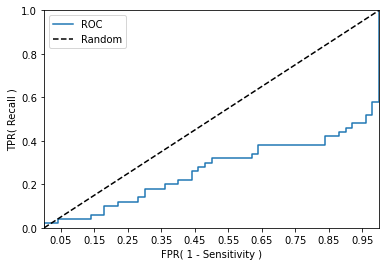



1      예측0  예측1
실제0   37   13
실제1   44    6 
 acc: 0.43 auc: 0.2628

#2 교차 검증 정확도 :0.51, 학습 데이터 크기: 900, 검증 데이터 크기: 100

2 검증 세트 인덱스:96     630
98     625
100    508
101    977
103    604
      ... 
195    812
196    867
197    565
200    559
203    789
Name: Unnamed: 0, Length: 100, dtype: int64


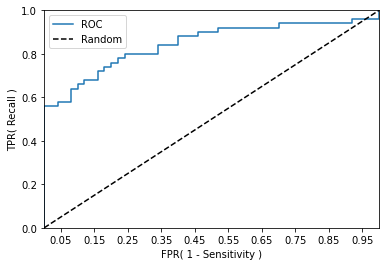



2      예측0  예측1
실제0    4   46
실제1    3   47 
 acc: 0.51 auc: 0.8452000000000001

#3 교차 검증 정확도 :0.54, 학습 데이터 크기: 900, 검증 데이터 크기: 100

3 검증 세트 인덱스:198     53
199    431
201    146
202    428
204    292
      ... 
295    885
296     96
297    383
301    352
303    220
Name: Unnamed: 0, Length: 100, dtype: int64


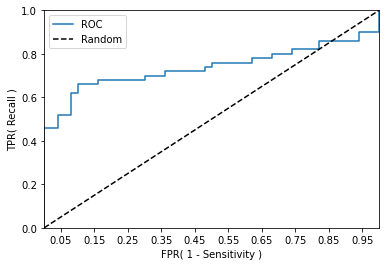



3      예측0  예측1
실제0   50    0
실제1   46    4 
 acc: 0.54 auc: 0.7384

#4 교차 검증 정확도 :0.86, 학습 데이터 크기: 900, 검증 데이터 크기: 100

4 검증 세트 인덱스:298    607
299    844
300    642
302    803
304    799
      ... 
400    438
401    104
403    307
404    152
406    277
Name: Unnamed: 0, Length: 100, dtype: int64


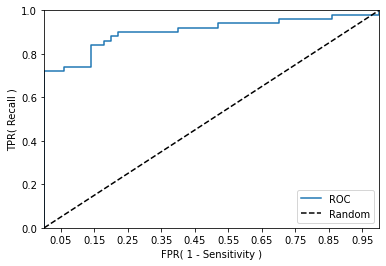



4      예측0  예측1
실제0   50    0
실제1   14   36 
 acc: 0.86 auc: 0.9032

#5 교차 검증 정확도 :0.89, 학습 데이터 크기: 900, 검증 데이터 크기: 100

5 검증 세트 인덱스:394    826
396    544
397    918
398    822
399    599
      ... 
495    430
499    407
500     10
501    233
502    476
Name: Unnamed: 0, Length: 100, dtype: int64


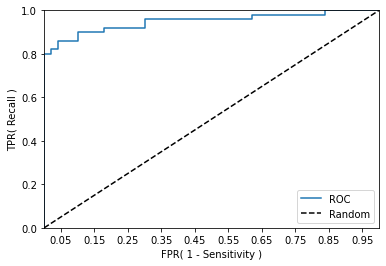



5      예측0  예측1
실제0   46    4
실제1    7   43 
 acc: 0.89 auc: 0.9492

#6 교차 검증 정확도 :0.53, 학습 데이터 크기: 900, 검증 데이터 크기: 100

6 검증 세트 인덱스:496    605
497    858
498    631
503     72
504    840
      ... 
595    268
596    187
597    973
598     12
599    610
Name: Unnamed: 0, Length: 100, dtype: int64


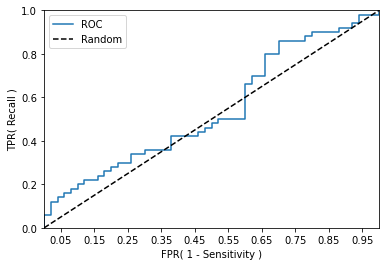



6      예측0  예측1
실제0   19   31
실제1   16   34 
 acc: 0.53 auc: 0.5432

#7 교차 검증 정확도 :0.72, 학습 데이터 크기: 900, 검증 데이터 크기: 100

7 검증 세트 인덱스:600    312
601    416
602    719
603    297
604    487
      ... 
703    811
705    687
706    584
707    647
711    901
Name: Unnamed: 0, Length: 100, dtype: int64


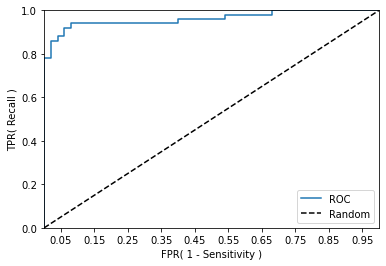



7      예측0  예측1
실제0   24   26
실제1    2   48 
 acc: 0.72 auc: 0.9611999999999999

#8 교차 검증 정확도 :0.77, 학습 데이터 크기: 900, 검증 데이터 크기: 100

8 검증 세트 인덱스:690     25
691    479
695     62
696    158
697    153
      ... 
795    324
796    790
797    994
798     75
799    643
Name: Unnamed: 0, Length: 100, dtype: int64


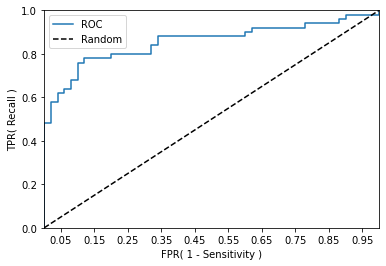



8      예측0  예측1
실제0   48    2
실제1   21   29 
 acc: 0.77 auc: 0.8555999999999999

#9 교차 검증 정확도 :0.74, 학습 데이터 크기: 900, 검증 데이터 크기: 100

9 검증 세트 인덱스:800    603
801    241
802    462
803    167
804    908
      ... 
895    636
897    657
898    755
899    741
901    936
Name: Unnamed: 0, Length: 100, dtype: int64


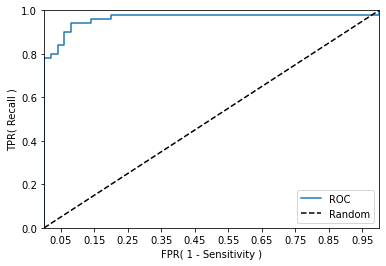



9      예측0  예측1
실제0   50    0
실제1   26   24 
 acc: 0.74 auc: 0.9644

#10 교차 검증 정확도 :0.75, 학습 데이터 크기: 900, 검증 데이터 크기: 100

10 검증 세트 인덱스:896    333
900     74
902    256
903    247
904    813
      ... 
995    452
996    635
997    288
998    617
999    831
Name: Unnamed: 0, Length: 100, dtype: int64


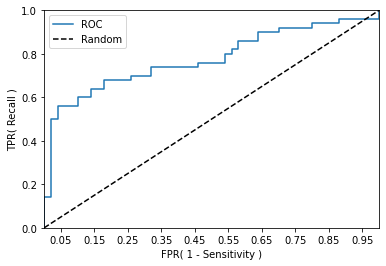



10      예측0  예측1
실제0   45    5
실제1   20   30 
 acc: 0.75 auc: 0.7772
================================================skfold 2 번째================================================

#11 교차 검증 정확도 :0.76, 학습 데이터 크기: 900, 검증 데이터 크기: 100

11 검증 세트 인덱스:0      843
1      152
2      221
3      998
4      133
      ... 
95     595
96     875
99      86
100    203
103    111
Name: Unnamed: 0, Length: 100, dtype: int64


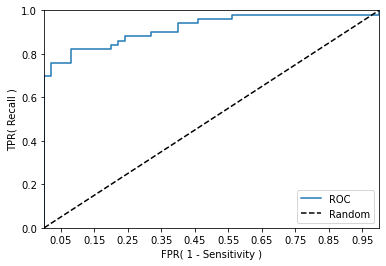



11      예측0  예측1
실제0   31   19
실제1    5   45 
 acc: 0.76 auc: 0.9179999999999999

#12 교차 검증 정확도 :0.68, 학습 데이터 크기: 900, 검증 데이터 크기: 100

12 검증 세트 인덱스:97     957
98     923
101    741
102    658
104    764
      ... 
195     87
197    204
199     90
200     18
202    454
Name: Unnamed: 0, Length: 100, dtype: int64


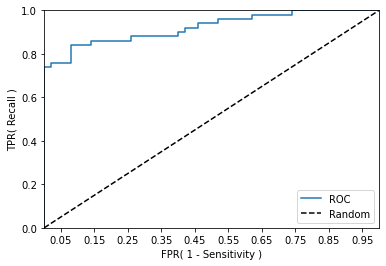



12      예측0  예측1
실제0   20   30
실제1    2   48 
 acc: 0.68 auc: 0.922

#13 교차 검증 정확도 :0.71, 학습 데이터 크기: 900, 검증 데이터 크기: 100

13 검증 세트 인덱스:196    913
198    617
201    802
203    281
204    781
      ... 
297    422
299    249
300     38
303    433
304     76
Name: Unnamed: 0, Length: 100, dtype: int64


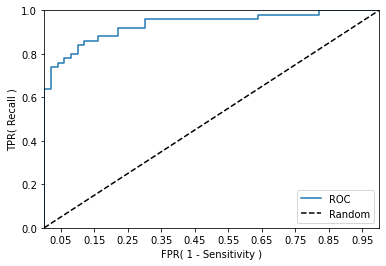



13      예측0  예측1
실제0   23   27
실제1    2   48 
 acc: 0.71 auc: 0.9348

#14 교차 검증 정확도 :0.83, 학습 데이터 크기: 900, 검증 데이터 크기: 100

14 검증 세트 인덱스:292    838
293    621
298    637
301    765
302    748
      ... 
395    817
396    526
397    345
398    369
401     33
Name: Unnamed: 0, Length: 100, dtype: int64


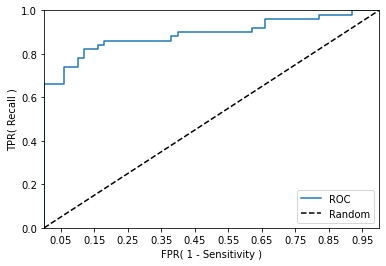



14      예측0  예측1
실제0   47    3
실제1   14   36 
 acc: 0.83 auc: 0.8904

#15 교차 검증 정확도 :0.71, 학습 데이터 크기: 900, 검증 데이터 크기: 100

15 검증 세트 인덱스:399    901
400    679
402    298
403    405
404    498
      ... 
495    716
496    794
497    146
498    317
500    165
Name: Unnamed: 0, Length: 100, dtype: int64


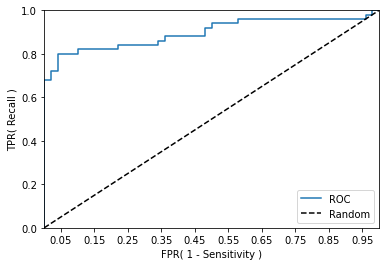



15      예측0  예측1
실제0   26   24
실제1    5   45 
 acc: 0.71 auc: 0.896

#16 교차 검증 정확도 :0.9, 학습 데이터 크기: 900, 검증 데이터 크기: 100

16 검증 세트 인덱스:499    787
501    731
502    624
503    337
504    254
      ... 
608    588
609    799
611    969
612    655
614    725
Name: Unnamed: 0, Length: 100, dtype: int64


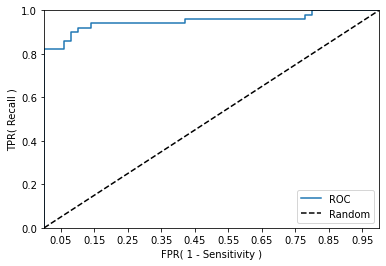



16      예측0  예측1
실제0   47    3
실제1    7   43 
 acc: 0.9 auc: 0.9495999999999999

#17 교차 검증 정확도 :0.82, 학습 데이터 크기: 900, 검증 데이터 크기: 100

17 검증 세트 인덱스:589    237
590    100
591    340
592    105
593    274
      ... 
706    675
708    547
710    753
711    632
714    873
Name: Unnamed: 0, Length: 100, dtype: int64


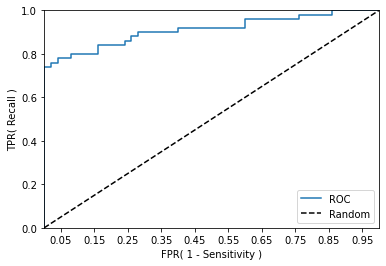



17      예측0  예측1
실제0   50    0
실제1   18   32 
 acc: 0.82 auc: 0.9107999999999999

#18 교차 검증 정확도 :0.49, 학습 데이터 크기: 900, 검증 데이터 크기: 100

18 검증 세트 인덱스:681    227
684    245
686    309
687    243
688     56
      ... 
796    250
799    366
803     11
805    470
806    144
Name: Unnamed: 0, Length: 100, dtype: int64


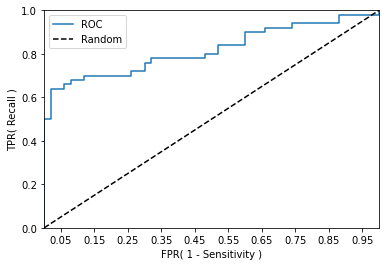



18      예측0  예측1
실제0    0   50
실제1    1   49 
 acc: 0.49 auc: 0.8188000000000001

#19 교차 검증 정확도 :0.78, 학습 데이터 크기: 900, 검증 데이터 크기: 100

19 검증 세트 인덱스:795    708
797    505
798    960
800    810
801    616
      ... 
897    252
898     71
899      5
900    283
903    267
Name: Unnamed: 0, Length: 100, dtype: int64


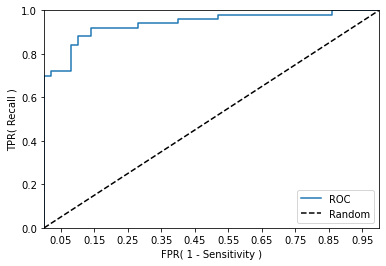



19      예측0  예측1
실제0   30   20
실제1    2   48 
 acc: 0.78 auc: 0.9391999999999999

#20 교차 검증 정확도 :0.87, 학습 데이터 크기: 900, 검증 데이터 크기: 100

20 검증 세트 인덱스:895    587
896    937
901    958
902    914
904     23
      ... 
995     68
996    500
997    218
998     91
999    122
Name: Unnamed: 0, Length: 100, dtype: int64


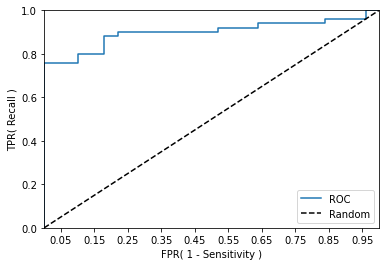



20      예측0  예측1
실제0   50    0
실제1   13   37 
 acc: 0.87 auc: 0.8988
================================================skfold 3 번째================================================

#21 교차 검증 정확도 :0.77, 학습 데이터 크기: 900, 검증 데이터 크기: 100

21 검증 세트 인덱스:0      578
1      882
2      911
3      908
4      321
      ... 
95     351
99     320
100    253
102    295
107    211
Name: Unnamed: 0, Length: 100, dtype: int64


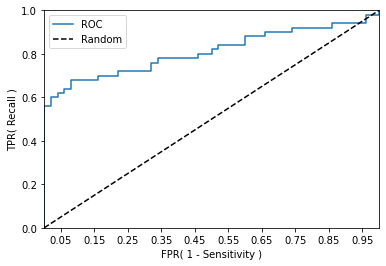



21      예측0  예측1
실제0   42    8
실제1   15   35 
 acc: 0.77 auc: 0.8096

#22 교차 검증 정확도 :0.77, 학습 데이터 크기: 900, 검증 데이터 크기: 100

22 검증 세트 인덱스:96     721
97     853
98     771
101    773
103    515
      ... 
205     13
206     24
207    452
208    265
210    324
Name: Unnamed: 0, Length: 100, dtype: int64


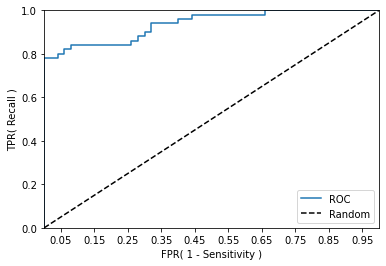



22      예측0  예측1
실제0   28   22
실제1    1   49 
 acc: 0.77 auc: 0.9368

#23 교차 검증 정확도 :0.81, 학습 데이터 크기: 900, 검증 데이터 크기: 100

23 검증 세트 인덱스:187    557
188    505
189    781
191    850
194    798
      ... 
295    258
296    339
297    196
299    680
301    979
Name: Unnamed: 0, Length: 100, dtype: int64


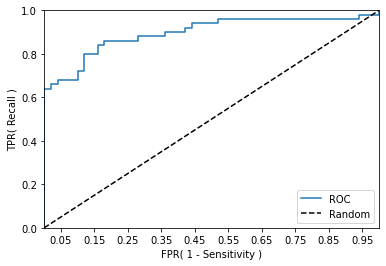



23      예측0  예측1
실제0   49    1
실제1   18   32 
 acc: 0.81 auc: 0.896

#24 교차 검증 정확도 :0.71, 학습 데이터 크기: 900, 검증 데이터 크기: 100

24 검증 세트 인덱스:298    343
300    356
302    319
303    635
304    166
      ... 
401    854
402    688
403    574
406    553
407    700
Name: Unnamed: 0, Length: 100, dtype: int64


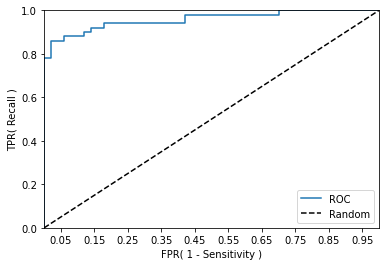



24      예측0  예측1
실제0   50    0
실제1   29   21 
 acc: 0.71 auc: 0.9576

#25 교차 검증 정확도 :0.84, 학습 데이터 크기: 900, 검증 데이터 크기: 100

25 검증 세트 인덱스:392    270
393     20
396    449
397     81
398    257
      ... 
495    573
496    289
499    348
502    374
504    100
Name: Unnamed: 0, Length: 100, dtype: int64


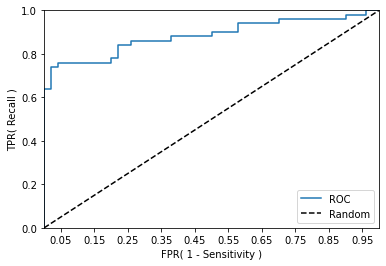



25      예측0  예측1
실제0   46    4
실제1   12   38 
 acc: 0.84 auc: 0.8828

#26 교차 검증 정확도 :0.83, 학습 데이터 크기: 900, 검증 데이터 크기: 100

26 검증 세트 인덱스:497    570
498    630
500    554
501    597
503    827
      ... 
595    345
596    177
599    789
601    646
603    877
Name: Unnamed: 0, Length: 100, dtype: int64


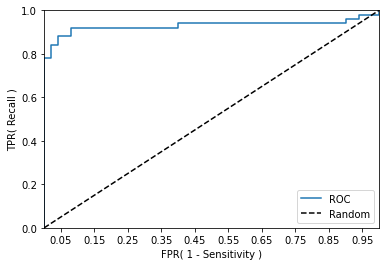



26      예측0  예측1
실제0   50    0
실제1   17   33 
 acc: 0.83 auc: 0.9292

#27 교차 검증 정확도 :0.56, 학습 데이터 크기: 900, 검증 데이터 크기: 100

27 검증 세트 인덱스:597    325
598    121
600    411
602    425
604    804
      ... 
695    229
696    135
700    955
701    833
702    604
Name: Unnamed: 0, Length: 100, dtype: int64


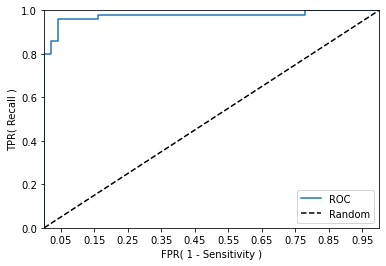



27      예측0  예측1
실제0    6   44
실제1    0   50 
 acc: 0.56 auc: 0.976

#28 교차 검증 정확도 :0.91, 학습 데이터 크기: 900, 검증 데이터 크기: 100

28 검증 세트 인덱스:697    481
698    387
699    156
703     11
704    930
      ... 
795    260
796    316
797    587
798    970
799    350
Name: Unnamed: 0, Length: 100, dtype: int64


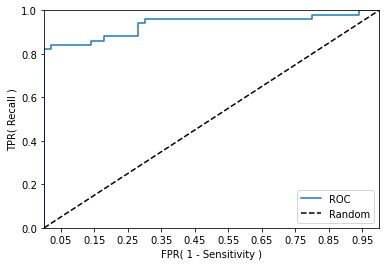



28      예측0  예측1
실제0   50    0
실제1    9   41 
 acc: 0.91 auc: 0.9355999999999999

#29 교차 검증 정확도 :0.49, 학습 데이터 크기: 900, 검증 데이터 크기: 100

29 검증 세트 인덱스:800    146
801    749
802    232
803    836
804    364
      ... 
895    613
897    490
898    287
902    360
904    400
Name: Unnamed: 0, Length: 100, dtype: int64


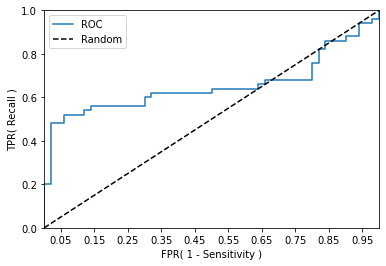



29      예측0  예측1
실제0    1   49
실제1    2   48 
 acc: 0.49 auc: 0.6516

#30 교차 검증 정확도 :0.51, 학습 데이터 크기: 900, 검증 데이터 크기: 100

30 검증 세트 인덱스:896    897
899    671
900    980
901    801
903    588
      ... 
995     83
996     35
997     29
998    326
999    953
Name: Unnamed: 0, Length: 100, dtype: int64


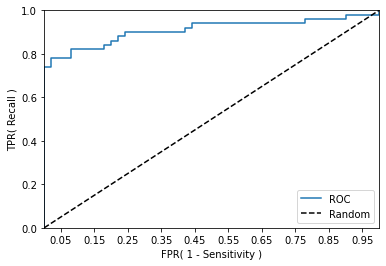



30      예측0  예측1
실제0    2   48
실제1    1   49 
 acc: 0.51 auc: 0.9083999999999999
================================================종료================================================

## 교차 검증별 acc: [0.43 0.51 0.54 0.86 0.89 0.53 0.72 0.77 0.74 0.75 0.76 0.68 0.71 0.83
 0.71 0.9  0.82 0.49 0.78 0.87 0.77 0.77 0.81 0.71 0.84 0.83 0.56 0.91
 0.49 0.51]

## 교차 검증별 auc: [0.2628 0.8452 0.7384 0.9032 0.9492 0.5432 0.9612 0.8556 0.9644 0.7772
 0.918  0.922  0.9348 0.8904 0.896  0.9496 0.9108 0.8188 0.9392 0.8988
 0.8096 0.9368 0.896  0.9576 0.8828 0.9292 0.976  0.9356 0.6516 0.9084]

## 평균 검증 정확도: 0.7163333333333333

## 평균 검증 auc: 0.8587466666666667
       fold_0        fold_1        fold_2       fold_3        fold_4         \
          예측0    예측1    예측0    예측1    예측0   예측1    예측0    예측1    예측0    예측1   
실제0     37.00  13.00   4.00  46.00  50.00  0.00  50.00   0.00  46.00   4.00   
실제1     44.00   6.00   3.00  47.00  46.00  4.00  14.00  36.00   7.00  43.00   
accauc   0.43   0.51   0.54   0.86

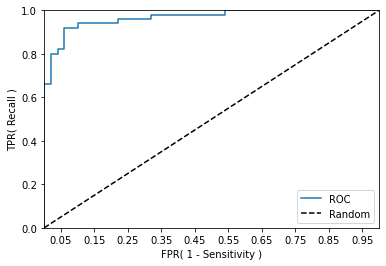



1      예측0  예측1
실제0   46    4
실제1    4   46 
 acc: 0.92 auc: 0.9668
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04218271604938273
            Iterations: 5
            Function evaluations: 123
            Gradient evaluations: 5

#2 교차 검증 정확도 :0.86, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#2 검증 세트 인덱스:50      50
51      51
52      52
53      53
54      54
      ... 
595    595
596    596
597    597
598    598
599    599
Name: Unnamed: 0, Length: 100, dtype: int64


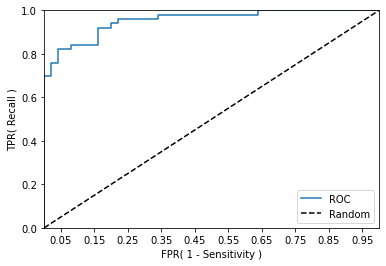



2      예측0  예측1
실제0   40   10
실제1    4   46 
 acc: 0.86 auc: 0.954
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.034548148148148106
            Iterations: 15
            Function evaluations: 354
            Gradient evaluations: 15

#3 교차 검증 정확도 :0.93, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#3 검증 세트 인덱스:100    100
101    101
102    102
103    103
104    104
      ... 
645    645
646    646
647    647
648    648
649    649
Name: Unnamed: 0, Length: 100, dtype: int64


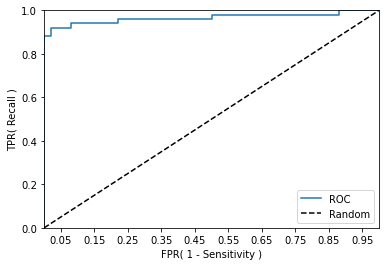



3      예측0  예측1
실제0   49    1
실제1    6   44 
 acc: 0.93 auc: 0.9656000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03359506172839499
            Iterations: 7
            Function evaluations: 165
            Gradient evaluations: 7

#4 교차 검증 정확도 :0.88, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#4 검증 세트 인덱스:150    150
151    151
152    152
153    153
154    154
      ... 
695    695
696    696
697    697
698    698
699    699
Name: Unnamed: 0, Length: 100, dtype: int64


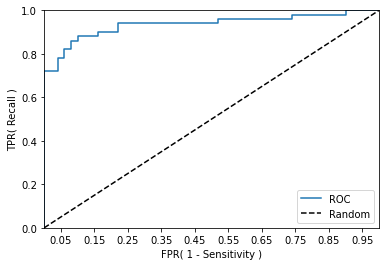



4      예측0  예측1
실제0   47    3
실제1    9   41 
 acc: 0.88 auc: 0.9348000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04007407407407404
            Iterations: 8
            Function evaluations: 183
            Gradient evaluations: 8

#5 교차 검증 정확도 :0.9, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#5 검증 세트 인덱스:200    200
201    201
202    202
203    203
204    204
      ... 
745    745
746    746
747    747
748    748
749    749
Name: Unnamed: 0, Length: 100, dtype: int64


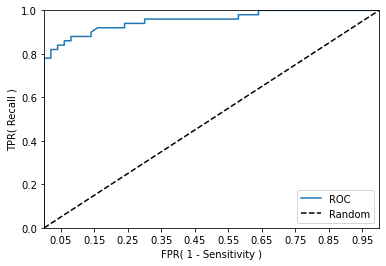



5      예측0  예측1
실제0   47    3
실제1    7   43 
 acc: 0.9 auc: 0.9546000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.048474074074074114
            Iterations: 13
            Function evaluations: 304
            Gradient evaluations: 13

#6 교차 검증 정확도 :0.87, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#6 검증 세트 인덱스:250    250
251    251
252    252
253    253
254    254
      ... 
795    795
796    796
797    797
798    798
799    799
Name: Unnamed: 0, Length: 100, dtype: int64


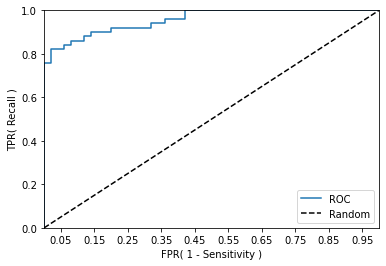



6      예측0  예측1
실제0   42    8
실제1    5   45 
 acc: 0.87 auc: 0.9564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.046395061728394915
            Iterations: 4
            Function evaluations: 107
            Gradient evaluations: 4

#7 교차 검증 정확도 :0.91, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#7 검증 세트 인덱스:300    300
301    301
302    302
303    303
304    304
      ... 
845    845
846    846
847    847
848    848
849    849
Name: Unnamed: 0, Length: 100, dtype: int64


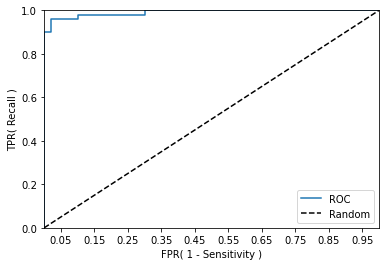



7      예측0  예측1
실제0   42    8
실제1    1   49 
 acc: 0.91 auc: 0.9907999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03351604938271602
            Iterations: 17
            Function evaluations: 393
            Gradient evaluations: 17

#8 교차 검증 정확도 :0.79, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#8 검증 세트 인덱스:350    350
351    351
352    352
353    353
354    354
      ... 
895    895
896    896
897    897
898    898
899    899
Name: Unnamed: 0, Length: 100, dtype: int64


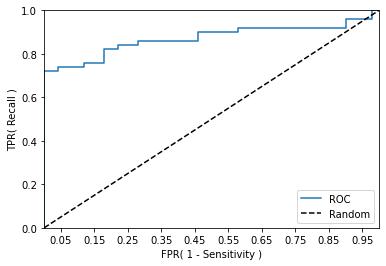



8      예측0  예측1
실제0   41    9
실제1   12   38 
 acc: 0.79 auc: 0.8708
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03763456790123465
            Iterations: 6
            Function evaluations: 146
            Gradient evaluations: 6

#9 교차 검증 정확도 :0.92, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#9 검증 세트 인덱스:400    400
401    401
402    402
403    403
404    404
      ... 
945    945
946    946
947    947
948    948
949    949
Name: Unnamed: 0, Length: 100, dtype: int64


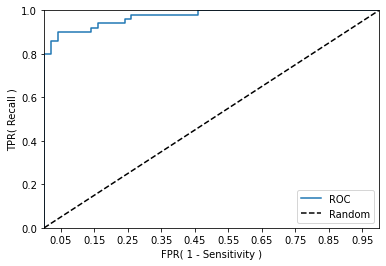



9      예측0  예측1
실제0   49    1
실제1    7   43 
 acc: 0.92 auc: 0.972
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04041975308641965
            Iterations: 8
            Function evaluations: 182
            Gradient evaluations: 8

#10 교차 검증 정확도 :0.93, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#10 검증 세트 인덱스:450    450
451    451
452    452
453    453
454    454
      ... 
995    995
996    996
997    997
998    998
999    999
Name: Unnamed: 0, Length: 100, dtype: int64


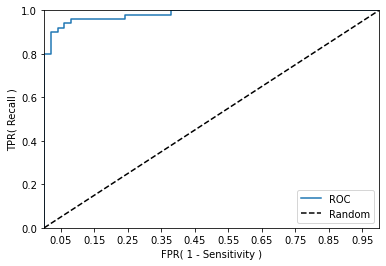



10      예측0  예측1
실제0   46    4
실제1    3   47 
 acc: 0.93 auc: 0.982
================================================ 1 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.059743209876543246
            Iterations: 9
            Function evaluations: 200
            Gradient evaluations: 9

#11 교차 검증 정확도 :0.88, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#11 검증 세트 인덱스:0        0
1        1
2        2
3        3
4        4
      ... 
545    545
546    546
547    547
548    548
549    549
Name: Unnamed: 0, Length: 100, dtype: int64


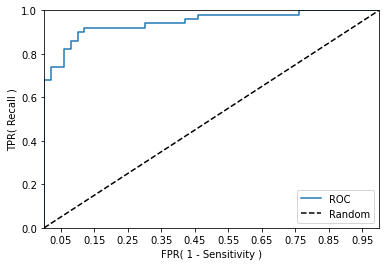



11      예측0  예측1
실제0   45    5
실제1    7   43 
 acc: 0.88 auc: 0.9456
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.038330864197530845
            Iterations: 3
            Function evaluations: 77
            Gradient evaluations: 3

#12 교차 검증 정확도 :0.87, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#12 검증 세트 인덱스:50      50
51      51
52      52
53      53
54      54
      ... 
595    595
596    596
597    597
598    598
599    599
Name: Unnamed: 0, Length: 100, dtype: int64


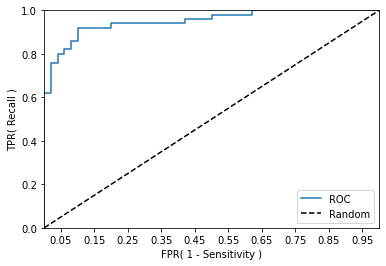



12      예측0  예측1
실제0   40   10
실제1    3   47 
 acc: 0.87 auc: 0.9504
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.042750617283950465
            Iterations: 8
            Function evaluations: 193
            Gradient evaluations: 8

#13 교차 검증 정확도 :0.92, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#13 검증 세트 인덱스:100    100
101    101
102    102
103    103
104    104
      ... 
645    645
646    646
647    647
648    648
649    649
Name: Unnamed: 0, Length: 100, dtype: int64


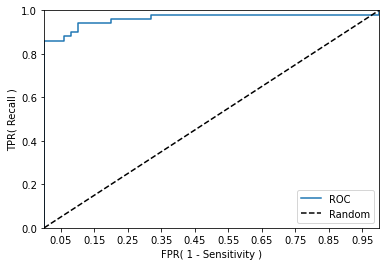



13      예측0  예측1
실제0   49    1
실제1    7   43 
 acc: 0.92 auc: 0.9627999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.041081481481481386
            Iterations: 14
            Function evaluations: 323
            Gradient evaluations: 14

#14 교차 검증 정확도 :0.89, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#14 검증 세트 인덱스:150    150
151    151
152    152
153    153
154    154
      ... 
695    695
696    696
697    697
698    698
699    699
Name: Unnamed: 0, Length: 100, dtype: int64


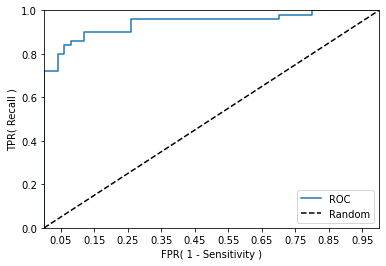



14      예측0  예측1
실제0   46    4
실제1    7   43 
 acc: 0.89 auc: 0.9424
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04388641975308627
            Iterations: 9
            Function evaluations: 211
            Gradient evaluations: 9

#15 교차 검증 정확도 :0.9, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#15 검증 세트 인덱스:200    200
201    201
202    202
203    203
204    204
      ... 
745    745
746    746
747    747
748    748
749    749
Name: Unnamed: 0, Length: 100, dtype: int64


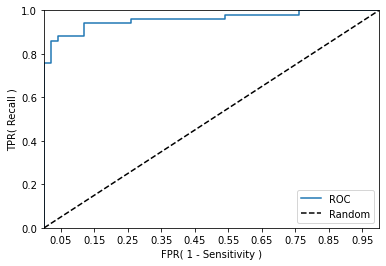



15      예측0  예측1
실제0   46    4
실제1    6   44 
 acc: 0.9 auc: 0.9588000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.046380246913580336
            Iterations: 4
            Function evaluations: 95
            Gradient evaluations: 4

#16 교차 검증 정확도 :0.89, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#16 검증 세트 인덱스:250    250
251    251
252    252
253    253
254    254
      ... 
795    795
796    796
797    797
798    798
799    799
Name: Unnamed: 0, Length: 100, dtype: int64


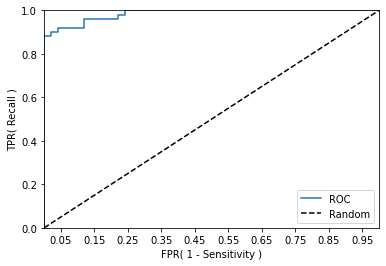



16      예측0  예측1
실제0   41    9
실제1    2   48 
 acc: 0.89 auc: 0.9848
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04526913580246905
            Iterations: 3
            Function evaluations: 83
            Gradient evaluations: 3

#17 교차 검증 정확도 :0.89, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#17 검증 세트 인덱스:300    300
301    301
302    302
303    303
304    304
      ... 
845    845
846    846
847    847
848    848
849    849
Name: Unnamed: 0, Length: 100, dtype: int64


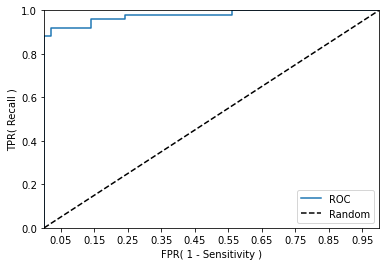



17      예측0  예측1
실제0   41    9
실제1    2   48 
 acc: 0.89 auc: 0.9776
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.029703703703703566
            Iterations: 8
            Function evaluations: 203
            Gradient evaluations: 8

#18 교차 검증 정확도 :0.81, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#18 검증 세트 인덱스:350    350
351    351
352    352
353    353
354    354
      ... 
895    895
896    896
897    897
898    898
899    899
Name: Unnamed: 0, Length: 100, dtype: int64


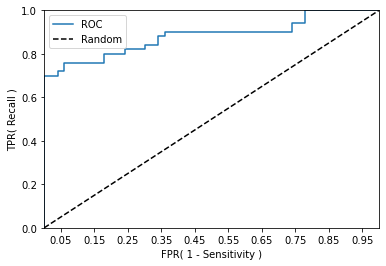



18      예측0  예측1
실제0   41    9
실제1   10   40 
 acc: 0.81 auc: 0.8816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.060004938271605024
            Iterations: 18
            Function evaluations: 415
            Gradient evaluations: 18

#19 교차 검증 정확도 :0.94, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#19 검증 세트 인덱스:400    400
401    401
402    402
403    403
404    404
      ... 
945    945
946    946
947    947
948    948
949    949
Name: Unnamed: 0, Length: 100, dtype: int64


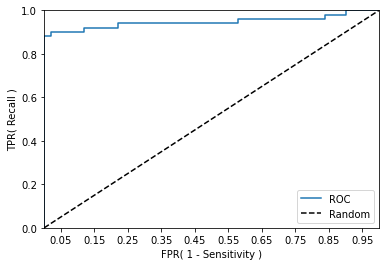



19      예측0  예측1
실제0   50    0
실제1    6   44 
 acc: 0.94 auc: 0.9464000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.047451851851851856
            Iterations: 5
            Function evaluations: 121
            Gradient evaluations: 5

#20 교차 검증 정확도 :0.92, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#20 검증 세트 인덱스:450    450
451    451
452    452
453    453
454    454
      ... 
995    995
996    996
997    997
998    998
999    999
Name: Unnamed: 0, Length: 100, dtype: int64


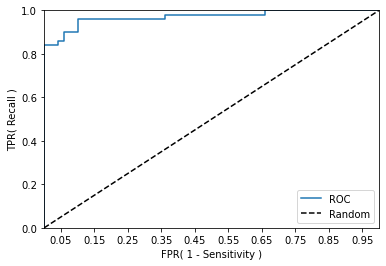



20      예측0  예측1
실제0   47    3
실제1    5   45 
 acc: 0.92 auc: 0.9704
================================================ 2 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03614320987654318
            Iterations: 14
            Function evaluations: 322
            Gradient evaluations: 14

#21 교차 검증 정확도 :0.92, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#21 검증 세트 인덱스:0        0
1        1
2        2
3        3
4        4
      ... 
545    545
546    546
547    547
548    548
549    549
Name: Unnamed: 0, Length: 100, dtype: int64


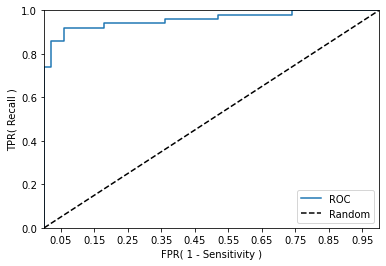



21      예측0  예측1
실제0   46    4
실제1    4   46 
 acc: 0.92 auc: 0.958
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.050750617283950694
            Iterations: 19
            Function evaluations: 414
            Gradient evaluations: 18

#22 교차 검증 정확도 :0.86, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#22 검증 세트 인덱스:50      50
51      51
52      52
53      53
54      54
      ... 
595    595
596    596
597    597
598    598
599    599
Name: Unnamed: 0, Length: 100, dtype: int64


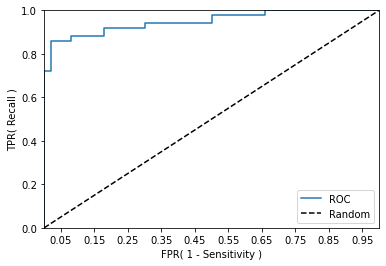



22      예측0  예측1
실제0   41    9
실제1    5   45 
 acc: 0.86 auc: 0.9491999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.034538271604938275
            Iterations: 10
            Function evaluations: 225
            Gradient evaluations: 10

#23 교차 검증 정확도 :0.93, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#23 검증 세트 인덱스:100    100
101    101
102    102
103    103
104    104
      ... 
645    645
646    646
647    647
648    648
649    649
Name: Unnamed: 0, Length: 100, dtype: int64


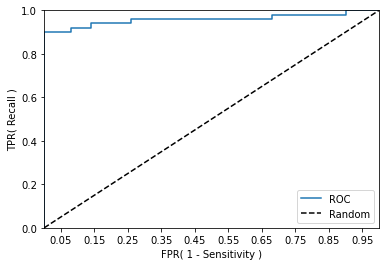



23      예측0  예측1
실제0   48    2
실제1    5   45 
 acc: 0.93 auc: 0.9588
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03405925925925912
            Iterations: 11
            Function evaluations: 251
            Gradient evaluations: 11

#24 교차 검증 정확도 :0.89, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#24 검증 세트 인덱스:150    150
151    151
152    152
153    153
154    154
      ... 
695    695
696    696
697    697
698    698
699    699
Name: Unnamed: 0, Length: 100, dtype: int64


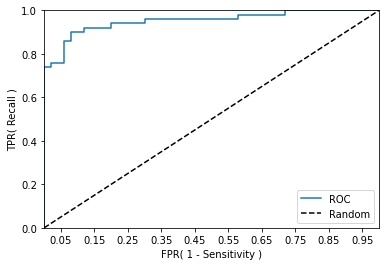



24      예측0  예측1
실제0   46    4
실제1    7   43 
 acc: 0.89 auc: 0.952
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03897777777777789
            Iterations: 12
            Function evaluations: 283
            Gradient evaluations: 12

#25 교차 검증 정확도 :0.9, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#25 검증 세트 인덱스:200    200
201    201
202    202
203    203
204    204
      ... 
745    745
746    746
747    747
748    748
749    749
Name: Unnamed: 0, Length: 100, dtype: int64


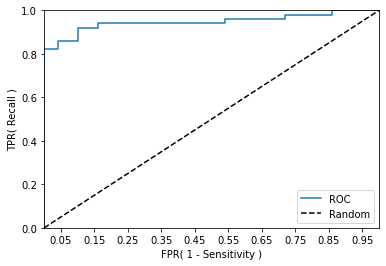



25      예측0  예측1
실제0   47    3
실제1    7   43 
 acc: 0.9 auc: 0.9467999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.041056790123456866
            Iterations: 10
            Function evaluations: 238
            Gradient evaluations: 10

#26 교차 검증 정확도 :0.92, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#26 검증 세트 인덱스:250    250
251    251
252    252
253    253
254    254
      ... 
795    795
796    796
797    797
798    798
799    799
Name: Unnamed: 0, Length: 100, dtype: int64


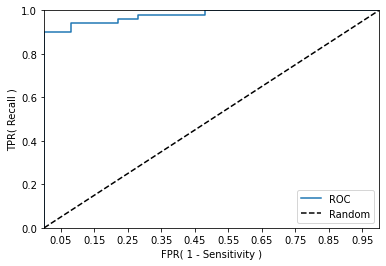



26      예측0  예측1
실제0   45    5
실제1    3   47 
 acc: 0.92 auc: 0.9772
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03976296296296289
            Iterations: 5
            Function evaluations: 123
            Gradient evaluations: 5

#27 교차 검증 정확도 :0.88, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#27 검증 세트 인덱스:300    300
301    301
302    302
303    303
304    304
      ... 
845    845
846    846
847    847
848    848
849    849
Name: Unnamed: 0, Length: 100, dtype: int64


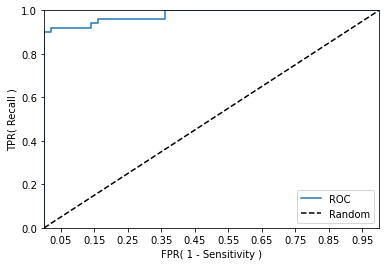



27      예측0  예측1
실제0   40   10
실제1    2   48 
 acc: 0.88 auc: 0.9792
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04200000000000004
            Iterations: 6
            Function evaluations: 168
            Gradient evaluations: 6

#28 교차 검증 정확도 :0.77, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#28 검증 세트 인덱스:350    350
351    351
352    352
353    353
354    354
      ... 
895    895
896    896
897    897
898    898
899    899
Name: Unnamed: 0, Length: 100, dtype: int64


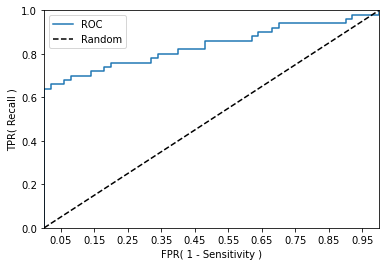



28      예측0  예측1
실제0   41    9
실제1   14   36 
 acc: 0.77 auc: 0.8368
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04040493827160485
            Iterations: 18
            Function evaluations: 405
            Gradient evaluations: 18

#29 교차 검증 정확도 :0.94, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#29 검증 세트 인덱스:400    400
401    401
402    402
403    403
404    404
      ... 
945    945
946    946
947    947
948    948
949    949
Name: Unnamed: 0, Length: 100, dtype: int64


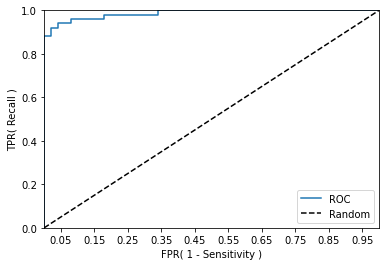



29      예측0  예측1
실제0   49    1
실제1    5   45 
 acc: 0.94 auc: 0.9863999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0517185185185185
            Iterations: 14
            Function evaluations: 313
            Gradient evaluations: 14

#30 교차 검증 정확도 :0.95, 학습 데이터 크기: 900, 검증 데이터 크기: 100
#30 검증 세트 인덱스:450    450
451    451
452    452
453    453
454    454
      ... 
995    995
996    996
997    997
998    998
999    999
Name: Unnamed: 0, Length: 100, dtype: int64


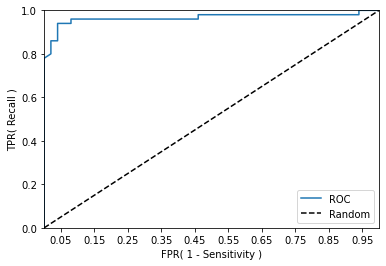



30      예측0  예측1
실제0   48    2
실제1    3   47 
 acc: 0.95 auc: 0.9658
================================================종료================================================

## 교차 검증별 acc: [0.92 0.86 0.93 0.88 0.9  0.87 0.91 0.79 0.92 0.93 0.88 0.87 0.92 0.89
 0.9  0.89 0.89 0.81 0.94 0.92 0.92 0.86 0.93 0.89 0.9  0.92 0.88 0.77
 0.94 0.95]

## 교차 검증별 auc: [0.9668 0.954  0.9656 0.9348 0.9546 0.9564 0.9908 0.8708 0.972  0.982
 0.9456 0.9504 0.9628 0.9424 0.9588 0.9848 0.9776 0.8816 0.9464 0.9704
 0.958  0.9492 0.9588 0.952  0.9468 0.9772 0.9792 0.8368 0.9864 0.9658]
## 평균 검증 정확도: 0.8926666666666667
## 평균 검증 auc: 0.9526266666666667
       fold_0        fold_1        fold_2        fold_3        fold_4         \
          예측0    예측1    예측0    예측1    예측0    예측1    예측0    예측1    예측0    예측1   
실제0     46.00   4.00  40.00  10.00   49.0   1.00  47.00   3.00  47.00   3.00   
실제1      4.00  46.00   4.00  46.00    6.0  44.00   9.00  41.00   7.00  43.00   
accauc   0.92   0.86   0.93   0.88    0.9   0

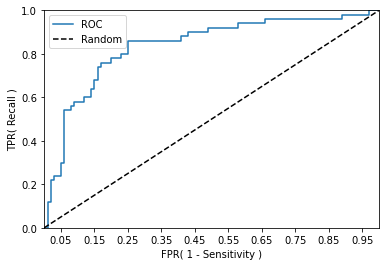



1      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.8361999999999999

#2 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

2 검증 세트 인덱스:146    1000
147    1344
148    1147
150    1486
152    1490
       ... 
298    1281
299    1161
302    1103
306    1197
308    1256
Name: Unnamed: 0, Length: 150, dtype: int64


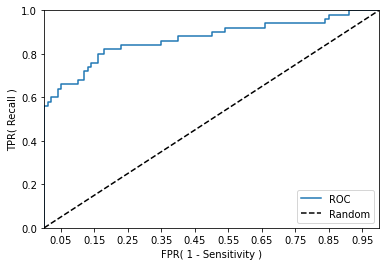



2      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.869

#3 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

3 검증 세트 인덱스:295     497
296     646
297     459
300     273
301     741
       ... 
477    1435
479    1357
484    1078
488    1455
491    1022
Name: Unnamed: 0, Length: 150, dtype: int64


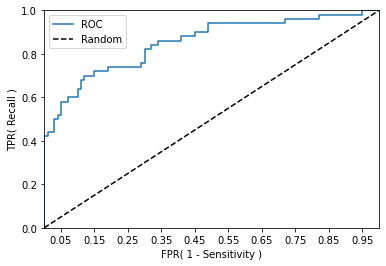



3      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.8515999999999999

#4 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

4 검증 세트 인덱스:436     542
437     539
438     939
439     711
440     420
       ... 
627    1320
628    1431
629    1484
633    1331
636    1304
Name: Unnamed: 0, Length: 150, dtype: int64


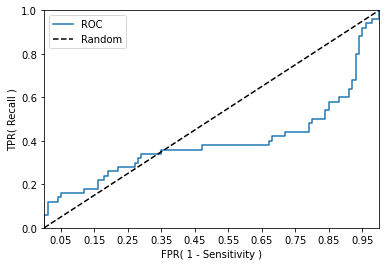



4      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.3927999999999999

#5 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

5 검증 세트 인덱스:581     370
582     826
586     288
587     123
589     293
       ... 
776    1203
780    1443
782    1150
788    1360
789    1112
Name: Unnamed: 0, Length: 150, dtype: int64


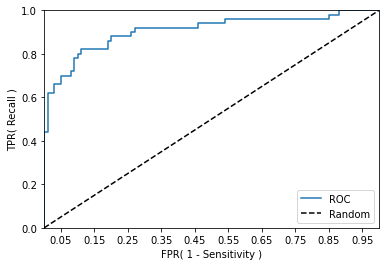



5      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9069999999999999

#6 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

6 검증 세트 인덱스:729     806
730     849
733     216
734     283
736     987
       ... 
904    1395
905    1172
915    1184
919    1026
922    1302
Name: Unnamed: 0, Length: 150, dtype: int64


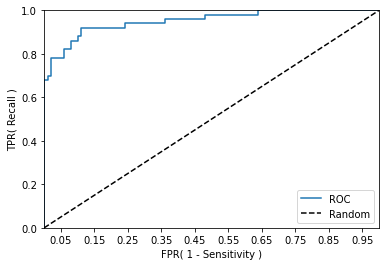



6      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9518

#7 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

7 검증 세트 인덱스:886      104
889      388
893       99
894      243
896      206
        ... 
1046    1200
1059    1084
1066    1423
1068    1489
1069    1288
Name: Unnamed: 0, Length: 150, dtype: int64


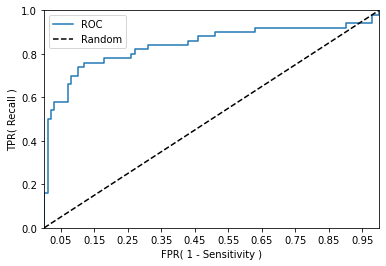



7      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.8412000000000001

#8 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

8 검증 세트 인덱스:1044     182
1047     789
1048      75
1049     805
1050     322
        ... 
1195     131
1196    1236
1199     177
1200     297
1201     630
Name: Unnamed: 0, Length: 150, dtype: int64


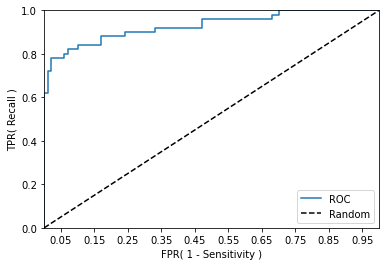



8      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9286

#9 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

9 검증 세트 인덱스:1197    1195
1198    1174
1202     968
1203     260
1204    1164
        ... 
1345    1218
1346     660
1347     798
1348     713
1351    1322
Name: Unnamed: 0, Length: 150, dtype: int64


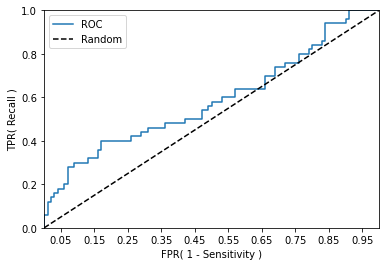



9      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.5864

#10 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

10 검증 세트 인덱스:1349      62
1350     895
1352    1470
1353     203
1354     473
        ... 
1495     691
1496      47
1497    1442
1498     217
1499     236
Name: Unnamed: 0, Length: 150, dtype: int64


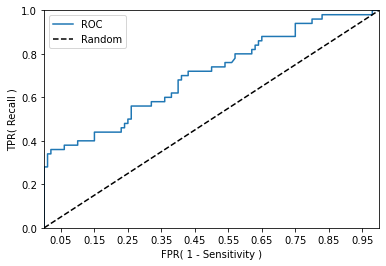



10      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.7062999999999999
================================================skfold 2 번째================================================

#11 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

11 검증 세트 인덱스:0       349
1        36
2       442
3      1121
4       688
       ... 
153    1388
156    1433
158    1400
159    1286
162    1360
Name: Unnamed: 0, Length: 150, dtype: int64


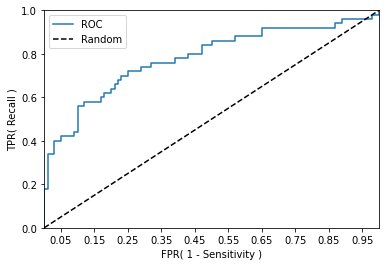



11      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.7806000000000001

#12 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

12 검증 세트 인덱스:144     188
145     375
146     353
148      91
149     519
       ... 
302    1255
310    1497
314    1209
315    1339
317    1449
Name: Unnamed: 0, Length: 150, dtype: int64


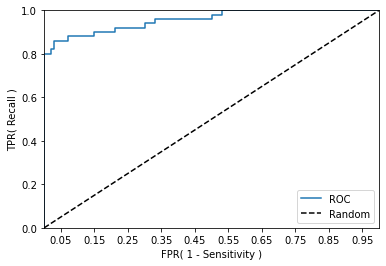



12      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9566000000000001

#13 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

13 검증 세트 인덱스:288     344
291      99
293     819
297     331
298     540
       ... 
450    1268
451    1230
456    1046
457    1009
461    1182
Name: Unnamed: 0, Length: 150, dtype: int64


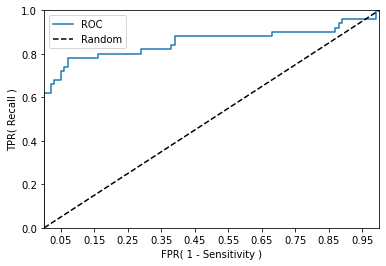



13      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.8544

#14 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

14 검증 세트 인덱스:443     614
444     933
445     151
447     992
449     890
       ... 
610    1415
611    1167
614    1468
616    1099
621    1443
Name: Unnamed: 0, Length: 150, dtype: int64


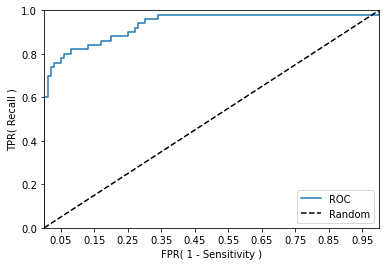



14      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9349999999999999

#15 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

15 검증 세트 인덱스:587     454
588     291
590     988
591     522
596     889
       ... 
747    1206
753    1074
754    1392
756    1115
759    1026
Name: Unnamed: 0, Length: 150, dtype: int64


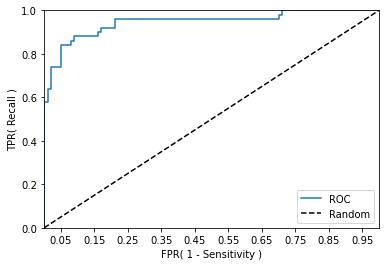



15      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9458

#16 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

16 검증 세트 인덱스:745     113
746     802
748     690
749     200
750      18
       ... 
895     945
898    1008
900    1275
903    1296
904    1279
Name: Unnamed: 0, Length: 150, dtype: int64


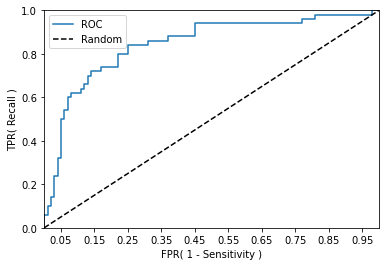



16      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.8444

#17 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

17 검증 세트 인덱스:896       0
897     520
899     176
901     441
902     800
       ... 
1057    888
1059     88
1060     10
1061    545
1065    869
Name: Unnamed: 0, Length: 150, dtype: int64


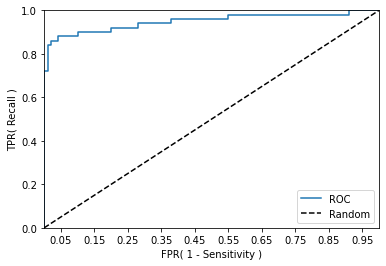



17      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9492

#18 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

18 검증 세트 인덱스:1032    1385
1034    1100
1038    1050
1039    1456
1041    1090
        ... 
1204     851
1207     983
1208     715
1212       5
1213     941
Name: Unnamed: 0, Length: 150, dtype: int64


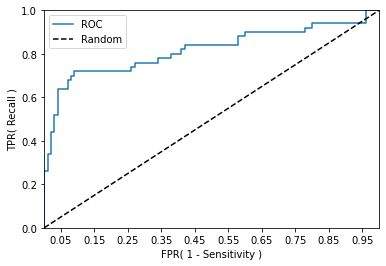



18      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.8177999999999999

#19 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

19 검증 세트 인덱스:1178    1288
1185    1143
1186    1336
1188    1322
1193    1124
        ... 
1346     806
1347      13
1348     632
1352     243
1353     214
Name: Unnamed: 0, Length: 150, dtype: int64


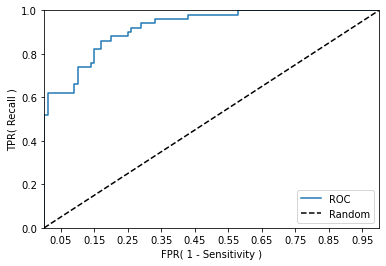



19      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.922

#20 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

20 검증 세트 인덱스:1343    1302
1349    1065
1350    1378
1351    1106
1354     267
        ... 
1495    1146
1496    1169
1497     383
1498     107
1499    1059
Name: Unnamed: 0, Length: 150, dtype: int64


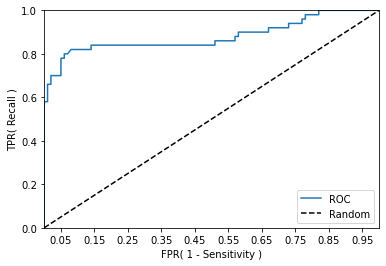



20      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.8803000000000001
================================================skfold 3 번째================================================

#21 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

21 검증 세트 인덱스:0       520
1       649
2      1051
3       472
4       139
       ... 
145      37
148    1252
149    1494
152    1124
158    1425
Name: Unnamed: 0, Length: 150, dtype: int64


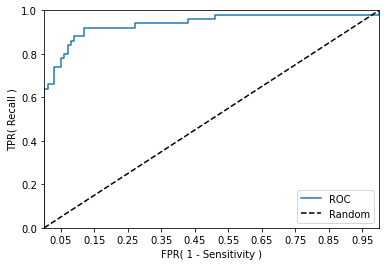



21      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9390000000000001

#22 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

22 검증 세트 인덱스:146     984
147       3
150     163
151     133
153     675
       ... 
295     110
296    1375
297     600
301     347
303     524
Name: Unnamed: 0, Length: 150, dtype: int64


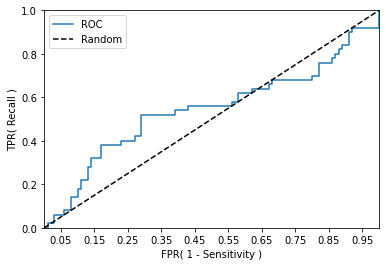



22      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.5432

#23 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

23 검증 세트 인덱스:298    1199
299    1267
300    1339
302    1179
304       4
       ... 
445    1183
446     900
447     626
448      69
449    1313
Name: Unnamed: 0, Length: 150, dtype: int64


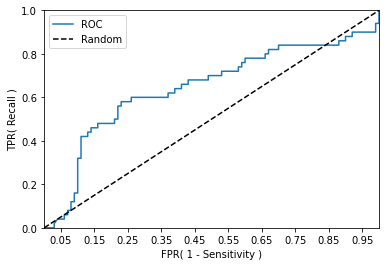



23      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.6445000000000001

#24 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

24 검증 세트 인덱스:450     981
451     766
452      90
453    1437
454     336
       ... 
596      16
597     246
599     376
602     118
603     273
Name: Unnamed: 0, Length: 150, dtype: int64


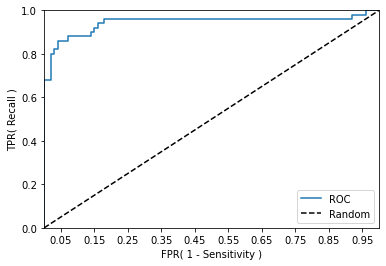



24      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9437999999999999

#25 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

25 검증 세트 인덱스:594    1366
598    1013
600    1434
601    1206
604    1254
       ... 
745     244
746     412
749     669
750     211
751     288
Name: Unnamed: 0, Length: 150, dtype: int64


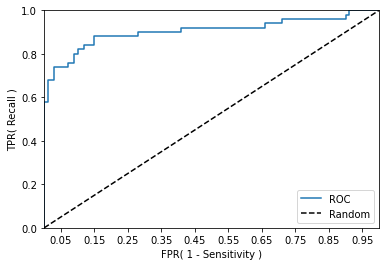



25      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9044

#26 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

26 검증 세트 인덱스:747    1204
748    1363
752    1160
753    1148
754     954
       ... 
896     610
897     471
900     210
902     565
903     872
Name: Unnamed: 0, Length: 150, dtype: int64


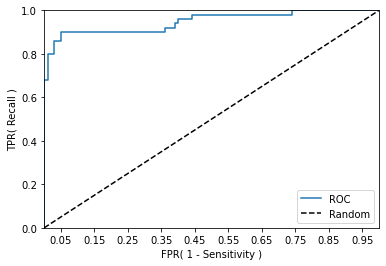



26      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.9484000000000001

#27 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

27 검증 세트 인덱스:893     1432
898     1376
899     1161
901     1057
904      484
        ... 
1045    1003
1046     309
1047    1180
1058    1157
1059    1220
Name: Unnamed: 0, Length: 150, dtype: int64


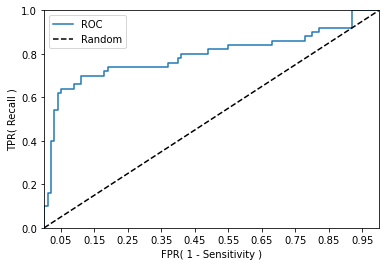



27      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.793

#28 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

28 검증 세트 인덱스:1048     688
1049     402
1050      79
1051      47
1052     554
        ... 
1206    1028
1209    1401
1211    1482
1212    1355
1217    1492
Name: Unnamed: 0, Length: 150, dtype: int64


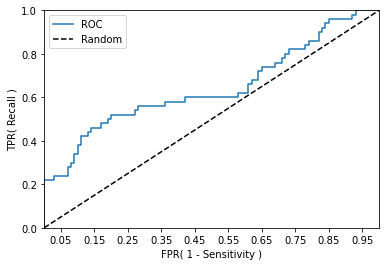



28      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.6442

#29 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

29 검증 세트 인덱스:1190     153
1191     219
1193      89
1194     325
1195     379
        ... 
1345    1470
1347    1412
1349    1147
1350    1079
1352    1222
Name: Unnamed: 0, Length: 150, dtype: int64


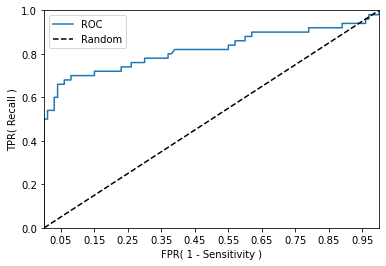



29      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.8197

#30 교차 검증 정확도 :0.6667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150

30 검증 세트 인덱스:1346     234
1348     443
1351     816
1353     630
1354     571
        ... 
1495    1176
1496     340
1497     116
1498     641
1499    1377
Name: Unnamed: 0, Length: 150, dtype: int64


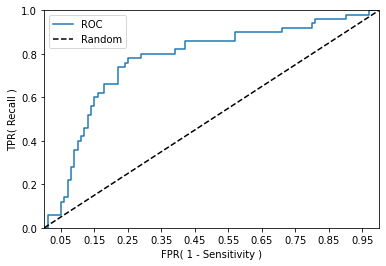



30      예측0  예측1
실제0  100    0
실제1   50    0 
 acc: 0.6667 auc: 0.7724000000000001
================================================종료================================================

## 교차 검증별 acc: [0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667
 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667
 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667 0.6667]

## 교차 검증별 auc: [0.8362 0.869  0.8516 0.3928 0.907  0.9518 0.8412 0.9286 0.5864 0.7063
 0.7806 0.9566 0.8544 0.935  0.9458 0.8444 0.9492 0.8178 0.922  0.8803
 0.939  0.5432 0.6445 0.9438 0.9044 0.9484 0.793  0.6442 0.8197 0.7724]

## 평균 검증 정확도: 0.6666999999999997

## 평균 검증 auc: 0.8236533333333333
          fold_0            fold_1            fold_2            fold_3  \
             예측0     예측1       예측0     예측1       예측0     예측1       예측0   
실제0     100.0000  0.0000  100.0000  0.0000  100.0000  0.0000  100.0000   
실제1      50.0000  0.0000   50.0000  0.0000   50.0000  0.0000   50.

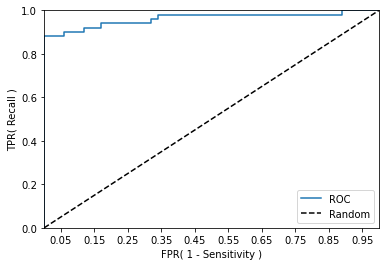



1      예측0  예측1
실제0   94    6
실제1    6   44 
 acc: 0.92 auc: 0.9620000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.052496296296296374
            Iterations: 8
            Function evaluations: 189
            Gradient evaluations: 8

#2 교차 검증 정확도 :0.8867, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#2 검증 세트 인덱스:100      100
101      101
102      102
103      103
104      104
        ... 
1095    1095
1096    1096
1097    1097
1098    1098
1099    1099
Name: Unnamed: 0, Length: 150, dtype: int64


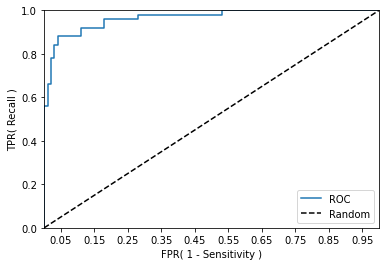



2      예측0  예측1
실제0   89   11
실제1    6   44 
 acc: 0.8867 auc: 0.9654
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0771456790123457
            Iterations: 9
            Function evaluations: 216
            Gradient evaluations: 9

#3 교차 검증 정확도 :0.8267, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#3 검증 세트 인덱스:200      200
201      201
202      202
203      203
204      204
        ... 
1145    1145
1146    1146
1147    1147
1148    1148
1149    1149
Name: Unnamed: 0, Length: 150, dtype: int64


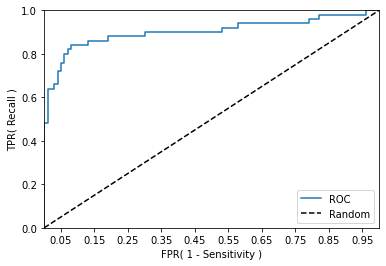



3      예측0  예측1
실제0   80   20
실제1    6   44 
 acc: 0.8267 auc: 0.902
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.051392592592592545
            Iterations: 16
            Function evaluations: 361
            Gradient evaluations: 15

#4 교차 검증 정확도 :0.8467, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#4 검증 세트 인덱스:300      300
301      301
302      302
303      303
304      304
        ... 
1195    1195
1196    1196
1197    1197
1198    1198
1199    1199
Name: Unnamed: 0, Length: 150, dtype: int64


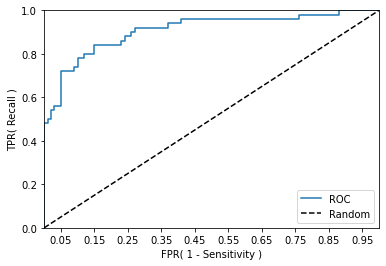



4      예측0  예측1
실제0   87   13
실제1   10   40 
 acc: 0.8467 auc: 0.9078
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05153827160493818
            Iterations: 7
            Function evaluations: 164
            Gradient evaluations: 7

#5 교차 검증 정확도 :0.8867, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#5 검증 세트 인덱스:400      400
401      401
402      402
403      403
404      404
        ... 
1245    1245
1246    1246
1247    1247
1248    1248
1249    1249
Name: Unnamed: 0, Length: 150, dtype: int64


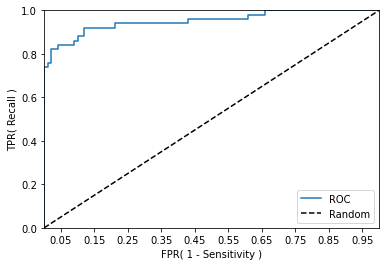



5      예측0  예측1
실제0   90   10
실제1    7   43 
 acc: 0.8867 auc: 0.951
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05370617283950607
            Iterations: 17
            Function evaluations: 383
            Gradient evaluations: 16

#6 교차 검증 정확도 :0.8467, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#6 검증 세트 인덱스:500      500
501      501
502      502
503      503
504      504
        ... 
1295    1295
1296    1296
1297    1297
1298    1298
1299    1299
Name: Unnamed: 0, Length: 150, dtype: int64


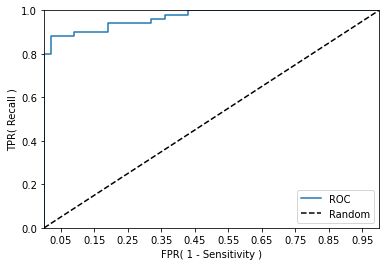



6      예측0  예측1
실제0   82   18
실제1    5   45 
 acc: 0.8467 auc: 0.9668000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.067869135802469
            Iterations: 17
            Function evaluations: 399
            Gradient evaluations: 17

#7 교차 검증 정확도 :0.8867, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#7 검증 세트 인덱스:600      600
601      601
602      602
603      603
604      604
        ... 
1345    1345
1346    1346
1347    1347
1348    1348
1349    1349
Name: Unnamed: 0, Length: 150, dtype: int64


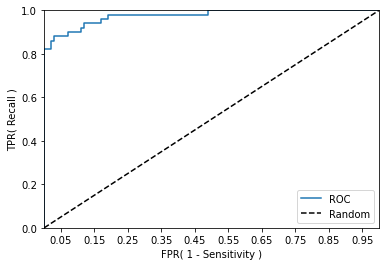



7      예측0  예측1
실제0   86   14
실제1    3   47 
 acc: 0.8867 auc: 0.9756
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05490617283950616
            Iterations: 14
            Function evaluations: 377
            Gradient evaluations: 14

#8 교차 검증 정확도 :0.8133, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#8 검증 세트 인덱스:700      700
701      701
702      702
703      703
704      704
        ... 
1395    1395
1396    1396
1397    1397
1398    1398
1399    1399
Name: Unnamed: 0, Length: 150, dtype: int64


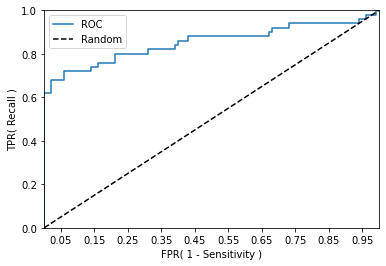



8      예측0  예측1
실제0   86   14
실제1   14   36 
 acc: 0.8133 auc: 0.8520000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05640493827160509
            Iterations: 17
            Function evaluations: 391
            Gradient evaluations: 16

#9 교차 검증 정확도 :0.86, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#9 검증 세트 인덱스:800      800
801      801
802      802
803      803
804      804
        ... 
1445    1445
1446    1446
1447    1447
1448    1448
1449    1449
Name: Unnamed: 0, Length: 150, dtype: int64


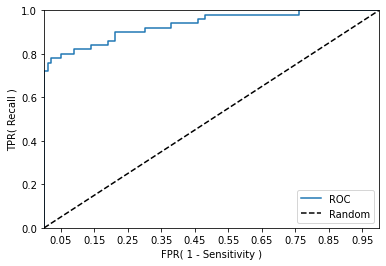



9      예측0  예측1
실제0   88   12
실제1    9   41 
 acc: 0.86 auc: 0.9338
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05822469135802466
            Iterations: 16
            Function evaluations: 393
            Gradient evaluations: 16

#10 교차 검증 정확도 :0.8667, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#10 검증 세트 인덱스:900      900
901      901
902      902
903      903
904      904
        ... 
1495    1495
1496    1496
1497    1497
1498    1498
1499    1499
Name: Unnamed: 0, Length: 150, dtype: int64


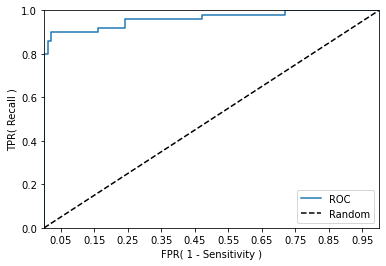



10      예측0  예측1
실제0   84   16
실제1    4   46 
 acc: 0.8667 auc: 0.962
================================================ 1 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05990617283950617
            Iterations: 16
            Function evaluations: 371
            Gradient evaluations: 16

#11 교차 검증 정확도 :0.8733, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#11 검증 세트 인덱스:0          0
1          1
2          2
3          3
4          4
        ... 
1045    1045
1046    1046
1047    1047
1048    1048
1049    1049
Name: Unnamed: 0, Length: 150, dtype: int64


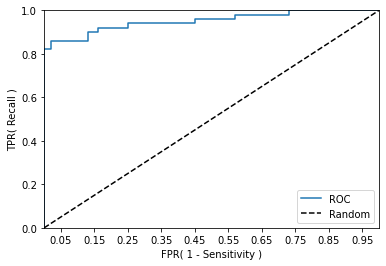



11      예측0  예측1
실제0   87   13
실제1    6   44 
 acc: 0.8733 auc: 0.9508
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.059748148148148106
            Iterations: 22
            Function evaluations: 493
            Gradient evaluations: 22

#12 교차 검증 정확도 :0.8867, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#12 검증 세트 인덱스:100      100
101      101
102      102
103      103
104      104
        ... 
1095    1095
1096    1096
1097    1097
1098    1098
1099    1099
Name: Unnamed: 0, Length: 150, dtype: int64


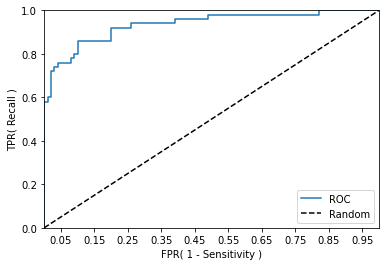



12      예측0  예측1
실제0   90   10
실제1    7   43 
 acc: 0.8867 auc: 0.9354
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05697037037037023
            Iterations: 5
            Function evaluations: 116
            Gradient evaluations: 5

#13 교차 검증 정확도 :0.86, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#13 검증 세트 인덱스:200      200
201      201
202      202
203      203
204      204
        ... 
1145    1145
1146    1146
1147    1147
1148    1148
1149    1149
Name: Unnamed: 0, Length: 150, dtype: int64


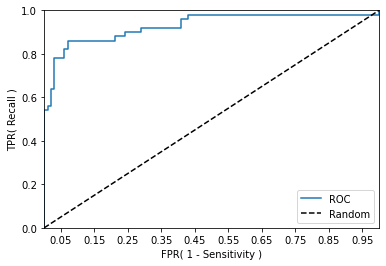



13      예측0  예측1
실제0   86   14
실제1    7   43 
 acc: 0.86 auc: 0.9290000000000002
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05354567901234564
            Iterations: 6
            Function evaluations: 165
            Gradient evaluations: 6

#14 교차 검증 정확도 :0.8467, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#14 검증 세트 인덱스:300      300
301      301
302      302
303      303
304      304
        ... 
1195    1195
1196    1196
1197    1197
1198    1198
1199    1199
Name: Unnamed: 0, Length: 150, dtype: int64


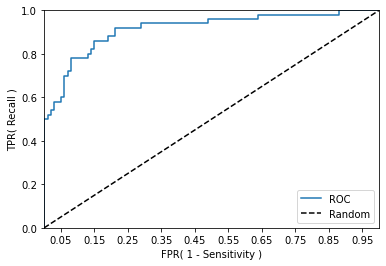



14      예측0  예측1
실제0   88   12
실제1   11   39 
 acc: 0.8467 auc: 0.9154
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05748148148148158
            Iterations: 21
            Function evaluations: 530
            Gradient evaluations: 21

#15 교차 검증 정확도 :0.9133, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#15 검증 세트 인덱스:400      400
401      401
402      402
403      403
404      404
        ... 
1245    1245
1246    1246
1247    1247
1248    1248
1249    1249
Name: Unnamed: 0, Length: 150, dtype: int64


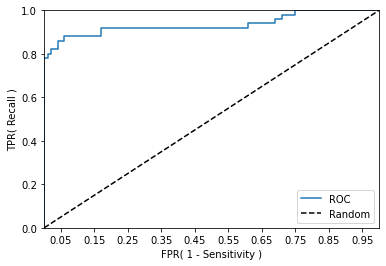



15      예측0  예측1
실제0   94    6
실제1    7   43 
 acc: 0.9133 auc: 0.9346
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04901728395061733
            Iterations: 49
            Function evaluations: 1199
            Gradient evaluations: 45

#16 교차 검증 정확도 :0.8867, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#16 검증 세트 인덱스:500      500
501      501
502      502
503      503
504      504
        ... 
1295    1295
1296    1296
1297    1297
1298    1298
1299    1299
Name: Unnamed: 0, Length: 150, dtype: int64


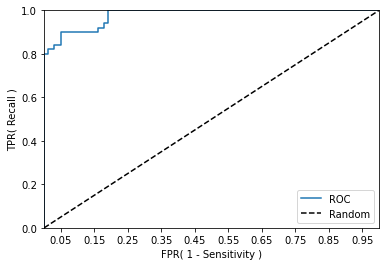



16      예측0  예측1
실제0   88   12
실제1    5   45 
 acc: 0.8867 auc: 0.9780000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07106419753086435
            Iterations: 21
            Function evaluations: 457
            Gradient evaluations: 20

#17 교차 검증 정확도 :0.8933, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#17 검증 세트 인덱스:600      600
601      601
602      602
603      603
604      604
        ... 
1345    1345
1346    1346
1347    1347
1348    1348
1349    1349
Name: Unnamed: 0, Length: 150, dtype: int64


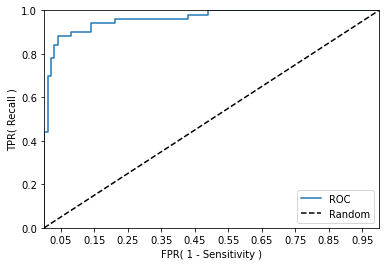



17      예측0  예측1
실제0   89   11
실제1    5   45 
 acc: 0.8933 auc: 0.9626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04628641975308634
            Iterations: 13
            Function evaluations: 294
            Gradient evaluations: 13

#18 교차 검증 정확도 :0.8333, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#18 검증 세트 인덱스:700      700
701      701
702      702
703      703
704      704
        ... 
1395    1395
1396    1396
1397    1397
1398    1398
1399    1399
Name: Unnamed: 0, Length: 150, dtype: int64


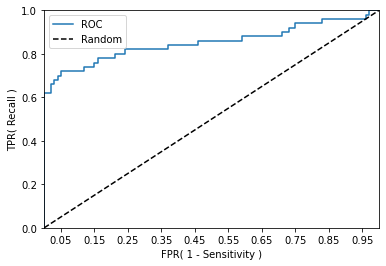



18      예측0  예측1
실제0   88   12
실제1   13   37 
 acc: 0.8333 auc: 0.8518
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05753580246913581
            Iterations: 6
            Function evaluations: 166
            Gradient evaluations: 6

#19 교차 검증 정확도 :0.9, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#19 검증 세트 인덱스:800      800
801      801
802      802
803      803
804      804
        ... 
1445    1445
1446    1446
1447    1447
1448    1448
1449    1449
Name: Unnamed: 0, Length: 150, dtype: int64


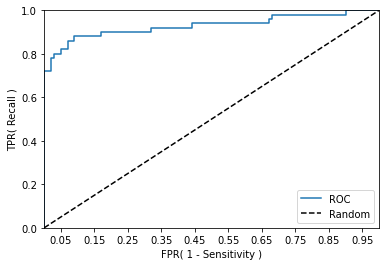



19      예측0  예측1
실제0   91    9
실제1    6   44 
 acc: 0.9 auc: 0.929
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05372098765432087
            Iterations: 9
            Function evaluations: 234
            Gradient evaluations: 9

#20 교차 검증 정확도 :0.8533, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#20 검증 세트 인덱스:900      900
901      901
902      902
903      903
904      904
        ... 
1495    1495
1496    1496
1497    1497
1498    1498
1499    1499
Name: Unnamed: 0, Length: 150, dtype: int64


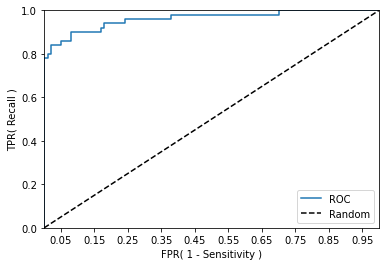



20      예측0  예측1
실제0   83   17
실제1    5   45 
 acc: 0.8533 auc: 0.9614
================================================ 2 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05495308641975305
            Iterations: 11
            Function evaluations: 260
            Gradient evaluations: 11

#21 교차 검증 정확도 :0.9133, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#21 검증 세트 인덱스:0          0
1          1
2          2
3          3
4          4
        ... 
1045    1045
1046    1046
1047    1047
1048    1048
1049    1049
Name: Unnamed: 0, Length: 150, dtype: int64


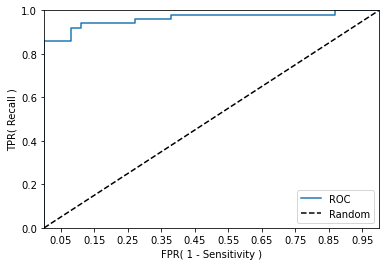



21      예측0  예측1
실제0   92    8
실제1    5   45 
 acc: 0.9133 auc: 0.9626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07314320987654321
            Iterations: 16
            Function evaluations: 355
            Gradient evaluations: 16

#22 교차 검증 정확도 :0.8733, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#22 검증 세트 인덱스:100      100
101      101
102      102
103      103
104      104
        ... 
1095    1095
1096    1096
1097    1097
1098    1098
1099    1099
Name: Unnamed: 0, Length: 150, dtype: int64


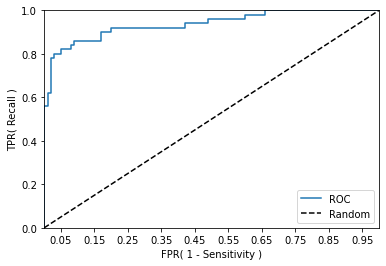



22      예측0  예측1
실제0   88   12
실제1    7   43 
 acc: 0.8733 auc: 0.937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05156790123456789
            Iterations: 13
            Function evaluations: 286
            Gradient evaluations: 12

#23 교차 검증 정확도 :0.8733, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#23 검증 세트 인덱스:200      200
201      201
202      202
203      203
204      204
        ... 
1145    1145
1146    1146
1147    1147
1148    1148
1149    1149
Name: Unnamed: 0, Length: 150, dtype: int64


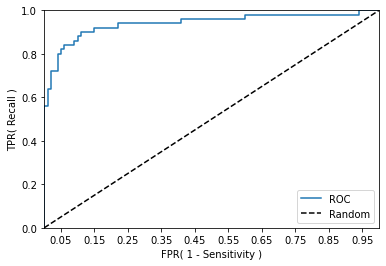



23      예측0  예측1
실제0   86   14
실제1    5   45 
 acc: 0.8733 auc: 0.9398
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04971604938271612
            Iterations: 4
            Function evaluations: 101
            Gradient evaluations: 4

#24 교차 검증 정확도 :0.8267, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#24 검증 세트 인덱스:300      300
301      301
302      302
303      303
304      304
        ... 
1195    1195
1196    1196
1197    1197
1198    1198
1199    1199
Name: Unnamed: 0, Length: 150, dtype: int64


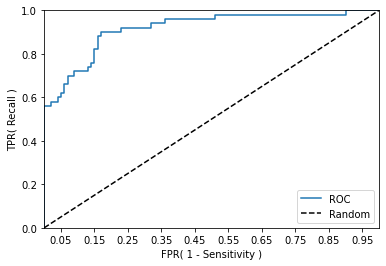



24      예측0  예측1
실제0   88   12
실제1   14   36 
 acc: 0.8267 auc: 0.9169999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04754814814814812
            Iterations: 6
            Function evaluations: 142
            Gradient evaluations: 6

#25 교차 검증 정확도 :0.9, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#25 검증 세트 인덱스:400      400
401      401
402      402
403      403
404      404
        ... 
1245    1245
1246    1246
1247    1247
1248    1248
1249    1249
Name: Unnamed: 0, Length: 150, dtype: int64


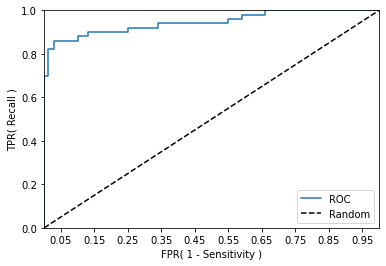



25      예측0  예측1
실제0   92    8
실제1    7   43 
 acc: 0.9 auc: 0.9452
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05146666666666666
            Iterations: 19
            Function evaluations: 426
            Gradient evaluations: 18

#26 교차 검증 정확도 :0.8533, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#26 검증 세트 인덱스:500      500
501      501
502      502
503      503
504      504
        ... 
1295    1295
1296    1296
1297    1297
1298    1298
1299    1299
Name: Unnamed: 0, Length: 150, dtype: int64


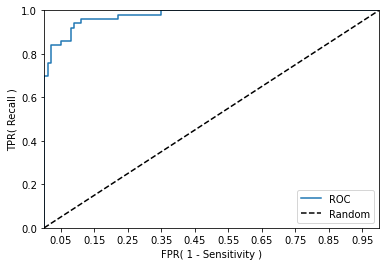



26      예측0  예측1
실제0   80   20
실제1    2   48 
 acc: 0.8533 auc: 0.9766
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.055553086419753095
            Iterations: 10
            Function evaluations: 222
            Gradient evaluations: 10

#27 교차 검증 정확도 :0.9267, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#27 검증 세트 인덱스:600      600
601      601
602      602
603      603
604      604
        ... 
1345    1345
1346    1346
1347    1347
1348    1348
1349    1349
Name: Unnamed: 0, Length: 150, dtype: int64


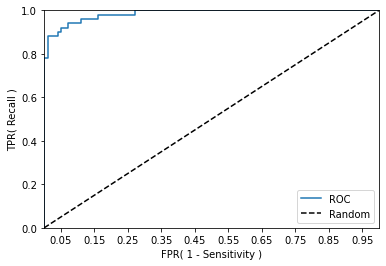



27      예측0  예측1
실제0   92    8
실제1    3   47 
 acc: 0.9267 auc: 0.985
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05549629629629649
            Iterations: 18
            Function evaluations: 459
            Gradient evaluations: 16

#28 교차 검증 정확도 :0.8067, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#28 검증 세트 인덱스:700      700
701      701
702      702
703      703
704      704
        ... 
1395    1395
1396    1396
1397    1397
1398    1398
1399    1399
Name: Unnamed: 0, Length: 150, dtype: int64


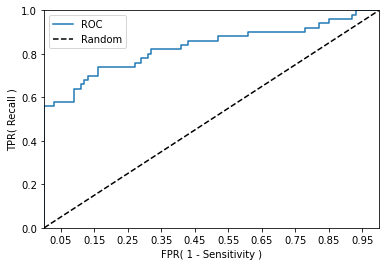



28      예측0  예측1
실제0   87   13
실제1   16   34 
 acc: 0.8067 auc: 0.8312
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.056261728395061716
            Iterations: 8
            Function evaluations: 239
            Gradient evaluations: 8

#29 교차 검증 정확도 :0.9, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#29 검증 세트 인덱스:800      800
801      801
802      802
803      803
804      804
        ... 
1445    1445
1446    1446
1447    1447
1448    1448
1449    1449
Name: Unnamed: 0, Length: 150, dtype: int64


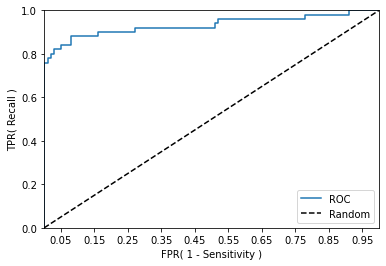



29      예측0  예측1
실제0   91    9
실제1    6   44 
 acc: 0.9 auc: 0.9316
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0490049382716049
            Iterations: 27
            Function evaluations: 660
            Gradient evaluations: 25

#30 교차 검증 정확도 :0.8733, 학습 데이터 크기: 1350, 검증 데이터 크기: 150
#30 검증 세트 인덱스:900      900
901      901
902      902
903      903
904      904
        ... 
1495    1495
1496    1496
1497    1497
1498    1498
1499    1499
Name: Unnamed: 0, Length: 150, dtype: int64


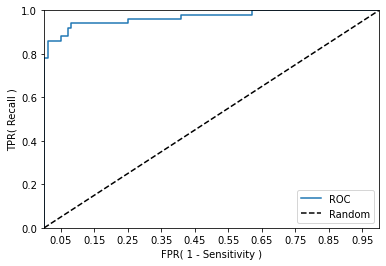



30      예측0  예측1
실제0   84   16
실제1    3   47 
 acc: 0.8733 auc: 0.9682
================================================종료================================================

## 교차 검증별 acc: [0.92   0.8867 0.8267 0.8467 0.8867 0.8467 0.8867 0.8133 0.86   0.8667
 0.8733 0.8867 0.86   0.8467 0.9133 0.8867 0.8933 0.8333 0.9    0.8533
 0.9133 0.8733 0.8733 0.8267 0.9    0.8533 0.9267 0.8067 0.9    0.8733]

## 교차 검증별 auc: [0.962  0.9654 0.902  0.9078 0.951  0.9668 0.9756 0.852  0.9338 0.962
 0.9508 0.9354 0.929  0.9154 0.9346 0.978  0.9626 0.8518 0.929  0.9614
 0.9626 0.937  0.9398 0.917  0.9452 0.9766 0.985  0.8312 0.9316 0.9682]
## 평균 검증 정확도: 0.8711133333333333
## 평균 검증 auc: 0.9373533333333334
       fold_0            fold_1            fold_2            fold_3           \
          예측0      예측1      예측0      예측1      예측0      예측1      예측0      예측1   
실제0     94.00   6.0000  89.0000  11.0000  80.0000  20.0000  87.0000  13.0000   
실제1      6.00  44.0000   6.0000  44.0000   6.0000  44.0000  10.

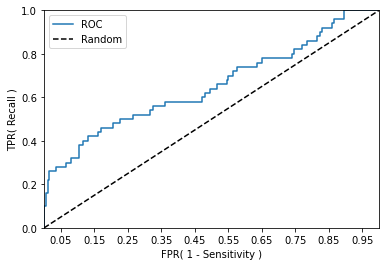



1      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.6531

#2 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

2 검증 세트 인덱스:215    2044
220    2152
227    2178
231    2005
235    2490
       ... 
500    1055
501     614
502     814
503     704
505      59
Name: Unnamed: 0, Length: 250, dtype: int64


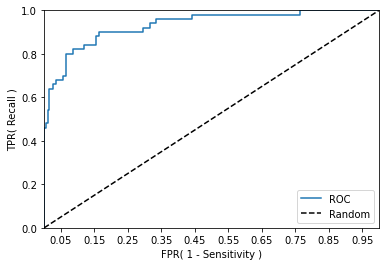



2      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.9324

#3 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

3 검증 세트 인덱스:485    2250
487    2402
492    2072
494    2016
496    2224
       ... 
745    2247
749    2338
752    2026
754    2122
755    2249
Name: Unnamed: 0, Length: 250, dtype: int64


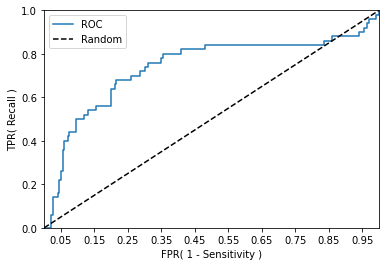



3      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.7368999999999999

#4 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

4 검증 세트 인덱스:746     1568
747      688
748     1650
750      551
751     1787
        ... 
995     1161
996     2380
997     1298
998     2434
1006    2353
Name: Unnamed: 0, Length: 250, dtype: int64


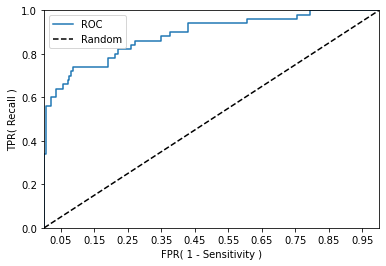



4      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8878

#5 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

5 검증 세트 인덱스:999      726
1000     111
1001    1854
1002    1079
1003    1366
        ... 
1252    2486
1256    2411
1260    2129
1262    2355
1264    2067
Name: Unnamed: 0, Length: 250, dtype: int64


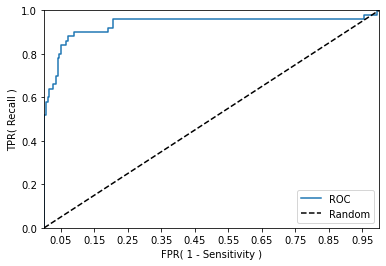



5      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.9354

#6 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

6 검증 세트 인덱스:1245    1345
1246      93
1247     930
1248    1677
1249    1507
        ... 
1495    2185
1496    2172
1497    1155
1499    2052
1500    2302
Name: Unnamed: 0, Length: 250, dtype: int64


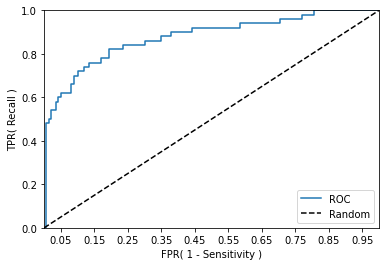



6      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8767999999999999

#7 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

7 검증 세트 인덱스:1498    1846
1501    1133
1502     334
1503    2368
1504    1822
        ... 
1745    1066
1746     729
1750    2164
1753    2308
1755    2352
Name: Unnamed: 0, Length: 250, dtype: int64


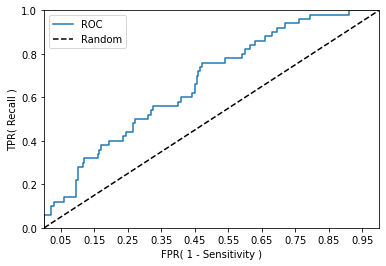



7      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.6676

#8 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

8 검증 세트 인덱스:1747    1246
1748    1242
1749    1409
1751    1598
1752    1829
        ... 
2001     578
2002     109
2003     187
2004    1346
2005    1857
Name: Unnamed: 0, Length: 250, dtype: int64


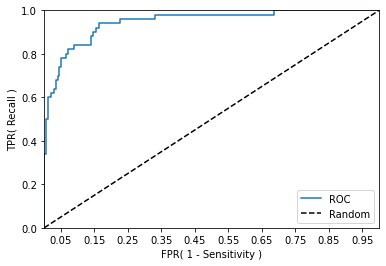



8      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.9470000000000001

#9 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

9 검증 세트 인덱스:1982    2133
1985    2248
1987    2313
1989    2435
1992    2330
        ... 
2245     136
2246    1442
2247    1866
2248     832
2249     896
Name: Unnamed: 0, Length: 250, dtype: int64


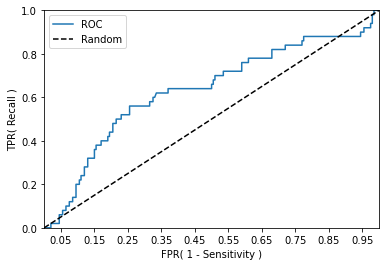



9      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.63215

#10 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

10 검증 세트 인덱스:2250    1922
2251    1042
2252    1373
2253    1005
2254    1619
        ... 
2495    1643
2496    1054
2497    2297
2498      72
2499      84
Name: Unnamed: 0, Length: 250, dtype: int64


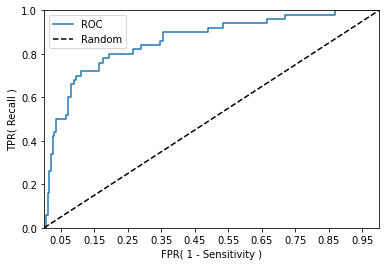



10      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8615
================================================skfold 2 번째================================================

#11 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

11 검증 세트 인덱스:0        31
1      1068
2       750
3      1918
4      1112
       ... 
258    1309
260     450
261    1898
262     108
263    1274
Name: Unnamed: 0, Length: 250, dtype: int64


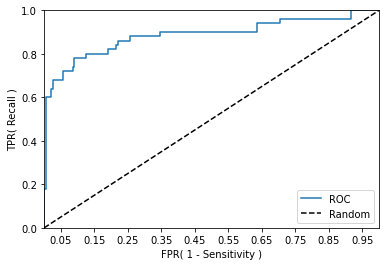



11      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8855

#12 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

12 검증 세트 인덱스:208    2417
210    2452
217    2191
229    2101
231    2148
       ... 
511    1876
512     171
513     280
514     831
518     232
Name: Unnamed: 0, Length: 250, dtype: int64


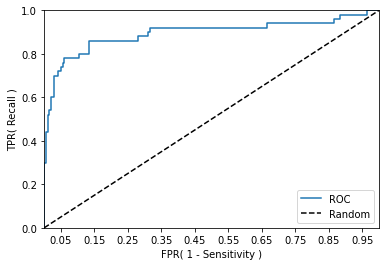



12      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.894

#13 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

13 검증 세트 인덱스:449    2208
452    2126
456    2133
460    2478
463    2407
       ... 
760     492
761     650
762    1773
765    1423
768    1754
Name: Unnamed: 0, Length: 250, dtype: int64


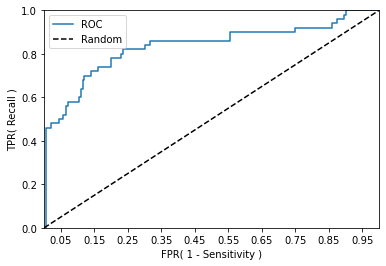



13      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8343999999999999

#14 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

14 검증 세트 인덱스:664     2243
672     2127
681     2205
683     2300
688     2334
        ... 
1021    1022
1022     735
1023    1424
1024     127
1025    1863
Name: Unnamed: 0, Length: 250, dtype: int64


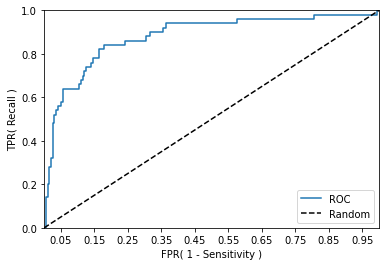



14      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8792

#15 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

15 검증 세트 인덱스:923     2044
924     2388
926     2097
930     2043
932     2322
        ... 
1265    1006
1266    1746
1268    1824
1270     903
1271    1738
Name: Unnamed: 0, Length: 250, dtype: int64


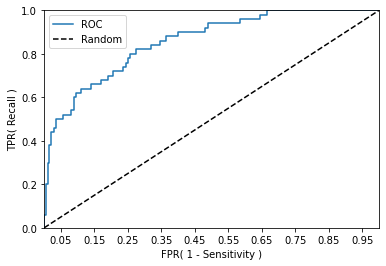



15      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8565

#16 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

16 검증 세트 인덱스:1154    2414
1157    2302
1170    2176
1173    2367
1177    2217
        ... 
1523    1233
1524    1959
1525      88
1526    1222
1527     964
Name: Unnamed: 0, Length: 250, dtype: int64


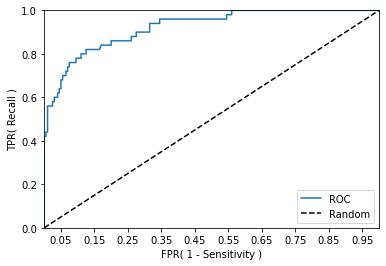



16      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.92235

#17 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

17 검증 세트 인덱스:1413    2003
1417    2280
1424    2166
1426    2430
1429    2093
        ... 
1773     131
1774    1996
1775    1568
1778    1607
1780    1604
Name: Unnamed: 0, Length: 250, dtype: int64


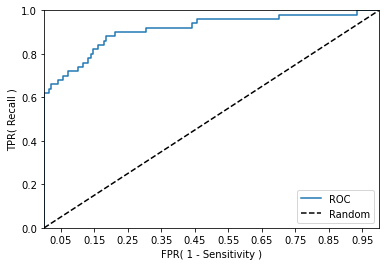



17      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.9120000000000001

#18 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

18 검증 세트 인덱스:1637    2175
1641    2458
1648    2123
1649    2065
1651    2285
        ... 
2010     913
2011    1581
2012     229
2013     826
2014     636
Name: Unnamed: 0, Length: 250, dtype: int64


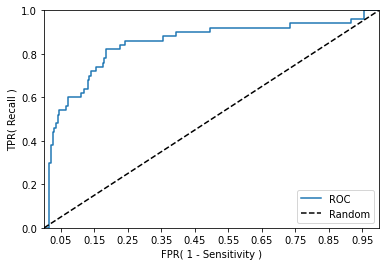



18      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8462

#19 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

19 검증 세트 인덱스:1931    2282
1932    2319
1934    2199
1936    2304
1937    2275
        ... 
2251     408
2252     526
2253    1551
2254     335
2257    1797
Name: Unnamed: 0, Length: 250, dtype: int64


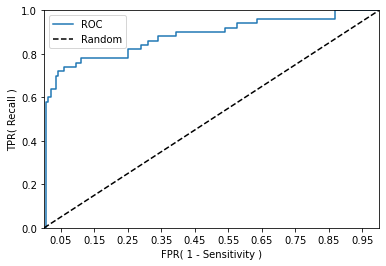



19      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8814000000000001

#20 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

20 검증 세트 인덱스:2215    2172
2224    2491
2228    2236
2232    2138
2234    2471
        ... 
2495    1740
2496    1546
2497    1114
2498    2237
2499    1632
Name: Unnamed: 0, Length: 250, dtype: int64


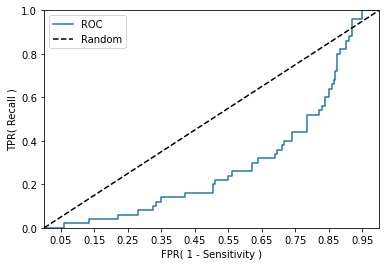



20      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.2953
================================================skfold 3 번째================================================

#21 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

21 검증 세트 인덱스:0      2057
1        66
2         9
3      1453
4      2347
       ... 
251     802
252    1932
253     451
254    1940
255    1781
Name: Unnamed: 0, Length: 250, dtype: int64


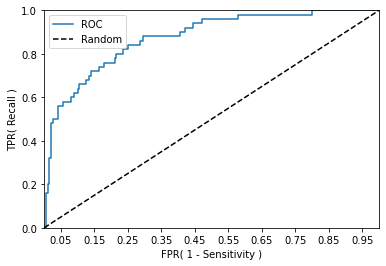



21      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8752

#22 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

22 검증 세트 인덱스:234    2206
236    2377
237    2139
241    2483
242    2214
       ... 
495    1534
496    2043
497    1094
498     826
501    2373
Name: Unnamed: 0, Length: 250, dtype: int64


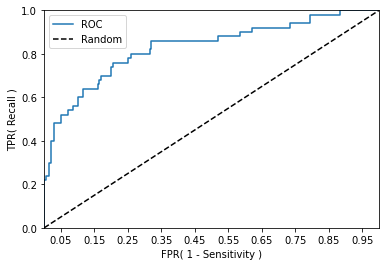



22      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8309000000000001

#23 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

23 검증 세트 인덱스:499    1740
500     186
502     158
503    1858
504    1863
       ... 
745    2370
746     526
747    1163
748     834
750    2474
Name: Unnamed: 0, Length: 250, dtype: int64


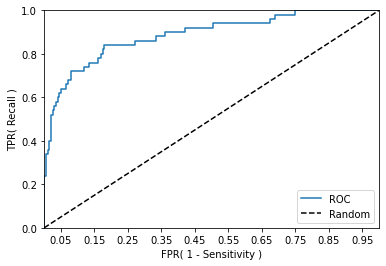



23      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8869999999999999

#24 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

24 검증 세트 인덱스:749      995
751      878
752     1125
753      631
754     1501
        ... 
1001    2269
1006    2181
1007    2321
1027    2307
1033    2305
Name: Unnamed: 0, Length: 250, dtype: int64


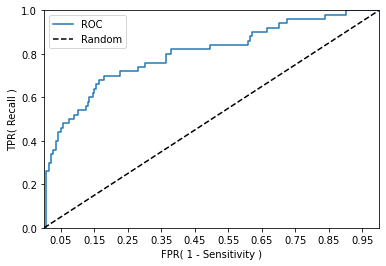



24      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.801

#25 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

25 검증 세트 인덱스:994     1950
995      986
996     1200
997     1698
999      722
        ... 
1245    1128
1246     824
1247    2367
1249    2021
1252    2179
Name: Unnamed: 0, Length: 250, dtype: int64


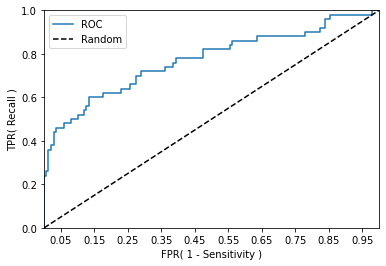



25      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.7717

#26 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

26 검증 세트 인덱스:1248     357
1250    1887
1251     417
1253    2448
1254     853
        ... 
1495    1800
1496     879
1499    2268
1504    2188
1506    2077
Name: Unnamed: 0, Length: 250, dtype: int64


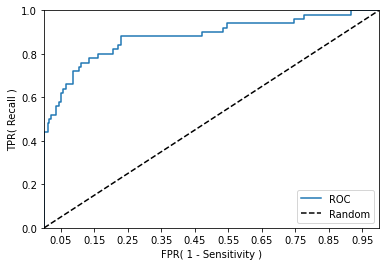



26      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8795

#27 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

27 검증 세트 인덱스:1497    1202
1498     883
1500     542
1501     571
1502    1707
        ... 
1745    1668
1746    1536
1750    2469
1751    2141
1752    2329
Name: Unnamed: 0, Length: 250, dtype: int64


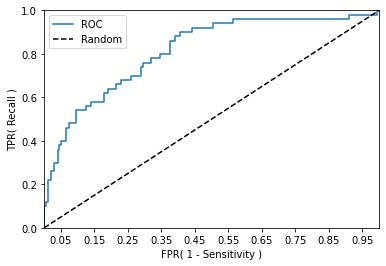



27      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8135999999999999

#28 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

28 검증 세트 인덱스:1747     880
1748     384
1749     783
1753     734
1754    1923
        ... 
2051    2200
2052    2477
2057    2103
2058    2184
2065    2115
Name: Unnamed: 0, Length: 250, dtype: int64


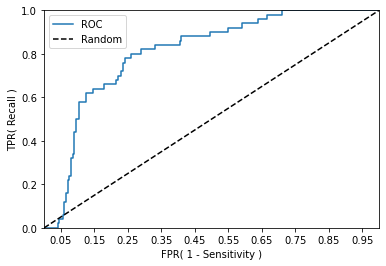



28      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.8082

#29 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

29 검증 세트 인덱스:1987    1013
1989    1755
1990     623
1991     926
1992     956
        ... 
2255    2183
2256    2359
2257    2130
2269    2264
2272    2147
Name: Unnamed: 0, Length: 250, dtype: int64


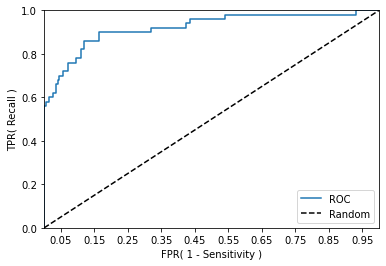



29      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.9214

#30 교차 검증 정확도 :0.8, 학습 데이터 크기: 2250, 검증 데이터 크기: 250

30 검증 세트 인덱스:2240    1082
2241    1960
2242    1724
2243     760
2244    1497
        ... 
2495     902
2496     245
2497     213
2498     670
2499    2197
Name: Unnamed: 0, Length: 250, dtype: int64


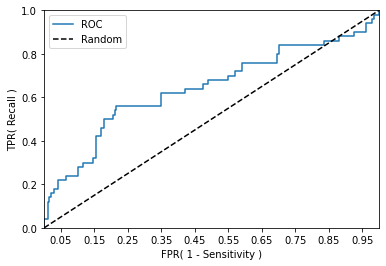



30      예측0  예측1
실제0  200    0
실제1   50    0 
 acc: 0.8 auc: 0.6427
================================================종료================================================

## 교차 검증별 acc: [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]

## 교차 검증별 auc: [0.6531 0.9324 0.7369 0.8878 0.9354 0.8768 0.6676 0.947  0.6322 0.8615
 0.8855 0.894  0.8344 0.8792 0.8565 0.9224 0.912  0.8462 0.8814 0.2953
 0.8752 0.8309 0.887  0.801  0.7717 0.8795 0.8136 0.8082 0.9214 0.6427]

## 평균 검증 정확도: 0.8000000000000003

## 평균 검증 auc: 0.8189566666666667
       fold_0      fold_1      fold_2      fold_3      fold_4       ...  \
          예측0  예측1    예측0  예측1    예측0  예측1    예측0  예측1    예측0  예측1  ...   
실제0     200.0  0.0  200.0  0.0  200.0  0.0  200.0  0.0  200.0  0.0  ...   
실제1      50.0  0.0   50.0  0.0   50.0  0.0   50.0  0.0   50.0  0.0  ...   
accauc    0.8  0.8    0.8  0.8    0.8  0.8    0.8  0.8    0.8  0.8  ...   

         fold_25  

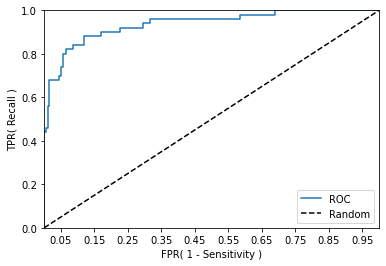



1      예측0  예측1
실제0  176   24
실제1    6   44 
 acc: 0.88 auc: 0.9375
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.070130864197531
            Iterations: 2
            Function evaluations: 55
            Gradient evaluations: 2

#2 교차 검증 정확도 :0.88, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#2 검증 세트 인덱스:200      200
201      201
202      202
203      203
204      204
        ... 
2095    2095
2096    2096
2097    2097
2098    2098
2099    2099
Name: Unnamed: 0, Length: 250, dtype: int64


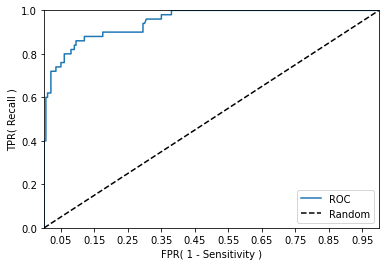



2      예측0  예측1
실제0  176   24
실제1    6   44 
 acc: 0.88 auc: 0.94905
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07363703703703717
            Iterations: 14
            Function evaluations: 328
            Gradient evaluations: 14

#3 교차 검증 정확도 :0.848, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#3 검증 세트 인덱스:400      400
401      401
402      402
403      403
404      404
        ... 
2145    2145
2146    2146
2147    2147
2148    2148
2149    2149
Name: Unnamed: 0, Length: 250, dtype: int64


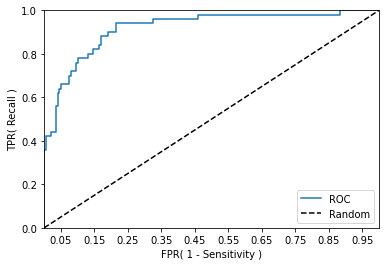



3      예측0  예측1
실제0  171   29
실제1    9   41 
 acc: 0.848 auc: 0.919
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08276049382716055
            Iterations: 6
            Function evaluations: 139
            Gradient evaluations: 6

#4 교차 검증 정확도 :0.844, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#4 검증 세트 인덱스:600      600
601      601
602      602
603      603
604      604
        ... 
2195    2195
2196    2196
2197    2197
2198    2198
2199    2199
Name: Unnamed: 0, Length: 250, dtype: int64


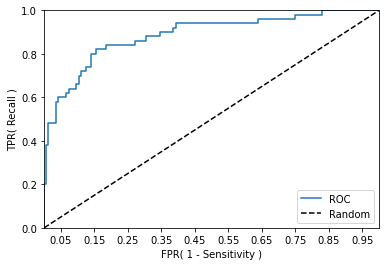



4      예측0  예측1
실제0  172   28
실제1   11   39 
 acc: 0.844 auc: 0.8865999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07330493827160489
            Iterations: 32
            Function evaluations: 785
            Gradient evaluations: 30

#5 교차 검증 정확도 :0.836, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#5 검증 세트 인덱스:800      800
801      801
802      802
803      803
804      804
        ... 
2245    2245
2246    2246
2247    2247
2248    2248
2249    2249
Name: Unnamed: 0, Length: 250, dtype: int64


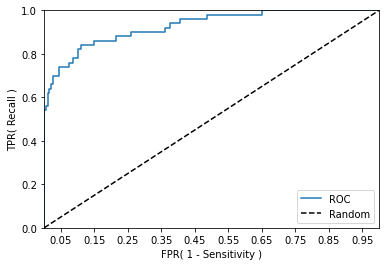



5      예측0  예측1
실제0  166   34
실제1    7   43 
 acc: 0.836 auc: 0.9284
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07935679012345676
            Iterations: 12
            Function evaluations: 287
            Gradient evaluations: 12

#6 교차 검증 정확도 :0.896, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#6 검증 세트 인덱스:1000    1000
1001    1001
1002    1002
1003    1003
1004    1004
        ... 
2295    2295
2296    2296
2297    2297
2298    2298
2299    2299
Name: Unnamed: 0, Length: 250, dtype: int64


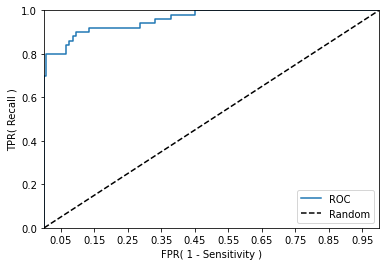



6      예측0  예측1
실제0  179   21
실제1    5   45 
 acc: 0.896 auc: 0.9601999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0829567901234568
            Iterations: 13
            Function evaluations: 294
            Gradient evaluations: 13

#7 교차 검증 정확도 :0.872, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#7 검증 세트 인덱스:1200    1200
1201    1201
1202    1202
1203    1203
1204    1204
        ... 
2345    2345
2346    2346
2347    2347
2348    2348
2349    2349
Name: Unnamed: 0, Length: 250, dtype: int64


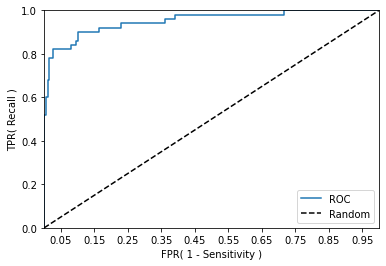



7      예측0  예측1
실제0  173   27
실제1    5   45 
 acc: 0.872 auc: 0.9516
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06735000000000002
            Iterations: 10
            Function evaluations: 254
            Gradient evaluations: 10

#8 교차 검증 정확도 :0.856, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#8 검증 세트 인덱스:1400    1400
1401    1401
1402    1402
1403    1403
1404    1404
        ... 
2395    2395
2396    2396
2397    2397
2398    2398
2399    2399
Name: Unnamed: 0, Length: 250, dtype: int64


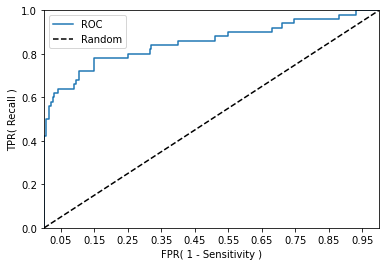



8      예측0  예측1
실제0  178   22
실제1   14   36 
 acc: 0.856 auc: 0.8536999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0756827160493827
            Iterations: 14
            Function evaluations: 357
            Gradient evaluations: 14

#9 교차 검증 정확도 :0.784, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#9 검증 세트 인덱스:1600    1600
1601    1601
1602    1602
1603    1603
1604    1604
        ... 
2445    2445
2446    2446
2447    2447
2448    2448
2449    2449
Name: Unnamed: 0, Length: 250, dtype: int64


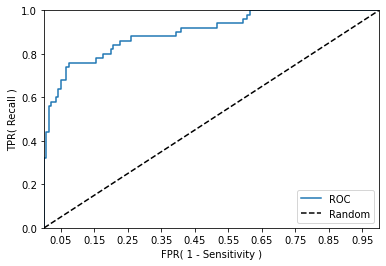



9      예측0  예측1
실제0  153   47
실제1    7   43 
 acc: 0.784 auc: 0.9004
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07921975308641971
            Iterations: 5
            Function evaluations: 124
            Gradient evaluations: 5

#10 교차 검증 정확도 :0.856, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#10 검증 세트 인덱스:1800    1800
1801    1801
1802    1802
1803    1803
1804    1804
        ... 
2495    2495
2496    2496
2497    2497
2498    2498
2499    2499
Name: Unnamed: 0, Length: 250, dtype: int64


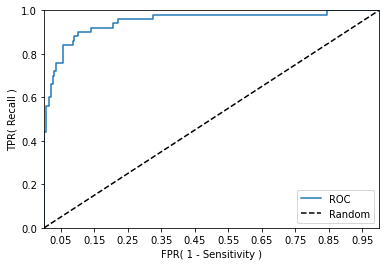



10      예측0  예측1
실제0  168   32
실제1    4   46 
 acc: 0.856 auc: 0.9500000000000002
================================================ 1 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07492345679012347
            Iterations: 9
            Function evaluations: 206
            Gradient evaluations: 9

#11 교차 검증 정확도 :0.872, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#11 검증 세트 인덱스:0          0
1          1
2          2
3          3
4          4
        ... 
2045    2045
2046    2046
2047    2047
2048    2048
2049    2049
Name: Unnamed: 0, Length: 250, dtype: int64


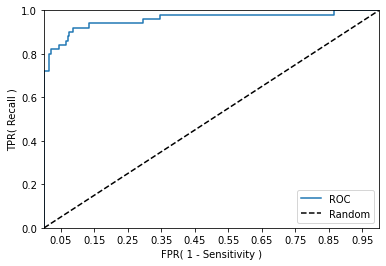



11      예측0  예측1
실제0  171   29
실제1    3   47 
 acc: 0.872 auc: 0.9588000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08235061728395054
            Iterations: 8
            Function evaluations: 184
            Gradient evaluations: 8

#12 교차 검증 정확도 :0.872, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#12 검증 세트 인덱스:200      200
201      201
202      202
203      203
204      204
        ... 
2095    2095
2096    2096
2097    2097
2098    2098
2099    2099
Name: Unnamed: 0, Length: 250, dtype: int64


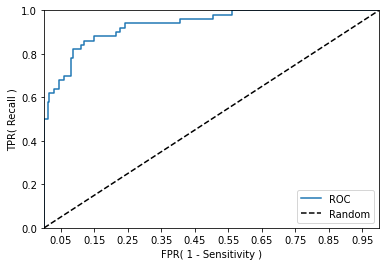



12      예측0  예측1
실제0  176   24
실제1    8   42 
 acc: 0.872 auc: 0.9346
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07194691358024685
            Iterations: 17
            Function evaluations: 392
            Gradient evaluations: 16

#13 교차 검증 정확도 :0.872, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#13 검증 세트 인덱스:400      400
401      401
402      402
403      403
404      404
        ... 
2145    2145
2146    2146
2147    2147
2148    2148
2149    2149
Name: Unnamed: 0, Length: 250, dtype: int64


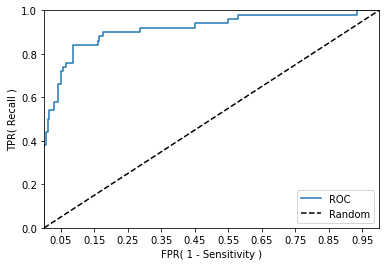



13      예측0  예측1
실제0  176   24
실제1    8   42 
 acc: 0.872 auc: 0.9158999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08683703703703693
            Iterations: 17
            Function evaluations: 383
            Gradient evaluations: 17

#14 교차 검증 정확도 :0.844, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#14 검증 세트 인덱스:600      600
601      601
602      602
603      603
604      604
        ... 
2195    2195
2196    2196
2197    2197
2198    2198
2199    2199
Name: Unnamed: 0, Length: 250, dtype: int64


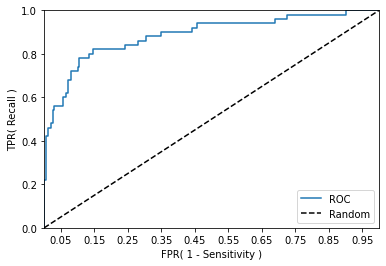



14      예측0  예측1
실제0  170   30
실제1    9   41 
 acc: 0.844 auc: 0.8857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07388765432098754
            Iterations: 12
            Function evaluations: 312
            Gradient evaluations: 12

#15 교차 검증 정확도 :0.844, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#15 검증 세트 인덱스:800      800
801      801
802      802
803      803
804      804
        ... 
2245    2245
2246    2246
2247    2247
2248    2248
2249    2249
Name: Unnamed: 0, Length: 250, dtype: int64


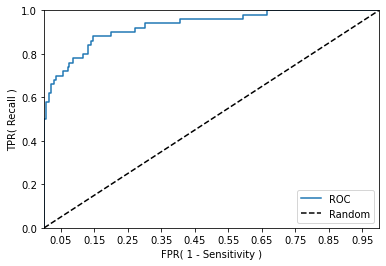



15      예측0  예측1
실제0  167   33
실제1    6   44 
 acc: 0.844 auc: 0.9293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09512469135802482
            Iterations: 32
            Function evaluations: 804
            Gradient evaluations: 32

#16 교차 검증 정확도 :0.868, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#16 검증 세트 인덱스:1000    1000
1001    1001
1002    1002
1003    1003
1004    1004
        ... 
2295    2295
2296    2296
2297    2297
2298    2298
2299    2299
Name: Unnamed: 0, Length: 250, dtype: int64


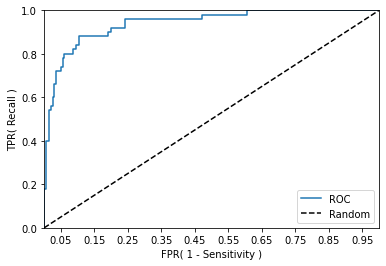



16      예측0  예측1
실제0  173   27
실제1    6   44 
 acc: 0.868 auc: 0.9404
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07597777777777781
            Iterations: 13
            Function evaluations: 323
            Gradient evaluations: 13

#17 교차 검증 정확도 :0.872, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#17 검증 세트 인덱스:1200    1200
1201    1201
1202    1202
1203    1203
1204    1204
        ... 
2345    2345
2346    2346
2347    2347
2348    2348
2349    2349
Name: Unnamed: 0, Length: 250, dtype: int64


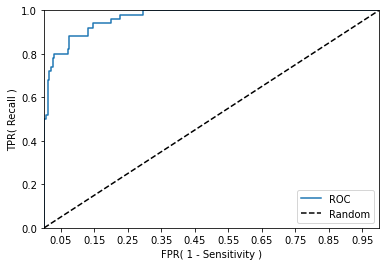



17      예측0  예측1
실제0  172   28
실제1    4   46 
 acc: 0.872 auc: 0.9673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06233333333333313
            Iterations: 6
            Function evaluations: 148
            Gradient evaluations: 6

#18 교차 검증 정확도 :0.852, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#18 검증 세트 인덱스:1400    1400
1401    1401
1402    1402
1403    1403
1404    1404
        ... 
2395    2395
2396    2396
2397    2397
2398    2398
2399    2399
Name: Unnamed: 0, Length: 250, dtype: int64


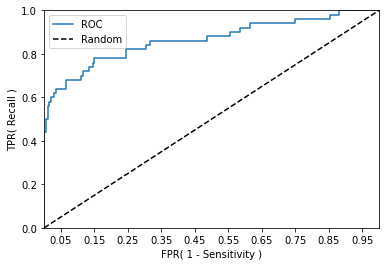



18      예측0  예측1
실제0  178   22
실제1   15   35 
 acc: 0.852 auc: 0.8647000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07428024691358026
            Iterations: 16
            Function evaluations: 375
            Gradient evaluations: 16

#19 교차 검증 정확도 :0.788, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#19 검증 세트 인덱스:1600    1600
1601    1601
1602    1602
1603    1603
1604    1604
        ... 
2445    2445
2446    2446
2447    2447
2448    2448
2449    2449
Name: Unnamed: 0, Length: 250, dtype: int64


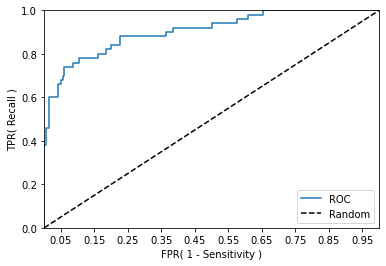



19      예측0  예측1
실제0  153   47
실제1    6   44 
 acc: 0.788 auc: 0.9051
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07935555555555551
            Iterations: 6
            Function evaluations: 138
            Gradient evaluations: 6

#20 교차 검증 정확도 :0.832, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#20 검증 세트 인덱스:1800    1800
1801    1801
1802    1802
1803    1803
1804    1804
        ... 
2495    2495
2496    2496
2497    2497
2498    2498
2499    2499
Name: Unnamed: 0, Length: 250, dtype: int64


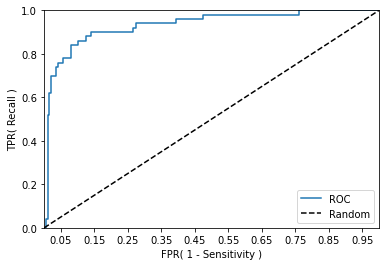



20      예측0  예측1
실제0  163   37
실제1    5   45 
 acc: 0.832 auc: 0.9330999999999999
================================================ 2 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07145308641975312
            Iterations: 10
            Function evaluations: 239
            Gradient evaluations: 10

#21 교차 검증 정확도 :0.856, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#21 검증 세트 인덱스:0          0
1          1
2          2
3          3
4          4
        ... 
2045    2045
2046    2046
2047    2047
2048    2048
2049    2049
Name: Unnamed: 0, Length: 250, dtype: int64


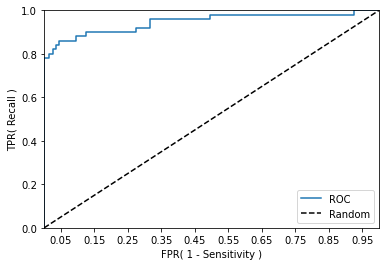



21      예측0  예측1
실제0  169   31
실제1    5   45 
 acc: 0.856 auc: 0.9467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07514814814814808
            Iterations: 16
            Function evaluations: 399
            Gradient evaluations: 16

#22 교차 검증 정확도 :0.86, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#22 검증 세트 인덱스:200      200
201      201
202      202
203      203
204      204
        ... 
2095    2095
2096    2096
2097    2097
2098    2098
2099    2099
Name: Unnamed: 0, Length: 250, dtype: int64


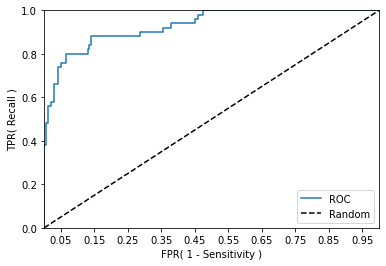



22      예측0  예측1
실제0  173   27
실제1    8   42 
 acc: 0.86 auc: 0.9300999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0630308641975309
            Iterations: 14
            Function evaluations: 319
            Gradient evaluations: 14

#23 교차 검증 정확도 :0.864, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#23 검증 세트 인덱스:400      400
401      401
402      402
403      403
404      404
        ... 
2145    2145
2146    2146
2147    2147
2148    2148
2149    2149
Name: Unnamed: 0, Length: 250, dtype: int64


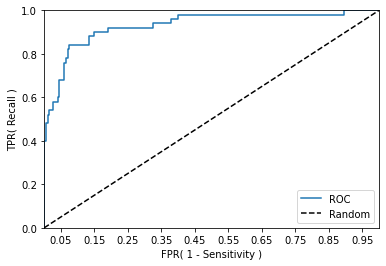



23      예측0  예측1
실제0  174   26
실제1    8   42 
 acc: 0.864 auc: 0.9309
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07453580246913583
            Iterations: 3
            Function evaluations: 82
            Gradient evaluations: 3

#24 교차 검증 정확도 :0.844, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#24 검증 세트 인덱스:600      600
601      601
602      602
603      603
604      604
        ... 
2195    2195
2196    2196
2197    2197
2198    2198
2199    2199
Name: Unnamed: 0, Length: 250, dtype: int64


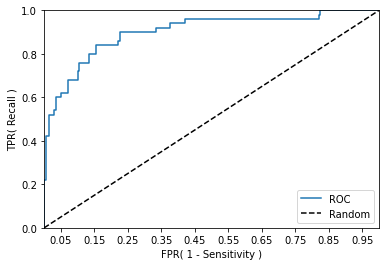



24      예측0  예측1
실제0  171   29
실제1   10   40 
 acc: 0.844 auc: 0.9008999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07285432098765443
            Iterations: 3
            Function evaluations: 75
            Gradient evaluations: 3

#25 교차 검증 정확도 :0.844, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#25 검증 세트 인덱스:800      800
801      801
802      802
803      803
804      804
        ... 
2245    2245
2246    2246
2247    2247
2248    2248
2249    2249
Name: Unnamed: 0, Length: 250, dtype: int64


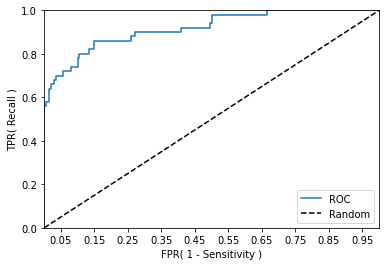



25      예측0  예측1
실제0  168   32
실제1    7   43 
 acc: 0.844 auc: 0.9178
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11238148148148142
            Iterations: 8
            Function evaluations: 181
            Gradient evaluations: 8

#26 교차 검증 정확도 :0.832, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#26 검증 세트 인덱스:1000    1000
1001    1001
1002    1002
1003    1003
1004    1004
        ... 
2295    2295
2296    2296
2297    2297
2298    2298
2299    2299
Name: Unnamed: 0, Length: 250, dtype: int64


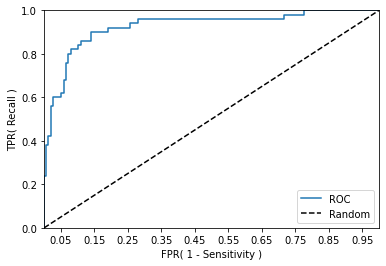



26      예측0  예측1
실제0  162   38
실제1    4   46 
 acc: 0.832 auc: 0.9268000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10465185185185188
            Iterations: 28
            Function evaluations: 676
            Gradient evaluations: 28

#27 교차 검증 정확도 :0.82, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#27 검증 세트 인덱스:1200    1200
1201    1201
1202    1202
1203    1203
1204    1204
        ... 
2345    2345
2346    2346
2347    2347
2348    2348
2349    2349
Name: Unnamed: 0, Length: 250, dtype: int64


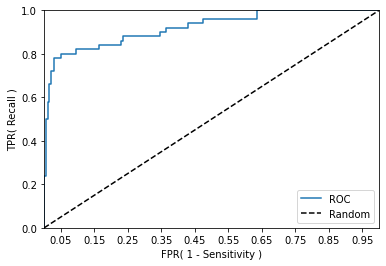



27      예측0  예측1
실제0  163   37
실제1    8   42 
 acc: 0.82 auc: 0.9205
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07850246913580239
            Iterations: 17
            Function evaluations: 416
            Gradient evaluations: 17

#28 교차 검증 정확도 :0.824, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#28 검증 세트 인덱스:1400    1400
1401    1401
1402    1402
1403    1403
1404    1404
        ... 
2395    2395
2396    2396
2397    2397
2398    2398
2399    2399
Name: Unnamed: 0, Length: 250, dtype: int64


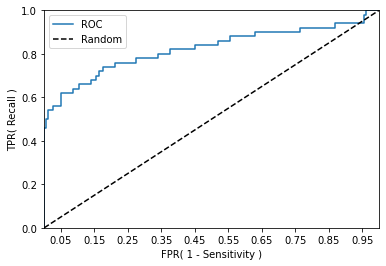



28      예측0  예측1
실제0  172   28
실제1   16   34 
 acc: 0.824 auc: 0.8222
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07372222222222224
            Iterations: 19
            Function evaluations: 474
            Gradient evaluations: 19

#29 교차 검증 정확도 :0.784, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#29 검증 세트 인덱스:1600    1600
1601    1601
1602    1602
1603    1603
1604    1604
        ... 
2445    2445
2446    2446
2447    2447
2448    2448
2449    2449
Name: Unnamed: 0, Length: 250, dtype: int64


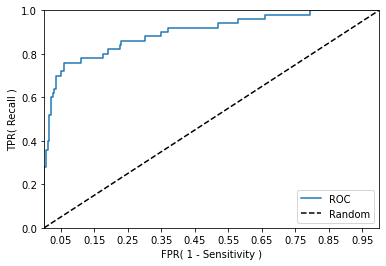



29      예측0  예측1
실제0  154   46
실제1    8   42 
 acc: 0.784 auc: 0.8991
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07389753086419748
            Iterations: 12
            Function evaluations: 289
            Gradient evaluations: 12

#30 교차 검증 정확도 :0.824, 학습 데이터 크기: 2250, 검증 데이터 크기: 250
#30 검증 세트 인덱스:1800    1800
1801    1801
1802    1802
1803    1803
1804    1804
        ... 
2495    2495
2496    2496
2497    2497
2498    2498
2499    2499
Name: Unnamed: 0, Length: 250, dtype: int64


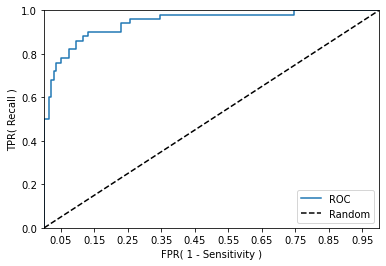



30      예측0  예측1
실제0  161   39
실제1    5   45 
 acc: 0.824 auc: 0.9455
================================================종료================================================

## 교차 검증별 acc: [0.88  0.88  0.848 0.844 0.836 0.896 0.872 0.856 0.784 0.856 0.872 0.872
 0.872 0.844 0.844 0.868 0.872 0.852 0.788 0.832 0.856 0.86  0.864 0.844
 0.844 0.832 0.82  0.824 0.784 0.824]

## 교차 검증별 auc: [0.9375 0.949  0.919  0.8866 0.9284 0.9602 0.9516 0.8537 0.9004 0.95
 0.9588 0.9346 0.9159 0.8857 0.9293 0.9404 0.9673 0.8647 0.9051 0.9331
 0.9467 0.9301 0.9309 0.9009 0.9178 0.9268 0.9205 0.8222 0.8991 0.9455]
## 평균 검증 정확도: 0.8473333333333334
## 평균 검증 auc: 0.920395
        fold_0          fold_1           fold_2           fold_3          \
           예측0    예측1      예측0     예측1      예측0     예측1      예측0     예측1   
실제0     176.00  24.00  176.000  24.000  171.000  29.000  172.000  28.000   
실제1       6.00  44.00    6.000  44.000    9.000  41.000   11.000  39.000   
accauc    0.88   0.88    0.848   0.844   

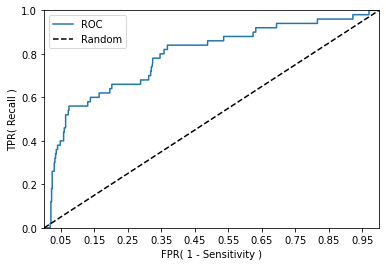



1      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.78974

#2 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

2 검증 세트 인덱스:550     5002
551     4522
552      525
553      453
554     1554
        ... 
1104     937
1107    2864
1108    2971
1109    3050
1110    1153
Name: Unnamed: 0, Length: 550, dtype: int64


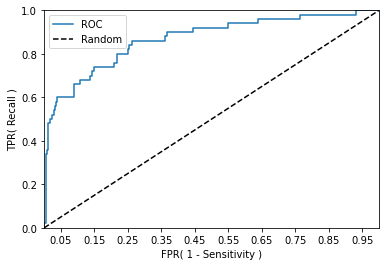



2      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.8678

#3 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

3 검증 세트 인덱스:1037    5089
1041    5426
1049    5070
1070    5407
1076    5417
        ... 
1663    4041
1664    2451
1665    4893
1666    3180
1667    2616
Name: Unnamed: 0, Length: 550, dtype: int64


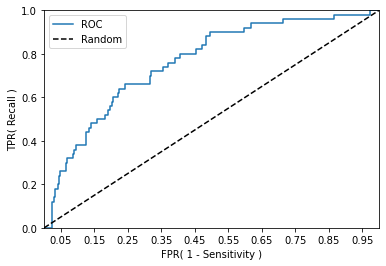



3      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.76096

#4 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

4 검증 세트 인덱스:1475    5218
1483    5220
1494    5359
1507    5132
1509    5371
        ... 
2204     542
2205    4106
2206     760
2207    2473
2208    2036
Name: Unnamed: 0, Length: 550, dtype: int64


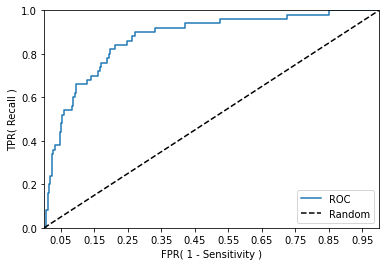



4      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.87124

#5 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

5 검증 세트 인덱스:2126    5104
2134    5472
2136    5036
2140    5006
2149    5265
        ... 
2762    1257
2763    4593
2764    4092
2765    3672
2766    1831
Name: Unnamed: 0, Length: 550, dtype: int64


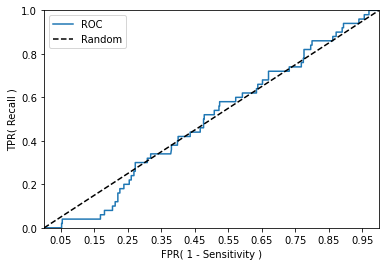



5      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.49194

#6 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

6 검증 세트 인덱스:2637    5190
2640    5393
2641    5363
2646    5456
2650    5433
        ... 
3310    4453
3312    1851
3313    1617
3314    2405
3315    1149
Name: Unnamed: 0, Length: 550, dtype: int64


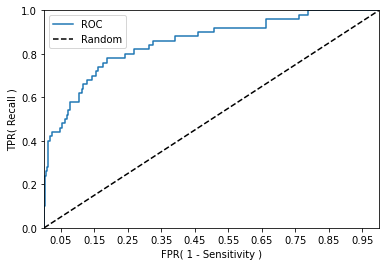



6      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.853

#7 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

7 검증 세트 인덱스:3119    5125
3156    5399
3163    5473
3173    5342
3175    5116
        ... 
3861     275
3862    4694
3863    2011
3865     756
3866    1639
Name: Unnamed: 0, Length: 550, dtype: int64


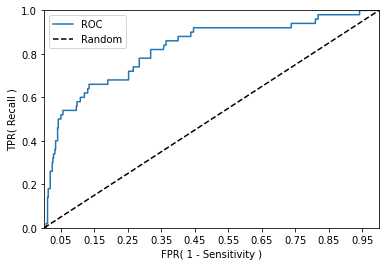



7      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.82326

#8 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

8 검증 세트 인덱스:3718    5121
3722    5357
3724    5294
3730    5320
3743    5499
        ... 
4400    3881
4401    4248
4402     520
4404    2383
4405    3934
Name: Unnamed: 0, Length: 550, dtype: int64


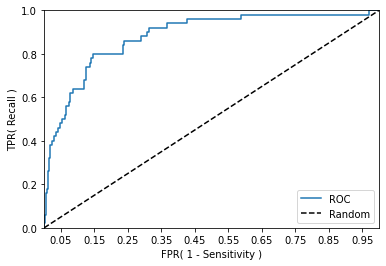



8      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.88188

#9 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

9 검증 세트 인덱스:4347    5300
4371    5185
4377    5144
4388    5318
4399    5072
        ... 
5005    5287
5007    5301
5009    5042
5011    5187
5012    5105
Name: Unnamed: 0, Length: 550, dtype: int64


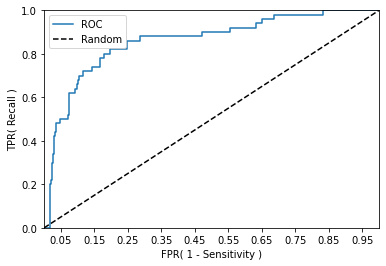



9      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.8599200000000001

#10 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

10 검증 세트 인덱스:4941     648
4942    3484
4943    1751
4944    2758
4945    4173
        ... 
5495    1272
5496     961
5497    2762
5498    1956
5499    1482
Name: Unnamed: 0, Length: 550, dtype: int64


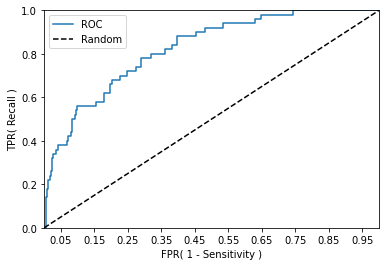



10      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.82376
================================================skfold 2 번째================================================

#11 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

11 검증 세트 인덱스:0      5158
1      3023
2      4237
3      2291
4      4463
       ... 
554    3828
555    4160
556    2153
557    4475
558    3451
Name: Unnamed: 0, Length: 550, dtype: int64


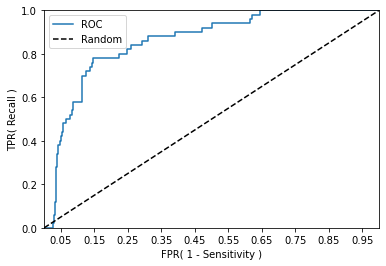



11      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.85756

#12 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

12 검증 세트 인덱스:458     5053
485     5289
504     5149
508     5042
514     5142
        ... 
1095    1050
1096    3064
1097    5181
1098    5203
1099    2484
Name: Unnamed: 0, Length: 550, dtype: int64


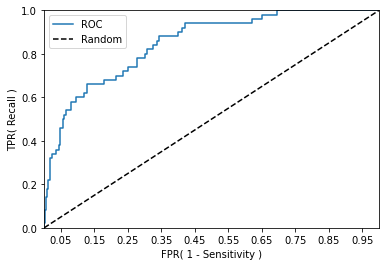



12      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.8492

#13 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

13 검증 세트 인덱스:1100     107
1101    3713
1102    4843
1103    3383
1104    4621
        ... 
1653    2486
1654    4530
1655     103
1657    4006
1658    4823
Name: Unnamed: 0, Length: 550, dtype: int64


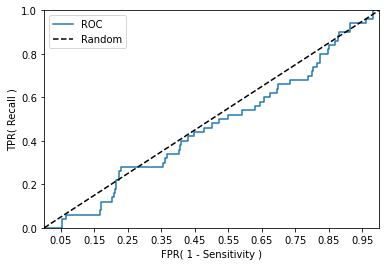



13      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.46224

#14 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

14 검증 세트 인덱스:1582    5055
1583    5309
1589    5012
1590    5299
1601    5496
        ... 
2202    4546
2203     456
2204     667
2205    3607
2206    4097
Name: Unnamed: 0, Length: 550, dtype: int64


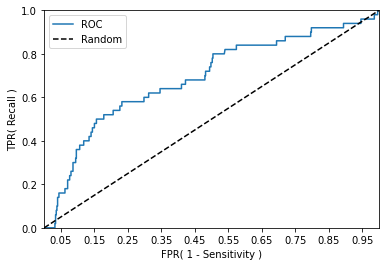



14      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.6880999999999999

#15 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

15 검증 세트 인덱스:2161    5412
2168    5417
2176    5341
2180    5098
2183    5312
        ... 
2751    4757
2752     607
2753    2304
2755     980
2756     694
Name: Unnamed: 0, Length: 550, dtype: int64


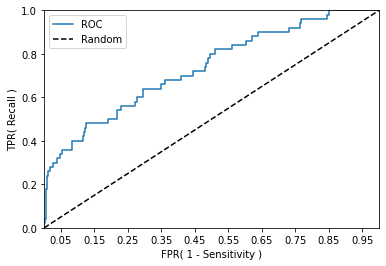



15      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.73412

#16 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

16 검증 세트 인덱스:2715    5392
2716    5389
2718    5462
2729    5477
2741    5084
        ... 
3323    5206
3330    5349
3339    5272
3341    5313
3364    5436
Name: Unnamed: 0, Length: 550, dtype: int64


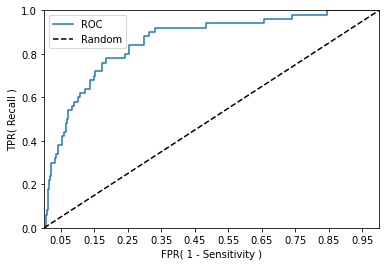



16      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.857

#17 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

17 검증 세트 인덱스:3295    4578
3296    4377
3297    3762
3298     165
3299    3209
        ... 
3845    1571
3848    5410
3853    5493
3855    5212
3857    5437
Name: Unnamed: 0, Length: 550, dtype: int64


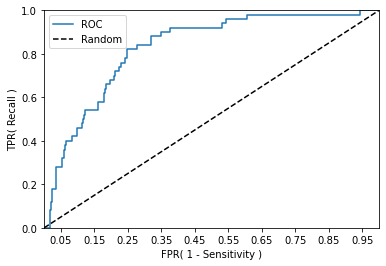



17      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.8286

#18 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

18 검증 세트 인덱스:3846    4075
3847    1911
3849     804
3850     518
3851    1678
        ... 
4400    5041
4414    5062
4415    5421
4420    5484
4427    5380
Name: Unnamed: 0, Length: 550, dtype: int64


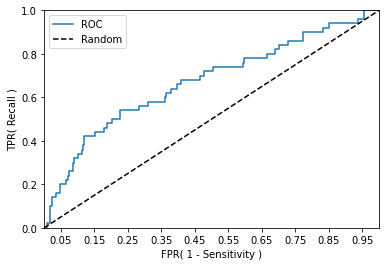



18      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.6706

#19 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

19 검증 세트 인덱스:4395    4790
4396    3808
4397    1550
4398    4132
4399    4916
        ... 
4945    4837
4946      97
4947     197
4948     235
4949    3026
Name: Unnamed: 0, Length: 550, dtype: int64


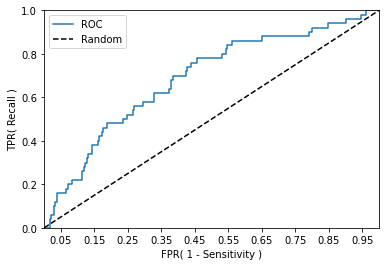



19      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.6876000000000001

#20 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

20 검증 세트 인덱스:4950    1275
4951    5317
4952    2040
4953     810
4954    4673
        ... 
5495    5177
5496    4166
5497    1879
5498    4806
5499    4028
Name: Unnamed: 0, Length: 550, dtype: int64


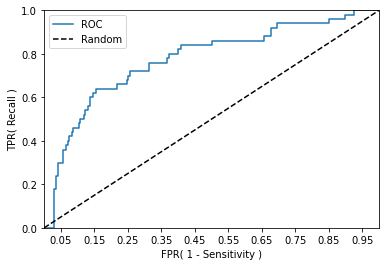



20      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.7754800000000001
================================================skfold 3 번째================================================

#21 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

21 검증 세트 인덱스:0      3387
1      3654
2      3088
3      4795
4       947
       ... 
545    3338
546     562
548    5188
578    5107
603    5444
Name: Unnamed: 0, Length: 550, dtype: int64


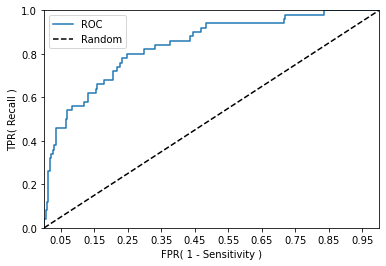



21      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.8393599999999999

#22 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

22 검증 세트 인덱스:547      373
549     4384
550     1994
551     3604
552     3913
        ... 
1099    2910
1100    4853
1101    2494
1102    3914
1103    2657
Name: Unnamed: 0, Length: 550, dtype: int64


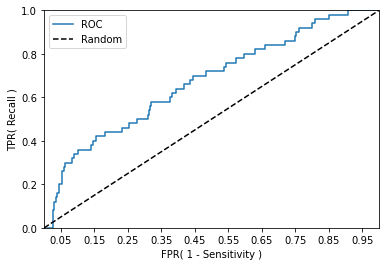



22      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.6733600000000001

#23 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

23 검증 세트 인덱스:1071    5072
1074    5289
1080    5420
1088    5351
1104    2456
        ... 
1645    2224
1646      83
1647    4588
1648    2788
1649      20
Name: Unnamed: 0, Length: 550, dtype: int64


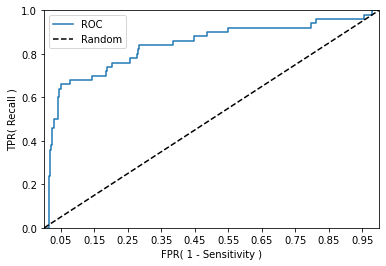



23      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.83856

#24 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

24 검증 세트 인덱스:1650    2286
1651    3647
1652    3251
1653     202
1654    3059
        ... 
2195    1191
2196    5386
2197    2281
2198    2410
2199    4039
Name: Unnamed: 0, Length: 550, dtype: int64


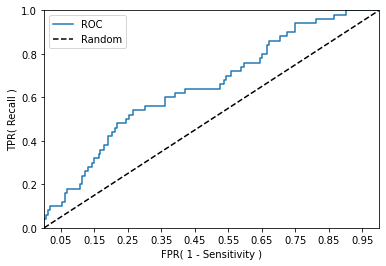



24      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.6515599999999999

#25 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

25 검증 세트 인덱스:2200     651
2201    3325
2202    2311
2203    3769
2204    4241
        ... 
2747    4755
2748    1809
2749    2797
2751    3557
2752    4796
Name: Unnamed: 0, Length: 550, dtype: int64


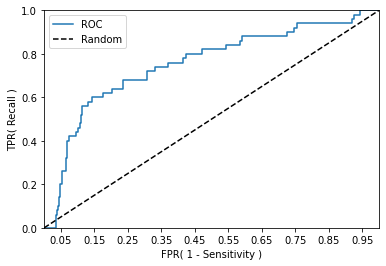



25      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.7534000000000001

#26 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

26 검증 세트 인덱스:2732    5277
2734    5327
2750    5459
2753    1995
2754      23
        ... 
3310    5302
3315    5282
3329    5151
3332    5049
3356    5305
Name: Unnamed: 0, Length: 550, dtype: int64


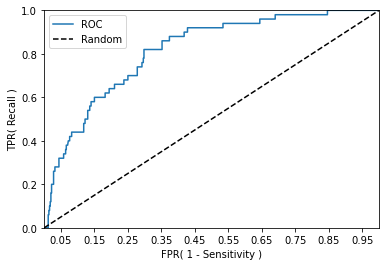



26      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.8143

#27 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

27 검증 세트 인덱스:3295    1472
3296    2299
3297     340
3298    2461
3299    4409
        ... 
3853    5255
3865    5087
3876    5146
3890    5020
3900    5313
Name: Unnamed: 0, Length: 550, dtype: int64


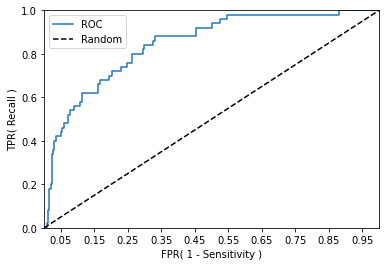



27      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.8459599999999999

#28 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

28 검증 세트 인덱스:3845    4531
3846    4195
3847    2645
3848    4388
3849     190
        ... 
4395    2022
4396    3703
4397    4946
4398     568
4399    5472
Name: Unnamed: 0, Length: 550, dtype: int64


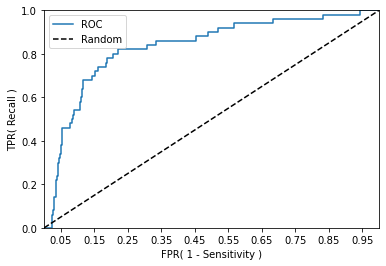



28      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.83232

#29 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

29 검증 세트 인덱스:4400    2837
4401    1292
4402    2292
4403    1431
4404    2931
        ... 
4968    5039
4970    5091
4971    5096
4986    5320
4991    5431
Name: Unnamed: 0, Length: 550, dtype: int64


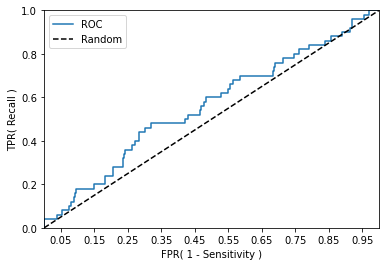



29      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.5605199999999999

#30 교차 검증 정확도 :0.9091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550

30 검증 세트 인덱스:4942    4237
4943    4892
4945    1717
4946    2927
4947    4523
        ... 
5495    3156
5496    4373
5497    1972
5498    3787
5499    3937
Name: Unnamed: 0, Length: 550, dtype: int64


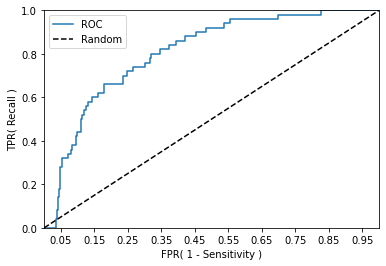



30      예측0  예측1
실제0  500    0
실제1   50    0 
 acc: 0.9091 auc: 0.80596
================================================종료================================================

## 교차 검증별 acc: [0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091
 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091
 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091 0.9091]

## 교차 검증별 auc: [0.7897 0.8678 0.761  0.8712 0.4919 0.853  0.8233 0.8819 0.8599 0.8238
 0.8576 0.8492 0.4622 0.6881 0.7341 0.857  0.8286 0.6706 0.6876 0.7755
 0.8394 0.6734 0.8386 0.6516 0.7534 0.8143 0.846  0.8323 0.5605 0.806 ]

## 평균 검증 정확도: 0.9090999999999998

## 평균 검증 auc: 0.7683099999999999
          fold_0            fold_1            fold_2            fold_3  \
             예측0     예측1       예측0     예측1       예측0     예측1       예측0   
실제0     500.0000  0.0000  500.0000  0.0000  500.0000  0.0000  500.0000   
실제1      50.0000  0.0000   50.0000  0.0000   50.0000  0.0000   50.0000   
acc

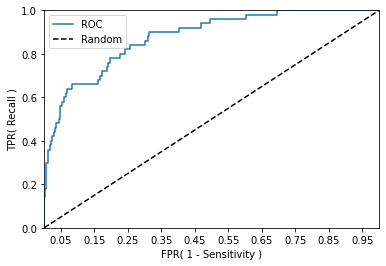



1      예측0  예측1
실제0  394  106
실제1   11   39 
 acc: 0.7873 auc: 0.8775200000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11023703703703702
            Iterations: 15
            Function evaluations: 351
            Gradient evaluations: 15

#2 교차 검증 정확도 :0.8, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#2 검증 세트 인덱스:500      500
501      501
502      502
503      503
504      504
        ... 
5095    5095
5096    5096
5097    5097
5098    5098
5099    5099
Name: Unnamed: 0, Length: 550, dtype: int64


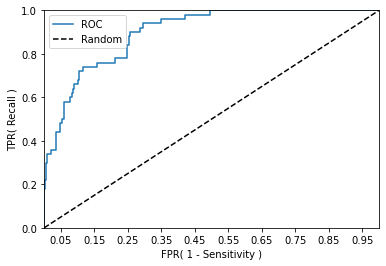



2      예측0  예측1
실제0  402   98
실제1   12   38 
 acc: 0.8 auc: 0.89896
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11845777777777788
            Iterations: 9
            Function evaluations: 228
            Gradient evaluations: 9

#3 교차 검증 정확도 :0.8145, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#3 검증 세트 인덱스:1000    1000
1001    1001
1002    1002
1003    1003
1004    1004
        ... 
5145    5145
5146    5146
5147    5147
5148    5148
5149    5149
Name: Unnamed: 0, Length: 550, dtype: int64


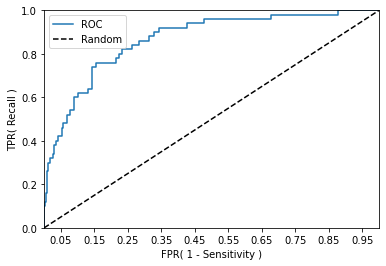



3      예측0  예측1
실제0  410   90
실제1   12   38 
 acc: 0.8145 auc: 0.8672799999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11335604938271604
            Iterations: 15
            Function evaluations: 355
            Gradient evaluations: 15

#4 교차 검증 정확도 :0.8, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#4 검증 세트 인덱스:1500    1500
1501    1501
1502    1502
1503    1503
1504    1504
        ... 
5195    5195
5196    5196
5197    5197
5198    5198
5199    5199
Name: Unnamed: 0, Length: 550, dtype: int64


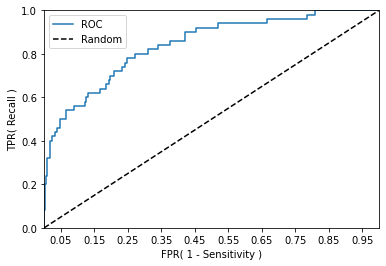



4      예측0  예측1
실제0  407   93
실제1   17   33 
 acc: 0.8 auc: 0.84112
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11711259259259266
            Iterations: 25
            Function evaluations: 636
            Gradient evaluations: 25

#5 교차 검증 정확도 :0.8091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#5 검증 세트 인덱스:2000    2000
2001    2001
2002    2002
2003    2003
2004    2004
        ... 
5245    5245
5246    5246
5247    5247
5248    5248
5249    5249
Name: Unnamed: 0, Length: 550, dtype: int64


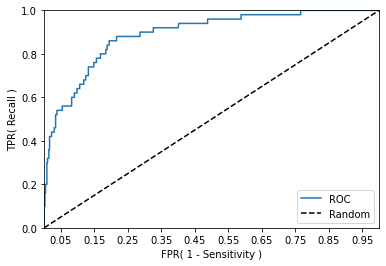



5      예측0  예측1
실제0  402   98
실제1    7   43 
 acc: 0.8091 auc: 0.89082
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12119456790123462
            Iterations: 5
            Function evaluations: 112
            Gradient evaluations: 5

#6 교차 검증 정확도 :0.8218, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#6 검증 세트 인덱스:2500    2500
2501    2501
2502    2502
2503    2503
2504    2504
        ... 
5295    5295
5296    5296
5297    5297
5298    5298
5299    5299
Name: Unnamed: 0, Length: 550, dtype: int64


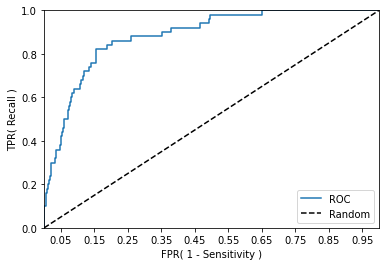



6      예측0  예측1
실제0  411   89
실제1    9   41 
 acc: 0.8218 auc: 0.88356
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11123654320987653
            Iterations: 25
            Function evaluations: 539
            Gradient evaluations: 24

#7 교차 검증 정확도 :0.8127, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#7 검증 세트 인덱스:3000    3000
3001    3001
3002    3002
3003    3003
3004    3004
        ... 
5345    5345
5346    5346
5347    5347
5348    5348
5349    5349
Name: Unnamed: 0, Length: 550, dtype: int64


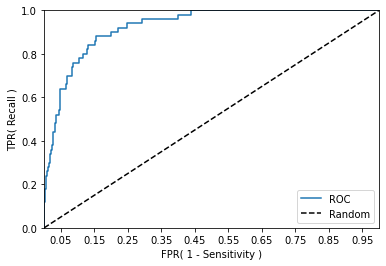



7      예측0  예측1
실제0  403   97
실제1    6   44 
 acc: 0.8127 auc: 0.9269200000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11577975308641963
            Iterations: 21
            Function evaluations: 467
            Gradient evaluations: 21

#8 교차 검증 정확도 :0.7836, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#8 검증 세트 인덱스:3500    3500
3501    3501
3502    3502
3503    3503
3504    3504
        ... 
5395    5395
5396    5396
5397    5397
5398    5398
5399    5399
Name: Unnamed: 0, Length: 550, dtype: int64


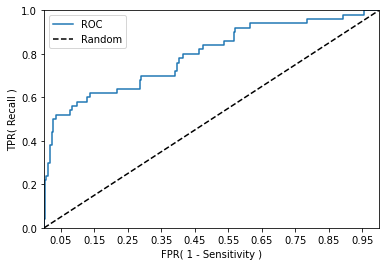



8      예측0  예측1
실제0  400  100
실제1   19   31 
 acc: 0.7836 auc: 0.7931600000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11341679012345685
            Iterations: 8
            Function evaluations: 227
            Gradient evaluations: 8

#9 교차 검증 정확도 :0.7964, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#9 검증 세트 인덱스:4000    4000
4001    4001
4002    4002
4003    4003
4004    4004
        ... 
5445    5445
5446    5446
5447    5447
5448    5448
5449    5449
Name: Unnamed: 0, Length: 550, dtype: int64


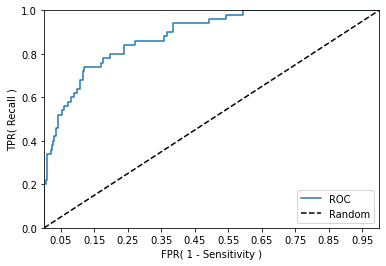



9      예측0  예측1
실제0  398  102
실제1   10   40 
 acc: 0.7964 auc: 0.8846
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1870069135802469
            Iterations: 10
            Function evaluations: 227
            Gradient evaluations: 10

#10 교차 검증 정확도 :0.76, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#10 검증 세트 인덱스:4500    4500
4501    4501
4502    4502
4503    4503
4504    4504
        ... 
5495    5495
5496    5496
5497    5497
5498    5498
5499    5499
Name: Unnamed: 0, Length: 550, dtype: int64


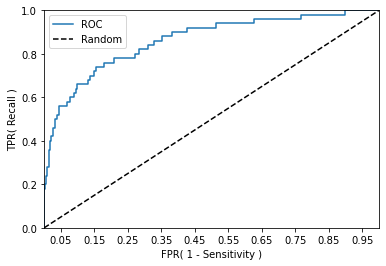



10      예측0  예측1
실제0  379  121
실제1   11   39 
 acc: 0.76 auc: 0.86168
================================================ 1 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11324246913580249
            Iterations: 4
            Function evaluations: 96
            Gradient evaluations: 4

#11 교차 검증 정확도 :0.8127, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#11 검증 세트 인덱스:0          0
1          1
2          2
3          3
4          4
        ... 
5045    5045
5046    5046
5047    5047
5048    5048
5049    5049
Name: Unnamed: 0, Length: 550, dtype: int64


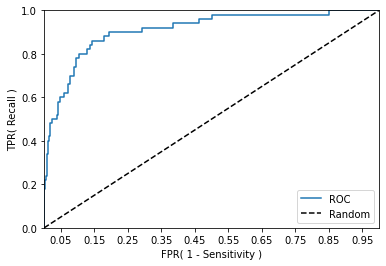



11      예측0  예측1
실제0  402   98
실제1    5   45 
 acc: 0.8127 auc: 0.9104399999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10707358024691349
            Iterations: 8
            Function evaluations: 195
            Gradient evaluations: 8

#12 교차 검증 정확도 :0.8091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#12 검증 세트 인덱스:500      500
501      501
502      502
503      503
504      504
        ... 
5095    5095
5096    5096
5097    5097
5098    5098
5099    5099
Name: Unnamed: 0, Length: 550, dtype: int64


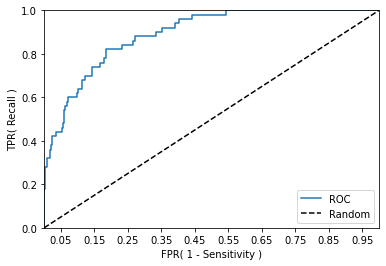



12      예측0  예측1
실제0  404   96
실제1    9   41 
 acc: 0.8091 auc: 0.8913599999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11317382716049385
            Iterations: 7
            Function evaluations: 169
            Gradient evaluations: 7

#13 교차 검증 정확도 :0.8018, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#13 검증 세트 인덱스:1000    1000
1001    1001
1002    1002
1003    1003
1004    1004
        ... 
5145    5145
5146    5146
5147    5147
5148    5148
5149    5149
Name: Unnamed: 0, Length: 550, dtype: int64


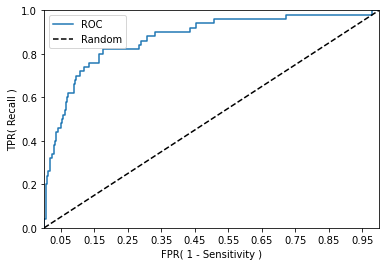



13      예측0  예측1
실제0  400  100
실제1    9   41 
 acc: 0.8018 auc: 0.87284
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10673679012345683
            Iterations: 7
            Function evaluations: 163
            Gradient evaluations: 7

#14 교차 검증 정확도 :0.8036, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#14 검증 세트 인덱스:1500    1500
1501    1501
1502    1502
1503    1503
1504    1504
        ... 
5195    5195
5196    5196
5197    5197
5198    5198
5199    5199
Name: Unnamed: 0, Length: 550, dtype: int64


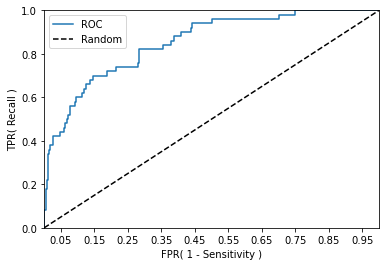



14      예측0  예측1
실제0  407   93
실제1   15   35 
 acc: 0.8036 auc: 0.85248
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10790716049382709
            Iterations: 9
            Function evaluations: 207
            Gradient evaluations: 9

#15 교차 검증 정확도 :0.8127, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#15 검증 세트 인덱스:2000    2000
2001    2001
2002    2002
2003    2003
2004    2004
        ... 
5245    5245
5246    5246
5247    5247
5248    5248
5249    5249
Name: Unnamed: 0, Length: 550, dtype: int64


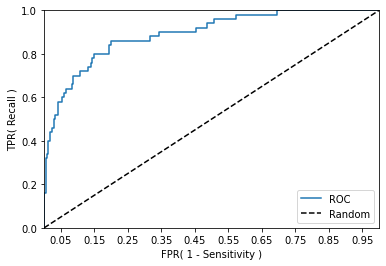



15      예측0  예측1
실제0  407   93
실제1   10   40 
 acc: 0.8127 auc: 0.89168
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11550320987654339
            Iterations: 13
            Function evaluations: 301
            Gradient evaluations: 13

#16 교차 검증 정확도 :0.8236, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#16 검증 세트 인덱스:2500    2500
2501    2501
2502    2502
2503    2503
2504    2504
        ... 
5295    5295
5296    5296
5297    5297
5298    5298
5299    5299
Name: Unnamed: 0, Length: 550, dtype: int64


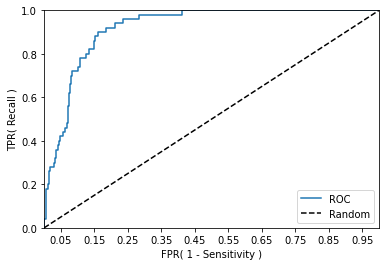



16      예측0  예측1
실제0  408   92
실제1    5   45 
 acc: 0.8236 auc: 0.9206000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1232041975308642
            Iterations: 6
            Function evaluations: 187
            Gradient evaluations: 6

#17 교차 검증 정확도 :0.7982, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#17 검증 세트 인덱스:3000    3000
3001    3001
3002    3002
3003    3003
3004    3004
        ... 
5345    5345
5346    5346
5347    5347
5348    5348
5349    5349
Name: Unnamed: 0, Length: 550, dtype: int64


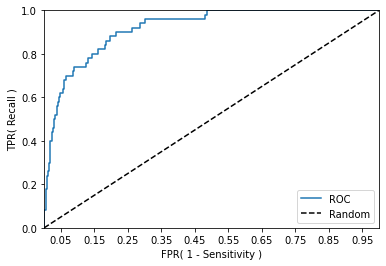



17      예측0  예측1
실제0  395  105
실제1    6   44 
 acc: 0.7982 auc: 0.9178
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1225896296296296
            Iterations: 23
            Function evaluations: 517
            Gradient evaluations: 21

#18 교차 검증 정확도 :0.7927, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#18 검증 세트 인덱스:3500    3500
3501    3501
3502    3502
3503    3503
3504    3504
        ... 
5395    5395
5396    5396
5397    5397
5398    5398
5399    5399
Name: Unnamed: 0, Length: 550, dtype: int64


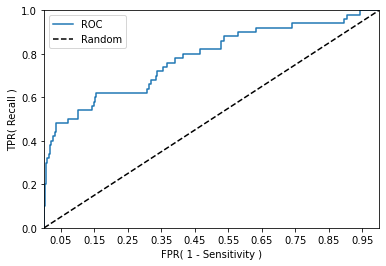



18      예측0  예측1
실제0  405   95
실제1   19   31 
 acc: 0.7927 auc: 0.78
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12243012345679005
            Iterations: 5
            Function evaluations: 115
            Gradient evaluations: 5

#19 교차 검증 정확도 :0.7727, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#19 검증 세트 인덱스:4000    4000
4001    4001
4002    4002
4003    4003
4004    4004
        ... 
5445    5445
5446    5446
5447    5447
5448    5448
5449    5449
Name: Unnamed: 0, Length: 550, dtype: int64


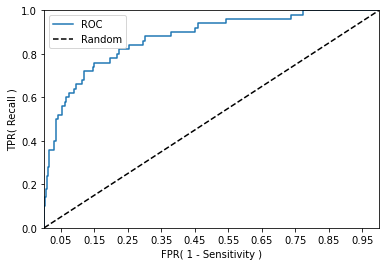



19      예측0  예측1
실제0  384  116
실제1    9   41 
 acc: 0.7727 auc: 0.87304
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11601925925925927
            Iterations: 9
            Function evaluations: 206
            Gradient evaluations: 9

#20 교차 검증 정확도 :0.7927, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#20 검증 세트 인덱스:4500    4500
4501    4501
4502    4502
4503    4503
4504    4504
        ... 
5495    5495
5496    5496
5497    5497
5498    5498
5499    5499
Name: Unnamed: 0, Length: 550, dtype: int64


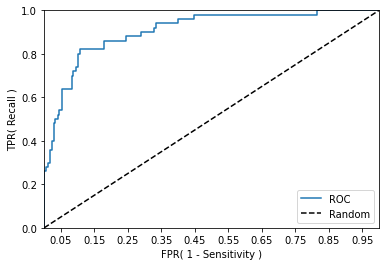



20      예측0  예측1
실제0  393  107
실제1    7   43 
 acc: 0.7927 auc: 0.90668
================================================ 2 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11460592592592589
            Iterations: 4
            Function evaluations: 96
            Gradient evaluations: 4

#21 교차 검증 정확도 :0.8055, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#21 검증 세트 인덱스:0          0
1          1
2          2
3          3
4          4
        ... 
5045    5045
5046    5046
5047    5047
5048    5048
5049    5049
Name: Unnamed: 0, Length: 550, dtype: int64


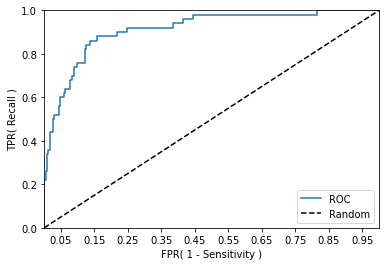



21      예측0  예측1
실제0  399  101
실제1    6   44 
 acc: 0.8055 auc: 0.9128
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10804888888888897
            Iterations: 8
            Function evaluations: 189
            Gradient evaluations: 8

#22 교차 검증 정확도 :0.8, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#22 검증 세트 인덱스:500      500
501      501
502      502
503      503
504      504
        ... 
5095    5095
5096    5096
5097    5097
5098    5098
5099    5099
Name: Unnamed: 0, Length: 550, dtype: int64


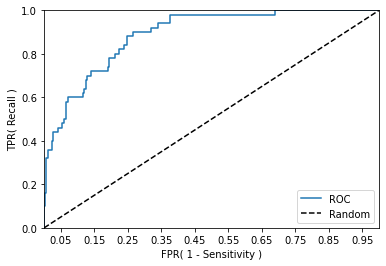



22      예측0  예측1
실제0  403   97
실제1   13   37 
 acc: 0.8 auc: 0.8897999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10988246913580246
            Iterations: 6
            Function evaluations: 169
            Gradient evaluations: 6

#23 교차 검증 정확도 :0.8127, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#23 검증 세트 인덱스:1000    1000
1001    1001
1002    1002
1003    1003
1004    1004
        ... 
5145    5145
5146    5146
5147    5147
5148    5148
5149    5149
Name: Unnamed: 0, Length: 550, dtype: int64


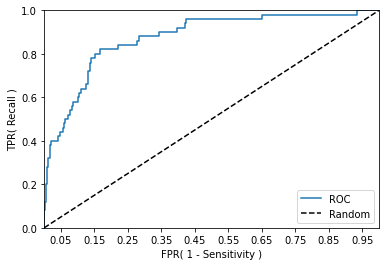



23      예측0  예측1
실제0  406   94
실제1    9   41 
 acc: 0.8127 auc: 0.87512
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11507308641975311
            Iterations: 8
            Function evaluations: 194
            Gradient evaluations: 8

#24 교차 검증 정확도 :0.7855, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#24 검증 세트 인덱스:1500    1500
1501    1501
1502    1502
1503    1503
1504    1504
        ... 
5195    5195
5196    5196
5197    5197
5198    5198
5199    5199
Name: Unnamed: 0, Length: 550, dtype: int64


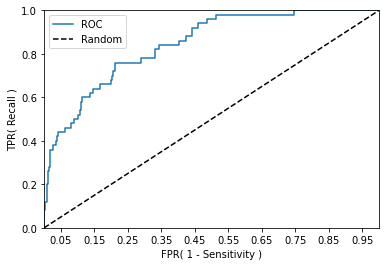



24      예측0  예측1
실제0  398  102
실제1   16   34 
 acc: 0.7855 auc: 0.84508
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11394320987654327
            Iterations: 16
            Function evaluations: 372
            Gradient evaluations: 16

#25 교차 검증 정확도 :0.8091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#25 검증 세트 인덱스:2000    2000
2001    2001
2002    2002
2003    2003
2004    2004
        ... 
5245    5245
5246    5246
5247    5247
5248    5248
5249    5249
Name: Unnamed: 0, Length: 550, dtype: int64


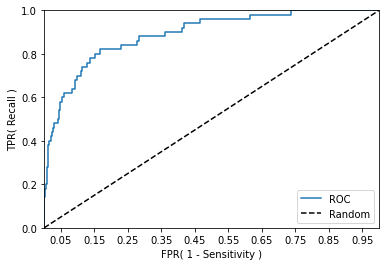



25      예측0  예측1
실제0  404   96
실제1    9   41 
 acc: 0.8091 auc: 0.89
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11251407407407399
            Iterations: 16
            Function evaluations: 365
            Gradient evaluations: 16

#26 교차 검증 정확도 :0.8236, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#26 검증 세트 인덱스:2500    2500
2501    2501
2502    2502
2503    2503
2504    2504
        ... 
5295    5295
5296    5296
5297    5297
5298    5298
5299    5299
Name: Unnamed: 0, Length: 550, dtype: int64


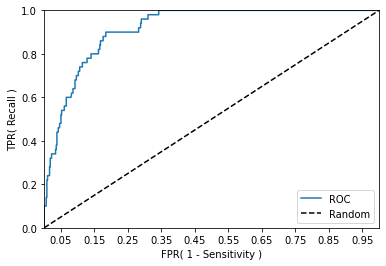



26      예측0  예측1
실제0  409   91
실제1    6   44 
 acc: 0.8236 auc: 0.9167
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11076740740740743
            Iterations: 25
            Function evaluations: 570
            Gradient evaluations: 24

#27 교차 검증 정확도 :0.8127, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#27 검증 세트 인덱스:3000    3000
3001    3001
3002    3002
3003    3003
3004    3004
        ... 
5345    5345
5346    5346
5347    5347
5348    5348
5349    5349
Name: Unnamed: 0, Length: 550, dtype: int64


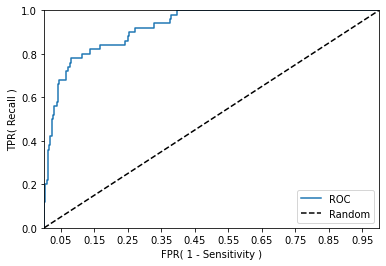



27      예측0  예측1
실제0  405   95
실제1    8   42 
 acc: 0.8127 auc: 0.9236800000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10661580246913571
            Iterations: 11
            Function evaluations: 259
            Gradient evaluations: 11

#28 교차 검증 정확도 :0.8018, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#28 검증 세트 인덱스:3500    3500
3501    3501
3502    3502
3503    3503
3504    3504
        ... 
5395    5395
5396    5396
5397    5397
5398    5398
5399    5399
Name: Unnamed: 0, Length: 550, dtype: int64


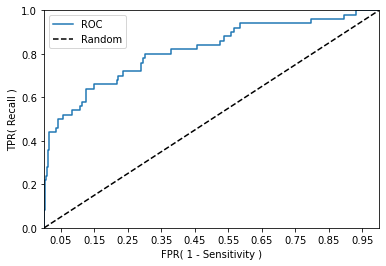



28      예측0  예측1
실제0  408   92
실제1   17   33 
 acc: 0.8018 auc: 0.8159199999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11140098765432094
            Iterations: 8
            Function evaluations: 186
            Gradient evaluations: 8

#29 교차 검증 정확도 :0.8091, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#29 검증 세트 인덱스:4000    4000
4001    4001
4002    4002
4003    4003
4004    4004
        ... 
5445    5445
5446    5446
5447    5447
5448    5448
5449    5449
Name: Unnamed: 0, Length: 550, dtype: int64


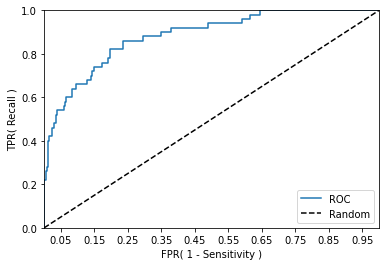



29      예측0  예측1
실제0  407   93
실제1   12   38 
 acc: 0.8091 auc: 0.8822
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11327802469135806
            Iterations: 4
            Function evaluations: 93
            Gradient evaluations: 4

#30 교차 검증 정확도 :0.8, 학습 데이터 크기: 4950, 검증 데이터 크기: 550
#30 검증 세트 인덱스:4500    4500
4501    4501
4502    4502
4503    4503
4504    4504
        ... 
5495    5495
5496    5496
5497    5497
5498    5498
5499    5499
Name: Unnamed: 0, Length: 550, dtype: int64


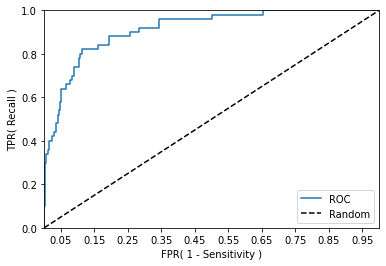



30      예측0  예측1
실제0  396  104
실제1    6   44 
 acc: 0.8 auc: 0.9136399999999999
================================================종료================================================

## 교차 검증별 acc: [0.7873 0.8    0.8145 0.8    0.8091 0.8218 0.8127 0.7836 0.7964 0.76
 0.8127 0.8091 0.8018 0.8036 0.8127 0.8236 0.7982 0.7927 0.7727 0.7927
 0.8055 0.8    0.8127 0.7855 0.8091 0.8236 0.8127 0.8018 0.8091 0.8   ]

## 교차 검증별 auc: [0.8775 0.899  0.8673 0.8411 0.8908 0.8836 0.9269 0.7932 0.8846 0.8617
 0.9104 0.8914 0.8728 0.8525 0.8917 0.9206 0.9178 0.78   0.873  0.9067
 0.9128 0.8898 0.8751 0.8451 0.89   0.9167 0.9237 0.8159 0.8822 0.9136]
## 평균 검증 정확도: 0.8021733333333334
## 평균 검증 auc: 0.8802493333333333
          fold_0           fold_1          fold_2             fold_3           \
             예측0    예측1       예측0   예측1       예측0      예측1       예측0      예측1   
실제0     394.0000  106.0  402.0000  98.0  410.0000  90.0000  407.0000  93.0000   
실제1      11.0000   39.0   12.0000  38.0   12.0000  3

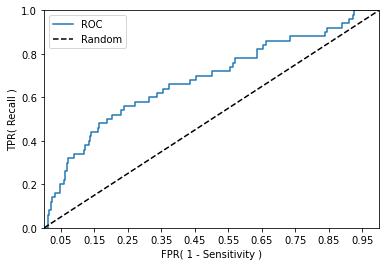



1       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.68134

#2 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

2 검증 세트 인덱스:922     10448
932     10291
938     10242
991     10150
1006    10205
        ...  
2226    10312
2233    10182
2245    10342
2252    10296
2290    10045
Name: Unnamed: 0, Length: 1050, dtype: int64


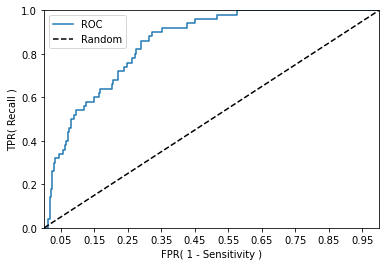



2       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.84972

#3 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

3 검증 세트 인덱스:2091    8920
2092    6162
2093    4561
2094    6625
2095    5306
        ... 
3154    1243
3155    7756
3156    2704
3157    2882
3158    1809
Name: Unnamed: 0, Length: 1050, dtype: int64


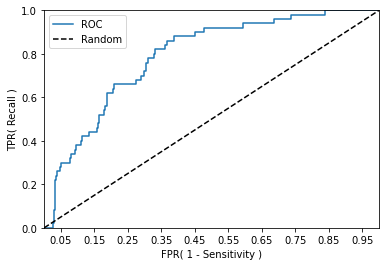



3       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.78938

#4 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

4 검증 세트 인덱스:3021    10218
3038    10059
3062    10269
3068    10358
3072    10156
        ...  
4198      947
4199     7741
4200     1315
4201     7404
4202     7925
Name: Unnamed: 0, Length: 1050, dtype: int64


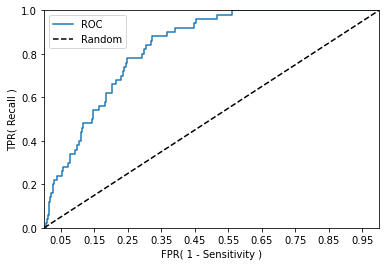



4       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.8293400000000001

#5 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

5 검증 세트 인덱스:4093    10383
4142    10428
4146    10377
4203     9719
4204     7472
        ...  
5439    10021
5460    10073
5473    10323
5487    10216
5516    10117
Name: Unnamed: 0, Length: 1050, dtype: int64


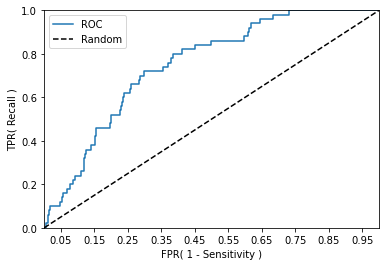



5       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.7502

#6 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

6 검증 세트 인덱스:5238     2092
5239     6213
5240     1937
5241     6947
5242     9780
        ...  
6475    10482
6476    10414
6480    10333
6512    10281
6538    10244
Name: Unnamed: 0, Length: 1050, dtype: int64


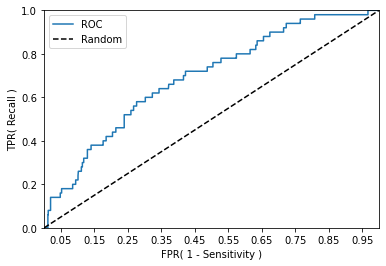



6       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.6906

#7 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

7 검증 세트 인덱스:6286     3095
6287     9375
6288     9113
6289     3376
6291     8387
        ...  
7365    10327
7381    10015
7387    10339
7388    10385
7401    10283
Name: Unnamed: 0, Length: 1050, dtype: int64


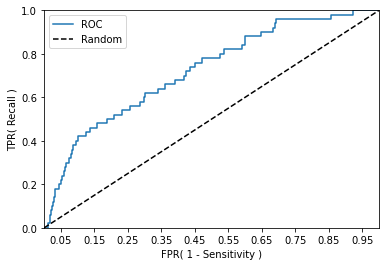



7       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.7225599999999999

#8 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

8 검증 세트 인덱스:7344     5473
7345     1940
7346     8955
7347     4531
7348       64
        ...  
8395     4100
8396    10498
8397     4895
8398     2504
8400     1716
Name: Unnamed: 0, Length: 1050, dtype: int64


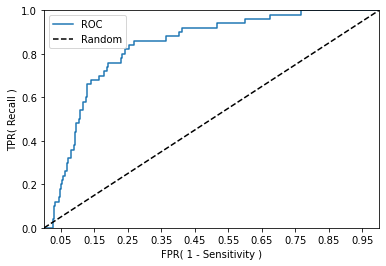



8       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.8333600000000001

#9 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

9 검증 세트 인덱스:8399    10070
8401     2607
8402     8424
8403     1587
8404     4329
        ...  
9445     1155
9446     7599
9447     5280
9449     2941
9450     1368
Name: Unnamed: 0, Length: 1050, dtype: int64


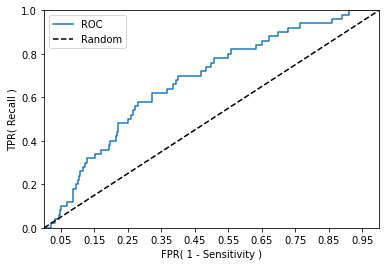



9       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.6747199999999999

#10 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

10 검증 세트 인덱스:9448     10397
9451      4737
9452      3942
9453      6057
9454      8217
         ...  
10495     3206
10496     9536
10497     2733
10498     6491
10499     3342
Name: Unnamed: 0, Length: 1050, dtype: int64


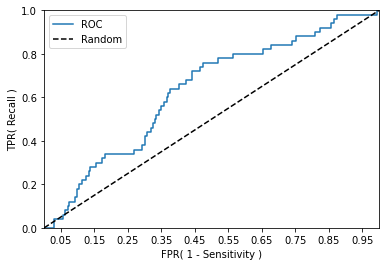



10       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.63072
================================================skfold 2 번째================================================

#11 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

11 검증 세트 인덱스:0        3863
1        2325
2        3409
3        4945
4       10428
        ...  
1053     1694
1054     1988
1055     2063
1056     3585
1057      260
Name: Unnamed: 0, Length: 1050, dtype: int64


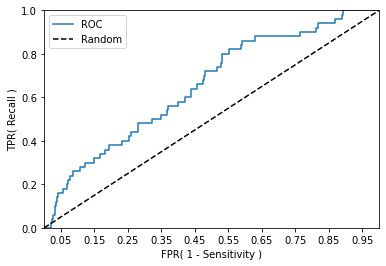



11       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.65332

#12 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

12 검증 세트 인덱스:813     10256
815     10292
836     10157
870     10058
880     10473
        ...  
2105     4020
2106     7983
2107     8746
2108     4813
2109     6879
Name: Unnamed: 0, Length: 1050, dtype: int64


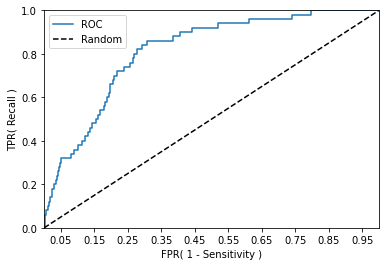



12       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.8129799999999999

#13 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

13 검증 세트 인덱스:1963    10412
1967    10282
1975    10401
1981    10451
2002    10036
        ...  
3158     5707
3159     1587
3160     7873
3161     5872
3162     8622
Name: Unnamed: 0, Length: 1050, dtype: int64


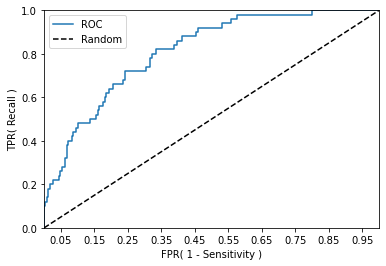



13       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.8117

#14 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

14 검증 세트 인덱스:2960    10106
2961    10431
2979    10152
2993    10370
3006    10476
        ...  
4207     6486
4208      214
4209     4973
4210     7611
4211      828
Name: Unnamed: 0, Length: 1050, dtype: int64


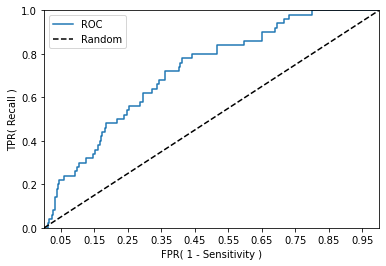



14       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.72142

#15 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

15 검증 세트 인덱스:4054    10364
4055    10201
4060    10187
4067    10195
4078    10056
        ...  
5262     2922
5263      539
5266     4959
5267     1076
5268     9882
Name: Unnamed: 0, Length: 1050, dtype: int64


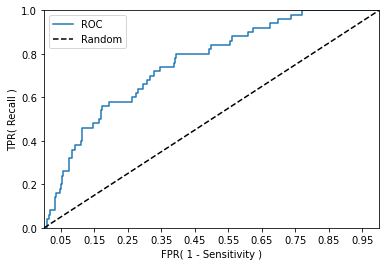



15       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.75642

#16 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

16 검증 세트 인덱스:4936    10061
4937    10375
4938    10347
4943    10075
4954    10199
        ...  
6309     3478
6310     4232
6311     1524
6312     7705
6313      146
Name: Unnamed: 0, Length: 1050, dtype: int64


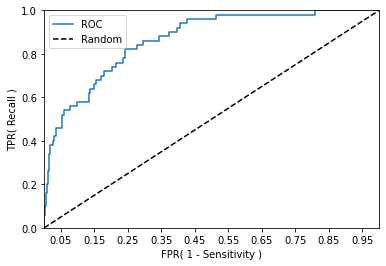



16       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.8659000000000001

#17 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

17 검증 세트 인덱스:5986    10463
6057    10327
6059    10462
6067    10127
6079    10350
        ...  
7349     3081
7350       40
7351     2208
7352     3495
7353     8009
Name: Unnamed: 0, Length: 1050, dtype: int64


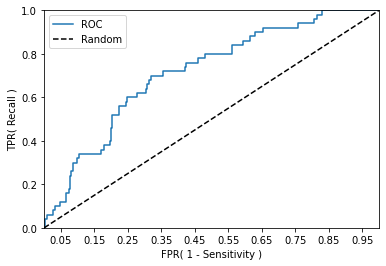



17       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.71654

#18 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

18 검증 세트 인덱스:7269    10172
7301    10251
7342    10387
7346    10079
7354     9123
        ...  
8405      372
8406     1391
8407     2035
8408      661
8409     1657
Name: Unnamed: 0, Length: 1050, dtype: int64


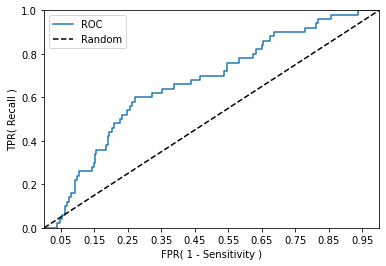



18       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.6664

#19 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

19 검증 세트 인덱스:8241    10229
8292    10435
8297    10280
8340    10016
8377    10441
        ...  
9445     2505
9446     8155
9447     2736
9448     7303
9456    10190
Name: Unnamed: 0, Length: 1050, dtype: int64


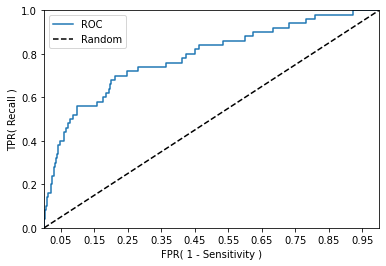



19       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.7866200000000001

#20 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

20 검증 세트 인덱스:9449      459
9450     3662
9451     4872
9452     4137
9453     3154
         ... 
10495    2981
10496    5887
10497    5762
10498    2215
10499    3061
Name: Unnamed: 0, Length: 1050, dtype: int64


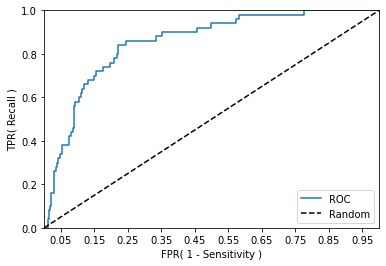



20       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.85358
================================================skfold 3 번째================================================

#21 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

21 검증 세트 인덱스:0         58
1       3574
2       2027
3       7251
4        850
        ... 
1048    9570
1049    3255
1051    9324
1052    2581
1053     995
Name: Unnamed: 0, Length: 1050, dtype: int64


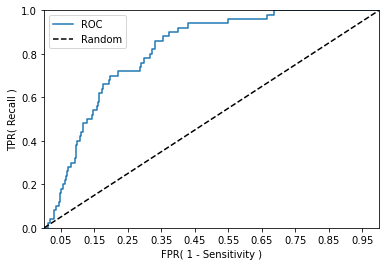



21       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.81416

#22 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

22 검증 세트 인덱스:1003    10455
1014    10463
1044    10006
1050    10363
1054     6079
        ...  
2107     1670
2108     4645
2109     9414
2110     2702
2111     7121
Name: Unnamed: 0, Length: 1050, dtype: int64


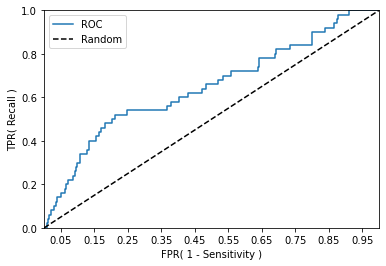



22       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.6467999999999999

#23 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

23 검증 세트 인덱스:1970    10319
1977    10446
1981    10021
1988    10346
2023    10362
        ...  
3153     1268
3154     9675
3155     1446
3156     5536
3157     8146
Name: Unnamed: 0, Length: 1050, dtype: int64


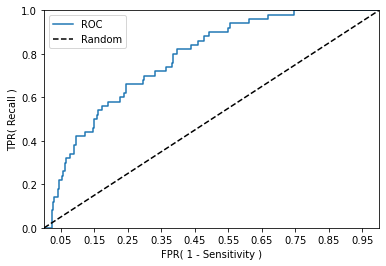



23       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.77734

#24 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

24 검증 세트 인덱스:2991    10206
3058    10277
3068    10149
3071    10111
3074    10479
        ...  
4196      832
4197     1508
4198     6667
4199     1047
4200     2988
Name: Unnamed: 0, Length: 1050, dtype: int64


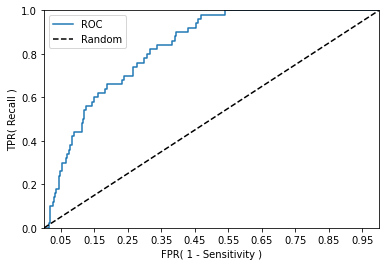



24       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.82788

#25 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

25 검증 세트 인덱스:4194    10422
4201      857
4202    10202
4203     4981
4204     1134
        ...  
5245     7780
5246     3690
5247        6
5248      901
5315    10488
Name: Unnamed: 0, Length: 1050, dtype: int64


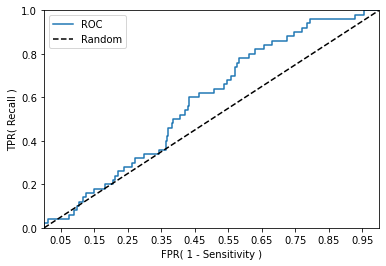



25       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.58168

#26 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

26 검증 세트 인덱스:5249    6301
5250    9845
5251    1763
5252    7371
5253    3674
        ... 
6300    4670
6301    8495
6302    6725
6303    5644
6304    9180
Name: Unnamed: 0, Length: 1050, dtype: int64


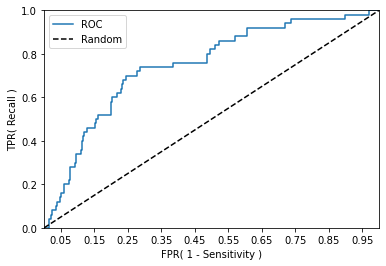



26       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.74728

#27 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

27 검증 세트 인덱스:6228    10173
6231    10157
6236    10007
6267    10065
6277    10254
        ...  
7345     1806
7346     5467
7347    10320
7348     2800
7362    10096
Name: Unnamed: 0, Length: 1050, dtype: int64


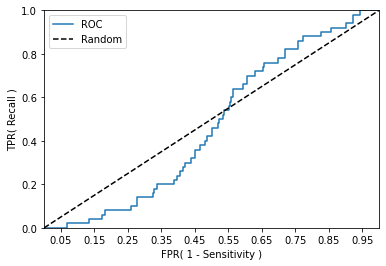



27       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.46784000000000003

#28 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

28 검증 세트 인덱스:7349     4933
7350     8946
7351     9814
7352     8618
7353     5539
        ...  
8427    10022
8449    10238
8460    10495
8483    10405
8490    10288
Name: Unnamed: 0, Length: 1050, dtype: int64


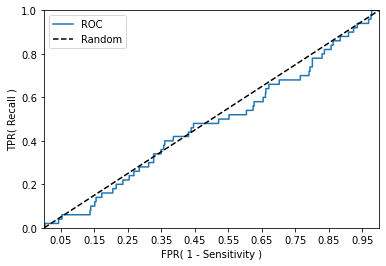



28       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.47523

#29 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

29 검증 세트 인덱스:8393    5808
8394    1527
8395    5695
8396    7442
8397     248
        ... 
9450    3390
9451    3691
9452    2721
9453    9627
9454    8375
Name: Unnamed: 0, Length: 1050, dtype: int64


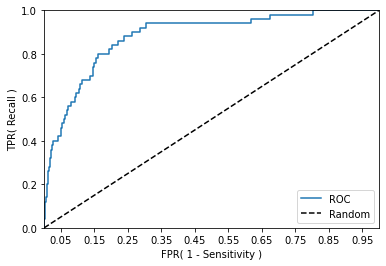



29       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.88104

#30 교차 검증 정확도 :0.9524, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050

30 검증 세트 인덱스:9334     10314
9341     10134
9344     10200
9421     10442
9425     10296
         ...  
10495     8919
10496     4518
10497     1711
10498     8164
10499     6333
Name: Unnamed: 0, Length: 1050, dtype: int64


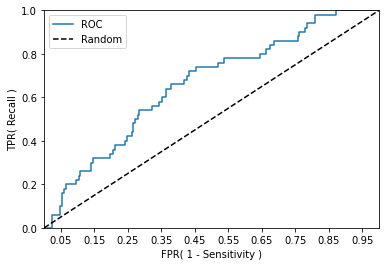



30       예측0  예측1
실제0  1000    0
실제1    50    0 
 acc: 0.9524 auc: 0.659
================================================종료================================================

## 교차 검증별 acc: [0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524
 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524
 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524 0.9524]

## 교차 검증별 auc: [0.6813 0.8497 0.7894 0.8293 0.7502 0.6906 0.7226 0.8334 0.6747 0.6307
 0.6533 0.813  0.8117 0.7214 0.7564 0.8659 0.7165 0.6664 0.7866 0.8536
 0.8142 0.6468 0.7773 0.8279 0.5817 0.7473 0.4678 0.4752 0.881  0.659 ]

## 평균 검증 정확도: 0.9524000000000002

## 평균 검증 auc: 0.732502333333333
           fold_0             fold_1             fold_2             fold_3  \
              예측0     예측1        예측0     예측1        예측0     예측1        예측0   
실제0     1000.0000  0.0000  1000.0000  0.0000  1000.0000  0.0000  1000.0000   
실제1       50.0000  0.0000    50.0000  0.0000    50.0000  0.0000  

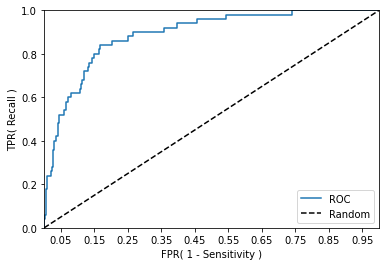



1      예측0  예측1
실제0  789  211
실제1    7   43 
 acc: 0.7924 auc: 0.88986
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14043061728395057
            Iterations: 20
            Function evaluations: 441
            Gradient evaluations: 20

#2 교차 검증 정확도 :0.799, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#2 검증 세트 인덱스:1000      1000
1001      1001
1002      1002
1003      1003
1004      1004
         ...  
10095    10095
10096    10096
10097    10097
10098    10098
10099    10099
Name: Unnamed: 0, Length: 1050, dtype: int64


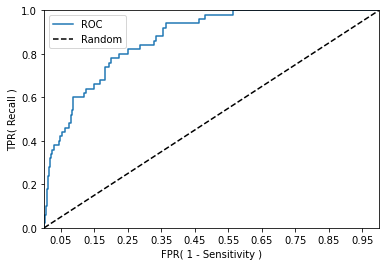



2      예측0  예측1
실제0  800  200
실제1   11   39 
 acc: 0.799 auc: 0.87012
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.15093111111111113
            Iterations: 11
            Function evaluations: 262
            Gradient evaluations: 11

#3 교차 검증 정확도 :0.7324, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#3 검증 세트 인덱스:2000      2000
2001      2001
2002      2002
2003      2003
2004      2004
         ...  
10145    10145
10146    10146
10147    10147
10148    10148
10149    10149
Name: Unnamed: 0, Length: 1050, dtype: int64


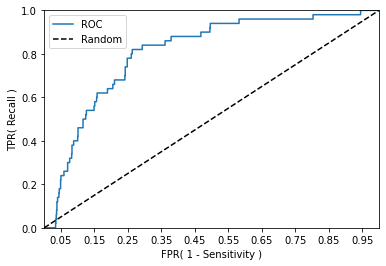



3      예측0  예측1
실제0  728  272
실제1    9   41 
 acc: 0.7324 auc: 0.80651
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14767999999999992
            Iterations: 20
            Function evaluations: 477
            Gradient evaluations: 20

#4 교차 검증 정확도 :0.7762, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#4 검증 세트 인덱스:3000      3000
3001      3001
3002      3002
3003      3003
3004      3004
         ...  
10195    10195
10196    10196
10197    10197
10198    10198
10199    10199
Name: Unnamed: 0, Length: 1050, dtype: int64


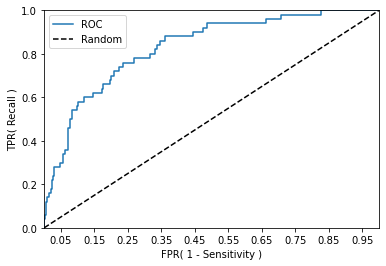



4      예측0  예측1
실제0  779  221
실제1   14   36 
 acc: 0.7762 auc: 0.8297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.21872148148148163
            Iterations: 26
            Function evaluations: 547
            Gradient evaluations: 24

#5 교차 검증 정확도 :0.7029, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#5 검증 세트 인덱스:4000      4000
4001      4001
4002      4002
4003      4003
4004      4004
         ...  
10245    10245
10246    10246
10247    10247
10248    10248
10249    10249
Name: Unnamed: 0, Length: 1050, dtype: int64


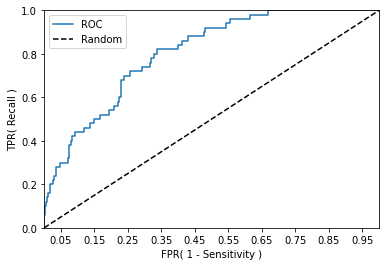



5      예측0  예측1
실제0  701  299
실제1   13   37 
 acc: 0.7029 auc: 0.8043399999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19606370370370385
            Iterations: 17
            Function evaluations: 381
            Gradient evaluations: 17

#6 교차 검증 정확도 :0.7667, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#6 검증 세트 인덱스:5000      5000
5001      5001
5002      5002
5003      5003
5004      5004
         ...  
10295    10295
10296    10296
10297    10297
10298    10298
10299    10299
Name: Unnamed: 0, Length: 1050, dtype: int64


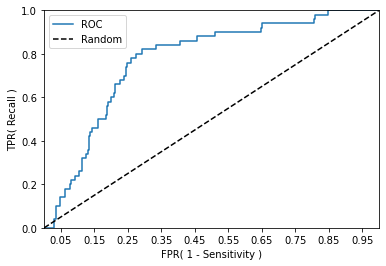



6      예측0  예측1
실제0  771  229
실제1   16   34 
 acc: 0.7667 auc: 0.7720600000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1454180246913579
            Iterations: 15
            Function evaluations: 337
            Gradient evaluations: 15

#7 교차 검증 정확도 :0.78, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#7 검증 세트 인덱스:6000      6000
6001      6001
6002      6002
6003      6003
6004      6004
         ...  
10345    10345
10346    10346
10347    10347
10348    10348
10349    10349
Name: Unnamed: 0, Length: 1050, dtype: int64


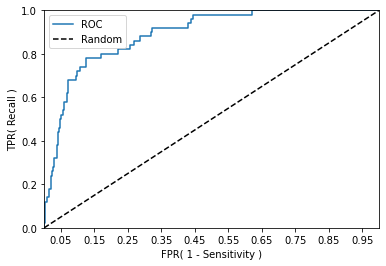



7      예측0  예측1
실제0  778  222
실제1    9   41 
 acc: 0.78 auc: 0.8902000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12998864197530857
            Iterations: 11
            Function evaluations: 269
            Gradient evaluations: 11

#8 교차 검증 정확도 :0.7724, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#8 검증 세트 인덱스:7000      7000
7001      7001
7002      7002
7003      7003
7004      7004
         ...  
10395    10395
10396    10396
10397    10397
10398    10398
10399    10399
Name: Unnamed: 0, Length: 1050, dtype: int64


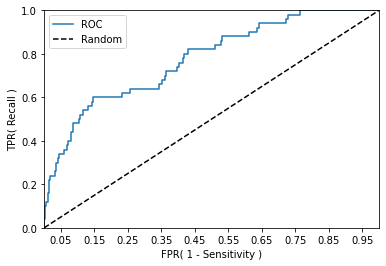



8      예측0  예측1
실제0  781  219
실제1   20   30 
 acc: 0.7724 auc: 0.77616
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1595597530864198
            Iterations: 9
            Function evaluations: 204
            Gradient evaluations: 9

#9 교차 검증 정확도 :0.7819, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#9 검증 세트 인덱스:8000      8000
8001      8001
8002      8002
8003      8003
8004      8004
         ...  
10445    10445
10446    10446
10447    10447
10448    10448
10449    10449
Name: Unnamed: 0, Length: 1050, dtype: int64


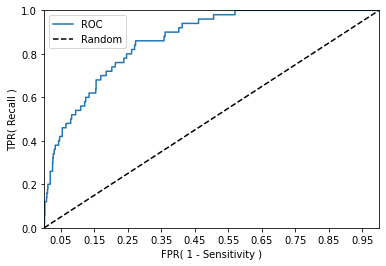



9      예측0  예측1
실제0  783  217
실제1   12   38 
 acc: 0.7819 auc: 0.86281
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13784740740740742
            Iterations: 30
            Function evaluations: 687
            Gradient evaluations: 29

#10 교차 검증 정확도 :0.7571, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#10 검증 세트 인덱스:9000      9000
9001      9001
9002      9002
9003      9003
9004      9004
         ...  
10495    10495
10496    10496
10497    10497
10498    10498
10499    10499
Name: Unnamed: 0, Length: 1050, dtype: int64


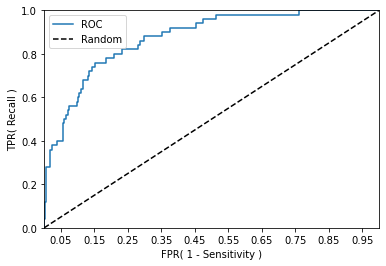



10      예측0  예측1
실제0  754  246
실제1    9   41 
 acc: 0.7571 auc: 0.87402
================================================ 1 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14021506172839515
            Iterations: 9
            Function evaluations: 217
            Gradient evaluations: 9

#11 교차 검증 정확도 :0.779, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#11 검증 세트 인덱스:0            0
1            1
2            2
3            3
4            4
         ...  
10045    10045
10046    10046
10047    10047
10048    10048
10049    10049
Name: Unnamed: 0, Length: 1050, dtype: int64


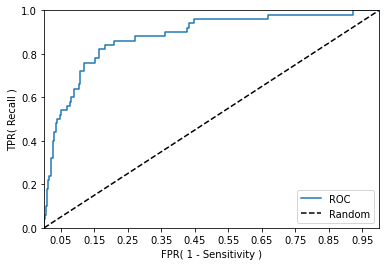



11      예측0  예측1
실제0  775  225
실제1    7   43 
 acc: 0.779 auc: 0.8802000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13680074074074078
            Iterations: 78
            Function evaluations: 1949
            Gradient evaluations: 74

#12 교차 검증 정확도 :0.8, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#12 검증 세트 인덱스:1000      1000
1001      1001
1002      1002
1003      1003
1004      1004
         ...  
10095    10095
10096    10096
10097    10097
10098    10098
10099    10099
Name: Unnamed: 0, Length: 1050, dtype: int64


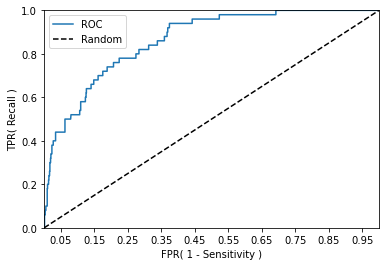



12      예측0  예측1
실제0  803  197
실제1   13   37 
 acc: 0.8 auc: 0.86293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14670567901234555
            Iterations: 5
            Function evaluations: 118
            Gradient evaluations: 5

#13 교차 검증 정확도 :0.7229, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#13 검증 세트 인덱스:2000      2000
2001      2001
2002      2002
2003      2003
2004      2004
         ...  
10145    10145
10146    10146
10147    10147
10148    10148
10149    10149
Name: Unnamed: 0, Length: 1050, dtype: int64


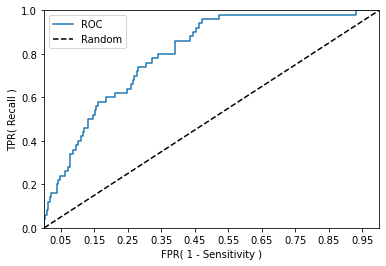



13      예측0  예측1
실제0  723  277
실제1   14   36 
 acc: 0.7229 auc: 0.8011
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13132888888888894
            Iterations: 8
            Function evaluations: 184
            Gradient evaluations: 8

#14 교차 검증 정확도 :0.8038, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#14 검증 세트 인덱스:3000      3000
3001      3001
3002      3002
3003      3003
3004      3004
         ...  
10195    10195
10196    10196
10197    10197
10198    10198
10199    10199
Name: Unnamed: 0, Length: 1050, dtype: int64


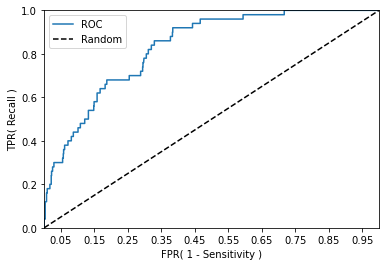



14      예측0  예측1
실제0  810  190
실제1   16   34 
 acc: 0.8038 auc: 0.83119
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13819506172839524
            Iterations: 4
            Function evaluations: 98
            Gradient evaluations: 4

#15 교차 검증 정확도 :0.781, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#15 검증 세트 인덱스:4000      4000
4001      4001
4002      4002
4003      4003
4004      4004
         ...  
10245    10245
10246    10246
10247    10247
10248    10248
10249    10249
Name: Unnamed: 0, Length: 1050, dtype: int64


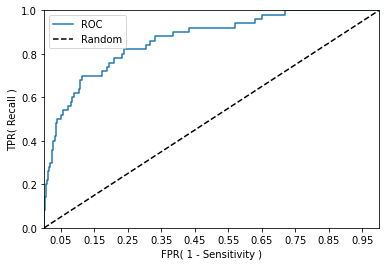



15      예측0  예측1
실제0  781  219
실제1   11   39 
 acc: 0.781 auc: 0.86372
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1473530864197531
            Iterations: 10
            Function evaluations: 224
            Gradient evaluations: 10

#16 교차 검증 정확도 :0.7981, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#16 검증 세트 인덱스:5000      5000
5001      5001
5002      5002
5003      5003
5004      5004
         ...  
10295    10295
10296    10296
10297    10297
10298    10298
10299    10299
Name: Unnamed: 0, Length: 1050, dtype: int64


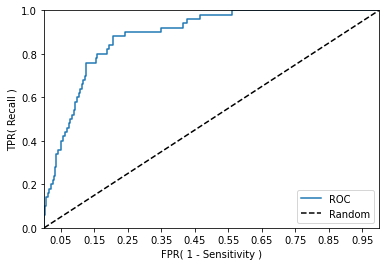



16      예측0  예측1
실제0  796  204
실제1    8   42 
 acc: 0.7981 auc: 0.8855999999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13421703703703702
            Iterations: 14
            Function evaluations: 321
            Gradient evaluations: 14

#17 교차 검증 정확도 :0.7781, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#17 검증 세트 인덱스:6000      6000
6001      6001
6002      6002
6003      6003
6004      6004
         ...  
10345    10345
10346    10346
10347    10347
10348    10348
10349    10349
Name: Unnamed: 0, Length: 1050, dtype: int64


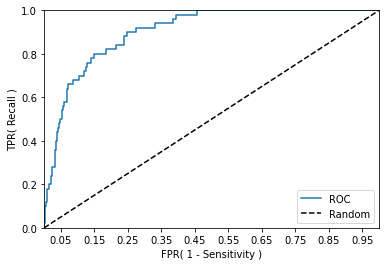



17      예측0  예측1
실제0  775  225
실제1    8   42 
 acc: 0.7781 auc: 0.90314
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1297514814814814
            Iterations: 7
            Function evaluations: 157
            Gradient evaluations: 7

#18 교차 검증 정확도 :0.781, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#18 검증 세트 인덱스:7000      7000
7001      7001
7002      7002
7003      7003
7004      7004
         ...  
10395    10395
10396    10396
10397    10397
10398    10398
10399    10399
Name: Unnamed: 0, Length: 1050, dtype: int64


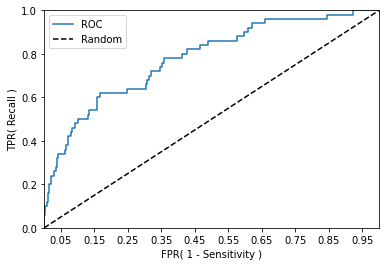



18      예측0  예측1
실제0  789  211
실제1   19   31 
 acc: 0.781 auc: 0.78026
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14800370370370364
            Iterations: 5
            Function evaluations: 118
            Gradient evaluations: 5

#19 교차 검증 정확도 :0.7762, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#19 검증 세트 인덱스:8000      8000
8001      8001
8002      8002
8003      8003
8004      8004
         ...  
10445    10445
10446    10446
10447    10447
10448    10448
10449    10449
Name: Unnamed: 0, Length: 1050, dtype: int64


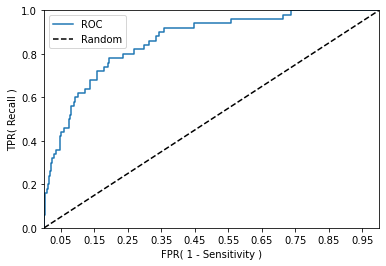



19      예측0  예측1
실제0  776  224
실제1   11   39 
 acc: 0.7762 auc: 0.8600000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13537432098765423
            Iterations: 5
            Function evaluations: 114
            Gradient evaluations: 5

#20 교차 검증 정확도 :0.7629, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#20 검증 세트 인덱스:9000      9000
9001      9001
9002      9002
9003      9003
9004      9004
         ...  
10495    10495
10496    10496
10497    10497
10498    10498
10499    10499
Name: Unnamed: 0, Length: 1050, dtype: int64


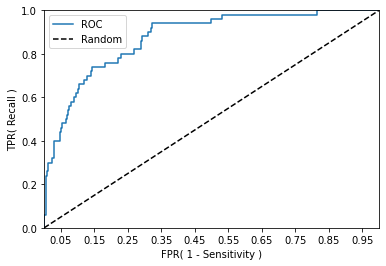



20      예측0  예측1
실제0  761  239
실제1   10   40 
 acc: 0.7629 auc: 0.87494
================================================ 2 번째================================================
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13528000000000007
            Iterations: 15
            Function evaluations: 339
            Gradient evaluations: 14

#21 교차 검증 정확도 :0.7914, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#21 검증 세트 인덱스:0            0
1            1
2            2
3            3
4            4
         ...  
10045    10045
10046    10046
10047    10047
10048    10048
10049    10049
Name: Unnamed: 0, Length: 1050, dtype: int64


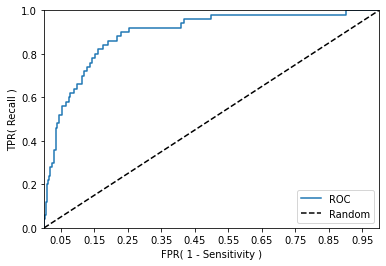



21      예측0  예측1
실제0  788  212
실제1    7   43 
 acc: 0.7914 auc: 0.8923399999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.15984024691358034
            Iterations: 10
            Function evaluations: 227
            Gradient evaluations: 10

#22 교차 검증 정확도 :0.7667, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#22 검증 세트 인덱스:1000      1000
1001      1001
1002      1002
1003      1003
1004      1004
         ...  
10095    10095
10096    10096
10097    10097
10098    10098
10099    10099
Name: Unnamed: 0, Length: 1050, dtype: int64


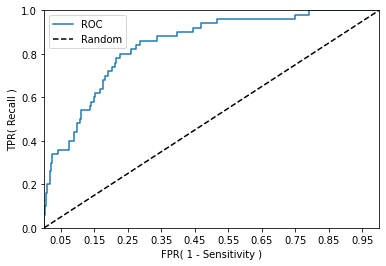



22      예측0  예측1
실제0  765  235
실제1   10   40 
 acc: 0.7667 auc: 0.84212
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13293901234567895
            Iterations: 22
            Function evaluations: 511
            Gradient evaluations: 22

#23 교차 검증 정확도 :0.7762, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#23 검증 세트 인덱스:2000      2000
2001      2001
2002      2002
2003      2003
2004      2004
         ...  
10145    10145
10146    10146
10147    10147
10148    10148
10149    10149
Name: Unnamed: 0, Length: 1050, dtype: int64


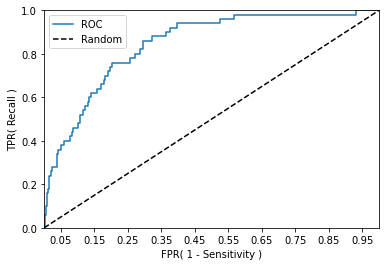



23      예측0  예측1
실제0  777  223
실제1   12   38 
 acc: 0.7762 auc: 0.8445199999999999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12977802469135813
            Iterations: 13
            Function evaluations: 318
            Gradient evaluations: 13

#24 교차 검증 정확도 :0.7943, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#24 검증 세트 인덱스:3000      3000
3001      3001
3002      3002
3003      3003
3004      3004
         ...  
10195    10195
10196    10196
10197    10197
10198    10198
10199    10199
Name: Unnamed: 0, Length: 1050, dtype: int64


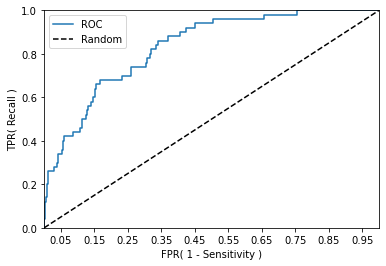



24      예측0  예측1
실제0  800  200
실제1   16   34 
 acc: 0.7943 auc: 0.8321000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14203753086419757
            Iterations: 16
            Function evaluations: 363
            Gradient evaluations: 16

#25 교차 검증 정확도 :0.7838, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#25 검증 세트 인덱스:4000      4000
4001      4001
4002      4002
4003      4003
4004      4004
         ...  
10245    10245
10246    10246
10247    10247
10248    10248
10249    10249
Name: Unnamed: 0, Length: 1050, dtype: int64


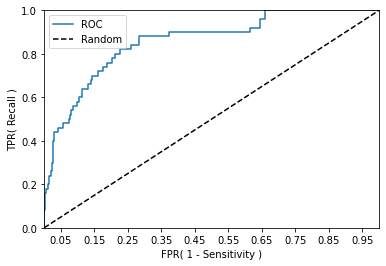



25      예측0  예측1
실제0  783  217
실제1   10   40 
 acc: 0.7838 auc: 0.85704
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1416891358024691
            Iterations: 9
            Function evaluations: 209
            Gradient evaluations: 9

#26 교차 검증 정확도 :0.8048, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#26 검증 세트 인덱스:5000      5000
5001      5001
5002      5002
5003      5003
5004      5004
         ...  
10295    10295
10296    10296
10297    10297
10298    10298
10299    10299
Name: Unnamed: 0, Length: 1050, dtype: int64


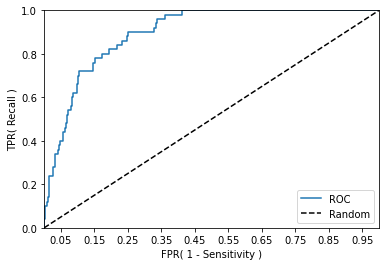



26      예측0  예측1
실제0  804  196
실제1    9   41 
 acc: 0.8048 auc: 0.89642
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1363404938271605
            Iterations: 8
            Function evaluations: 192
            Gradient evaluations: 8

#27 교차 검증 정확도 :0.7762, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#27 검증 세트 인덱스:6000      6000
6001      6001
6002      6002
6003      6003
6004      6004
         ...  
10345    10345
10346    10346
10347    10347
10348    10348
10349    10349
Name: Unnamed: 0, Length: 1050, dtype: int64


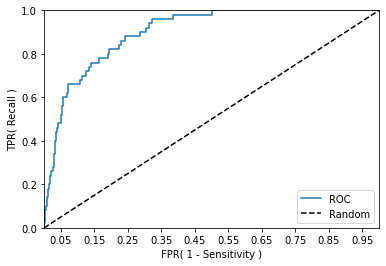



27      예측0  예측1
실제0  773  227
실제1    8   42 
 acc: 0.7762 auc: 0.9005000000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13747654320987646
            Iterations: 10
            Function evaluations: 225
            Gradient evaluations: 10

#28 교차 검증 정확도 :0.7686, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#28 검증 세트 인덱스:7000      7000
7001      7001
7002      7002
7003      7003
7004      7004
         ...  
10395    10395
10396    10396
10397    10397
10398    10398
10399    10399
Name: Unnamed: 0, Length: 1050, dtype: int64


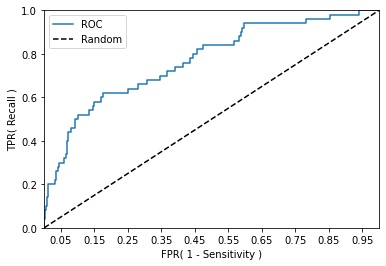



28      예측0  예측1
실제0  776  224
실제1   19   31 
 acc: 0.7686 auc: 0.7696200000000001
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14181777777777782
            Iterations: 8
            Function evaluations: 193
            Gradient evaluations: 8

#29 교차 검증 정확도 :0.7924, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#29 검증 세트 인덱스:8000      8000
8001      8001
8002      8002
8003      8003
8004      8004
         ...  
10445    10445
10446    10446
10447    10447
10448    10448
10449    10449
Name: Unnamed: 0, Length: 1050, dtype: int64


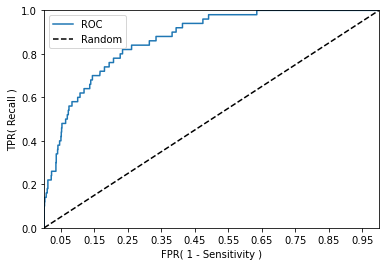



29      예측0  예측1
실제0  793  207
실제1   11   39 
 acc: 0.7924 auc: 0.86857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1451674074074072
            Iterations: 9
            Function evaluations: 229
            Gradient evaluations: 9

#30 교차 검증 정확도 :0.7486, 학습 데이터 크기: 9450, 검증 데이터 크기: 1050
#30 검증 세트 인덱스:9000      9000
9001      9001
9002      9002
9003      9003
9004      9004
         ...  
10495    10495
10496    10496
10497    10497
10498    10498
10499    10499
Name: Unnamed: 0, Length: 1050, dtype: int64


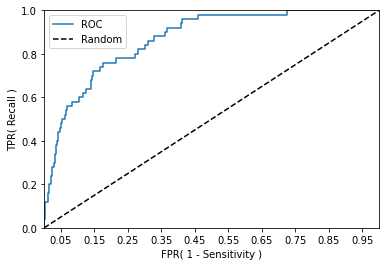



30      예측0  예측1
실제0  747  253
실제1   11   39 
 acc: 0.7486 auc: 0.8689
================================================종료================================================

## 교차 검증별 acc: [0.7924 0.799  0.7324 0.7762 0.7029 0.7667 0.78   0.7724 0.7819 0.7571
 0.779  0.8    0.7229 0.8038 0.781  0.7981 0.7781 0.781  0.7762 0.7629
 0.7914 0.7667 0.7762 0.7943 0.7838 0.8048 0.7762 0.7686 0.7924 0.7486]

## 교차 검증별 auc: [0.8899 0.8701 0.8065 0.8297 0.8043 0.7721 0.8902 0.7762 0.8628 0.874
 0.8802 0.8629 0.8011 0.8312 0.8637 0.8856 0.9031 0.7803 0.86   0.8749
 0.8923 0.8421 0.8445 0.8321 0.857  0.8964 0.9005 0.7696 0.8686 0.8689]
## 평균 검증 정확도: 0.7749
## 평균 검증 auc: 0.8496996666666666
          fold_0             fold_1              fold_2            fold_3  \
             예측0      예측1       예측0       예측1       예측0       예측1     예측0   
실제0     789.0000  211.000  800.0000  200.0000  728.0000  272.0000  779.00   
실제1       7.0000   43.000   11.0000   39.0000    9.0000   41.0000   14.00   
accauc 

In [21]:
for i in xlsxs:
    print("================================================",i,"================================================")
    defaultfit(i)
    aucweightfit(i)
    

# 다중엑셀 쓰고 읽기 나중에 혹시나 잊을까봐 - 결국안씀
* https://blog.naver.com/PostView.nhn?blogId=kiddwannabe&logNo=221597578686

# predict proba랑 decision_function에서 나오는 확률이 다른지 확인 필요함 

In [ ]:
# 다르다면 뭐를 써야하는지도 판단이 필요